## Submodule-2.1 : Dynamical Systems

## Table of Contents
#### 1. [PINN for Burger's Equation](#PINN-for-Burger's-Equation)


## PINN-for-Burger's-Equation

In [1]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

/Users/raj/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [ ]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b

def net_u(x, t, w, b):
    u = DNN(tf.concat([x,t],1), w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function
def net_f(x,t,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x, t])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x, t])
            u=net_u(x,t, W, b)
        u_t = tape2.gradient(u, t)
        u_x = tape2.gradient(u, x)
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_t + u*u_x - nu*u_xx
    return f



#@tf.function(jit_compile=True)
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu):
    x_u = X_u_train_tf[:,0:1]
    t_u = X_u_train_tf[:,1:2]
    x_f = X_f_train_tf[:,0:1]
    t_f = X_f_train_tf[:,1:2]
    with tf.GradientTape() as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u, t_u, W, b) 
        f_nn = net_f(x_f,t_f, W, b, nu)
        loss =  tf.reduce_mean(tf.square(u_nn - u_train_tf)) + tf.reduce_mean(tf.square(f_nn)) 
    grads = tape.gradient(loss, train_vars(W,b))
    opt.apply_gradients(zip(grads, train_vars(W,b)))
    return loss


    
nu = 0.01/np.pi
noise = 0.0        
N_u = 100
N_f = 10000
Nmax=40000

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

data = scipy.io.loadmat('./Data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              
# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)

X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)

lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu)
    loss.append(loss_)    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

    

Error u: 1.140260e-02


Text(0.5, 1.0, '$t = 0.75$')

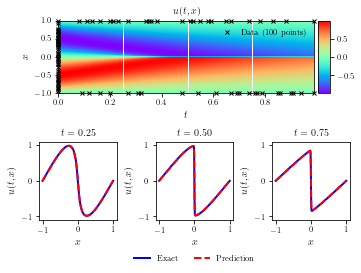

In [33]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf[:,0:1]
    t_star = X_star_tf[:,1:2]
    u_pred = net_u(x_star, t_star, w, b)
    return u_pred
    
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     
U_pred = griddata(X_star, u_pred.numpy().flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)


fig, ax = newfig(1.0, 1.1)
ax.axis('off')

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)

####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)

In [18]:
loss[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.25663102>

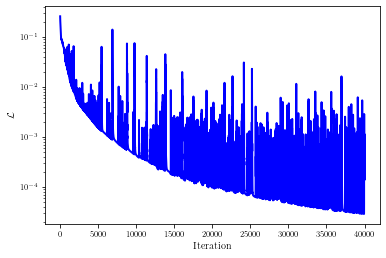

In [35]:
it = np.arange(0,40001, 1)
loss_list = [loss[i].numpy() for i in range(0,40001)]
plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Exact')       
plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')    
plt.show()

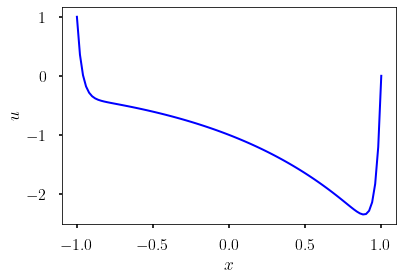

In [2]:
### Solution of Equation using Central Finite Difference Equation
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
%matplotlib inline
matplotlib.rc('font', family='serif', serif='cm10')

matplotlib.rc('text', usetex=True)
### Number of Gridpoints
nu =1.0/10**-3
n = 100
h = (1+1) / n
x = np.linspace(-1,1,n+1)
# Difference Operator
A = np.zeros((n+1, n+1))

## Coefficient For Boundary Condition
A[0, 0] = 1
A[n, n] = 1

### Maric for Interior Point
for i in range(1, n):
    A[i, i-1] = 1
    A[i, i] = -(2 + (nu)*h**2)
    A[i, i+1] = 1

# Get b
b = np.zeros(n+1)
b = (np.exp(x))*h*h*(nu)

#### Imposition Boundary Condition 
b[0] = 1
b[-1] = 0
# solve the linear equations
y_act = np.linalg.solve(A, b)
### Plot of Equation
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])
ax.plot(x, y_act, "-", lw=2.0, color="b")
ax.set_xlabel('$x$')
ax.set_ylabel("$u$")
plt.show()

In [ ]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f



#@tf.function(jit_compile=True)
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu):
    x_u = X_u_train_tf
    x_f = X_f_train_tf
    with tf.GradientTape() as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u, W, b) 
        f_nn = net_f(x_f,W, b, nu)
        loss =  100.0*tf.reduce_mean(tf.square(u_nn - u_train_tf)) + tf.reduce_mean(tf.square(f_nn)) 
    grads = tape.gradient(loss, train_vars(W,b))
    opt.apply_gradients(zip(grads, train_vars(W,b)))
    return loss

def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**3
noise = 0.0        
N_f = 300
Nmax=3000

layers = [1, 4,4,4,4,4,4, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)


lr = 5e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu)
    loss.append(loss_)    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Error u: 1.933103e+01


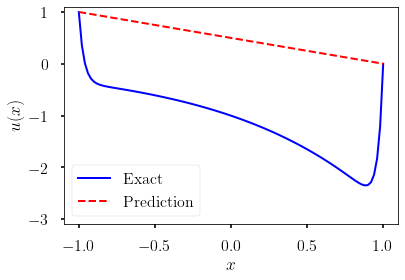

No handles with labels found to put in legend.


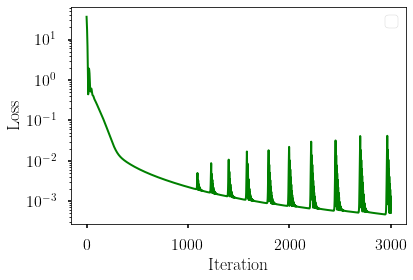

In [98]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,loss_list, 'g-', linewidth = 2)       
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()





In [ ]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars_nn(W, b):
    return W + b

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def train_vars_sa(lambda_r, lambda_b):
    return lambda_r + lambda_b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    return alpha_r, alpha_b


#@tf.function(jit_compile=True)
@tf.function
def net_f(x, W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f

@tf.function
def net_fd(x, W, b, nu):
    h=0.1
    u_xx= (1/(h**2))*(net_u(x + h , W, b) - net_u(x, W, b) + net_u(x-h, W, b))
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f



#@tf.function(jit_compile=True)
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu, lambda_r, lambda_b):
    x_u = X_u_train_tf
    x_f = X_f_train_tf
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W,b,lambda_r,lambda_b])
        u_nn = net_u(x_u, W, b) 
        f_nn = net_f(x_f,W, b, nu)
        loss_r = tf.square(lambda_r*f_nn)
        loss_b = tf.square(lambda_b*(u_nn-u_train_tf))
        loss =    tf.reduce_mean(loss_b) + tf.reduce_mean(loss_r)  
    grads = tape.gradient(loss, train_vars_nn(W, b))
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    opt.apply_gradients(zip(grads, train_vars_nn(W,b)))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    return loss

def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**-3
Nmax= 3000
N_f = 500
N_b = 2

layers = [1, 8, 8, 8,8,8,8, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

alpha_r, alpha_b = loss_weight(N_f, N_b)

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)


lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu, alpha_r, alpha_b)
    loss.append(loss_)    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))


Error u: 7.361192e+00


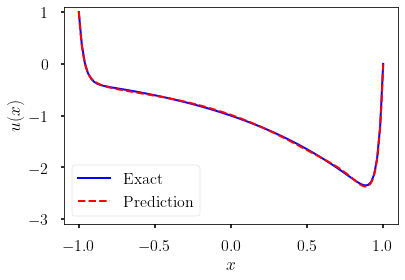

No handles with labels found to put in legend.


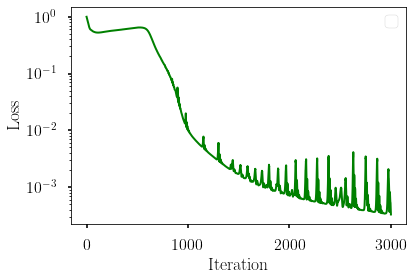

In [109]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,loss_list/(np.max(loss_list)), 'g-', linewidth = 2)       
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()



Iteration is: 0 and loss is: [871706.6]
Iteration is: 1 and loss is: [18.274786]
Iteration is: 2 and loss is: [9.62311]
Iteration is: 3 and loss is: [6.764636]
Iteration is: 4 and loss is: [5.348354]
Iteration is: 5 and loss is: [4.5067835]
Iteration is: 6 and loss is: [3.9515827]
Iteration is: 7 and loss is: [3.559522]
Iteration is: 8 and loss is: [3.2690904]
Iteration is: 9 and loss is: [3.0461984]
Iteration is: 10 and loss is: [2.870465]
Iteration is: 11 and loss is: [2.7289348]
Iteration is: 12 and loss is: [2.6129756]
Iteration is: 13 and loss is: [2.5166261]
Iteration is: 14 and loss is: [2.4356334]
Iteration is: 15 and loss is: [2.3668954]
Iteration is: 16 and loss is: [2.3080738]
Iteration is: 17 and loss is: [2.257378]
Iteration is: 18 and loss is: [2.2134166]
Iteration is: 19 and loss is: [2.1750846]
Iteration is: 20 and loss is: [2.141502]
Iteration is: 21 and loss is: [2.1119604]
Iteration is: 22 and loss is: [2.0858803]
Iteration is: 23 and loss is: [2.0627725]
Iteration i

Iteration is: 273 and loss is: [1.8565542]
Iteration is: 274 and loss is: [1.8565495]
Iteration is: 275 and loss is: [1.8565452]
Iteration is: 276 and loss is: [1.8565407]
Iteration is: 277 and loss is: [1.856536]
Iteration is: 278 and loss is: [1.8565317]
Iteration is: 279 and loss is: [1.8565271]
Iteration is: 280 and loss is: [1.8565227]
Iteration is: 281 and loss is: [1.8565181]
Iteration is: 282 and loss is: [1.8565136]
Iteration is: 283 and loss is: [1.8565091]
Iteration is: 284 and loss is: [1.8565047]
Iteration is: 285 and loss is: [1.8564999]
Iteration is: 286 and loss is: [1.8564956]
Iteration is: 287 and loss is: [1.856491]
Iteration is: 288 and loss is: [1.8564864]
Iteration is: 289 and loss is: [1.8564817]
Iteration is: 290 and loss is: [1.8564769]
Iteration is: 291 and loss is: [1.8564725]
Iteration is: 292 and loss is: [1.8564678]
Iteration is: 293 and loss is: [1.8564631]
Iteration is: 294 and loss is: [1.8564587]
Iteration is: 295 and loss is: [1.8564541]
Iteration is:

Iteration is: 551 and loss is: [1.8550314]
Iteration is: 552 and loss is: [1.8550249]
Iteration is: 553 and loss is: [1.8550184]
Iteration is: 554 and loss is: [1.8550116]
Iteration is: 555 and loss is: [1.855005]
Iteration is: 556 and loss is: [1.8549984]
Iteration is: 557 and loss is: [1.8549916]
Iteration is: 558 and loss is: [1.854985]
Iteration is: 559 and loss is: [1.8549782]
Iteration is: 560 and loss is: [1.8549716]
Iteration is: 561 and loss is: [1.854965]
Iteration is: 562 and loss is: [1.8549583]
Iteration is: 563 and loss is: [1.8549513]
Iteration is: 564 and loss is: [1.8549446]
Iteration is: 565 and loss is: [1.8549381]
Iteration is: 566 and loss is: [1.8549312]
Iteration is: 567 and loss is: [1.8549246]
Iteration is: 568 and loss is: [1.8549178]
Iteration is: 569 and loss is: [1.8549112]
Iteration is: 570 and loss is: [1.8549044]
Iteration is: 571 and loss is: [1.8548977]
Iteration is: 572 and loss is: [1.8548911]
Iteration is: 573 and loss is: [1.8548844]
Iteration is: 

Iteration is: 830 and loss is: [1.8529016]
Iteration is: 831 and loss is: [1.8528929]
Iteration is: 832 and loss is: [1.8528844]
Iteration is: 833 and loss is: [1.8528755]
Iteration is: 834 and loss is: [1.8528669]
Iteration is: 835 and loss is: [1.852858]
Iteration is: 836 and loss is: [1.8528494]
Iteration is: 837 and loss is: [1.8528405]
Iteration is: 838 and loss is: [1.8528317]
Iteration is: 839 and loss is: [1.852823]
Iteration is: 840 and loss is: [1.8528143]
Iteration is: 841 and loss is: [1.8528057]
Iteration is: 842 and loss is: [1.8527968]
Iteration is: 843 and loss is: [1.8527879]
Iteration is: 844 and loss is: [1.8527792]
Iteration is: 845 and loss is: [1.8527704]
Iteration is: 846 and loss is: [1.8527617]
Iteration is: 847 and loss is: [1.8527529]
Iteration is: 848 and loss is: [1.8527441]
Iteration is: 849 and loss is: [1.8527352]
Iteration is: 850 and loss is: [1.8527265]
Iteration is: 851 and loss is: [1.8527176]
Iteration is: 852 and loss is: [1.8527086]
Iteration is:

Iteration is: 1108 and loss is: [1.8501943]
Iteration is: 1109 and loss is: [1.8501836]
Iteration is: 1110 and loss is: [1.8501728]
Iteration is: 1111 and loss is: [1.8501618]
Iteration is: 1112 and loss is: [1.850151]
Iteration is: 1113 and loss is: [1.8501403]
Iteration is: 1114 and loss is: [1.8501295]
Iteration is: 1115 and loss is: [1.8501188]
Iteration is: 1116 and loss is: [1.8501078]
Iteration is: 1117 and loss is: [1.8500968]
Iteration is: 1118 and loss is: [1.850086]
Iteration is: 1119 and loss is: [1.8500748]
Iteration is: 1120 and loss is: [1.8500639]
Iteration is: 1121 and loss is: [1.8500528]
Iteration is: 1122 and loss is: [1.850042]
Iteration is: 1123 and loss is: [1.850031]
Iteration is: 1124 and loss is: [1.85002]
Iteration is: 1125 and loss is: [1.850009]
Iteration is: 1126 and loss is: [1.8499981]
Iteration is: 1127 and loss is: [1.849987]
Iteration is: 1128 and loss is: [1.8499761]
Iteration is: 1129 and loss is: [1.8499651]
Iteration is: 1130 and loss is: [1.84995

Iteration is: 1383 and loss is: [1.84689]
Iteration is: 1384 and loss is: [1.8468767]
Iteration is: 1385 and loss is: [1.8468633]
Iteration is: 1386 and loss is: [1.8468502]
Iteration is: 1387 and loss is: [1.8468368]
Iteration is: 1388 and loss is: [1.8468235]
Iteration is: 1389 and loss is: [1.8468103]
Iteration is: 1390 and loss is: [1.8467971]
Iteration is: 1391 and loss is: [1.8467836]
Iteration is: 1392 and loss is: [1.8467705]
Iteration is: 1393 and loss is: [1.8467572]
Iteration is: 1394 and loss is: [1.8467438]
Iteration is: 1395 and loss is: [1.8467307]
Iteration is: 1396 and loss is: [1.8467171]
Iteration is: 1397 and loss is: [1.8467036]
Iteration is: 1398 and loss is: [1.8466908]
Iteration is: 1399 and loss is: [1.8466772]
Iteration is: 1400 and loss is: [1.8466638]
Iteration is: 1401 and loss is: [1.8466505]
Iteration is: 1402 and loss is: [1.8466372]
Iteration is: 1403 and loss is: [1.8466239]
Iteration is: 1404 and loss is: [1.8466104]
Iteration is: 1405 and loss is: [1

Iteration is: 1661 and loss is: [1.8428639]
Iteration is: 1662 and loss is: [1.8428482]
Iteration is: 1663 and loss is: [1.8428323]
Iteration is: 1664 and loss is: [1.8428164]
Iteration is: 1665 and loss is: [1.8428006]
Iteration is: 1666 and loss is: [1.8427846]
Iteration is: 1667 and loss is: [1.8427689]
Iteration is: 1668 and loss is: [1.842753]
Iteration is: 1669 and loss is: [1.8427372]
Iteration is: 1670 and loss is: [1.8427213]
Iteration is: 1671 and loss is: [1.8427054]
Iteration is: 1672 and loss is: [1.8426896]
Iteration is: 1673 and loss is: [1.8426737]
Iteration is: 1674 and loss is: [1.8426578]
Iteration is: 1675 and loss is: [1.8426418]
Iteration is: 1676 and loss is: [1.8426259]
Iteration is: 1677 and loss is: [1.8426099]
Iteration is: 1678 and loss is: [1.842594]
Iteration is: 1679 and loss is: [1.8425782]
Iteration is: 1680 and loss is: [1.8425621]
Iteration is: 1681 and loss is: [1.8425463]
Iteration is: 1682 and loss is: [1.8425304]
Iteration is: 1683 and loss is: [1

Iteration is: 1935 and loss is: [1.8381613]
Iteration is: 1936 and loss is: [1.8381429]
Iteration is: 1937 and loss is: [1.838124]
Iteration is: 1938 and loss is: [1.8381051]
Iteration is: 1939 and loss is: [1.8380866]
Iteration is: 1940 and loss is: [1.8380679]
Iteration is: 1941 and loss is: [1.8380489]
Iteration is: 1942 and loss is: [1.8380303]
Iteration is: 1943 and loss is: [1.8380119]
Iteration is: 1944 and loss is: [1.8379931]
Iteration is: 1945 and loss is: [1.8379743]
Iteration is: 1946 and loss is: [1.8379557]
Iteration is: 1947 and loss is: [1.8379369]
Iteration is: 1948 and loss is: [1.8379179]
Iteration is: 1949 and loss is: [1.8378992]
Iteration is: 1950 and loss is: [1.8378805]
Iteration is: 1951 and loss is: [1.8378619]
Iteration is: 1952 and loss is: [1.8378427]
Iteration is: 1953 and loss is: [1.8378242]
Iteration is: 1954 and loss is: [1.8378053]
Iteration is: 1955 and loss is: [1.8377864]
Iteration is: 1956 and loss is: [1.8377675]
Iteration is: 1957 and loss is: [

Iteration is: 2216 and loss is: [1.832476]
Iteration is: 2217 and loss is: [1.8324542]
Iteration is: 2218 and loss is: [1.8324322]
Iteration is: 2219 and loss is: [1.8324105]
Iteration is: 2220 and loss is: [1.8323886]
Iteration is: 2221 and loss is: [1.8323666]
Iteration is: 2222 and loss is: [1.8323447]
Iteration is: 2223 and loss is: [1.8323226]
Iteration is: 2224 and loss is: [1.8323009]
Iteration is: 2225 and loss is: [1.8322786]
Iteration is: 2226 and loss is: [1.8322567]
Iteration is: 2227 and loss is: [1.8322346]
Iteration is: 2228 and loss is: [1.8322128]
Iteration is: 2229 and loss is: [1.8321909]
Iteration is: 2230 and loss is: [1.8321687]
Iteration is: 2231 and loss is: [1.8321464]
Iteration is: 2232 and loss is: [1.8321244]
Iteration is: 2233 and loss is: [1.8321021]
Iteration is: 2234 and loss is: [1.8320798]
Iteration is: 2235 and loss is: [1.8320575]
Iteration is: 2236 and loss is: [1.8320354]
Iteration is: 2237 and loss is: [1.8320132]
Iteration is: 2238 and loss is: [

Iteration is: 2504 and loss is: [1.8256385]
Iteration is: 2505 and loss is: [1.8256127]
Iteration is: 2506 and loss is: [1.8255872]
Iteration is: 2507 and loss is: [1.825561]
Iteration is: 2508 and loss is: [1.8255353]
Iteration is: 2509 and loss is: [1.8255095]
Iteration is: 2510 and loss is: [1.8254837]
Iteration is: 2511 and loss is: [1.8254579]
Iteration is: 2512 and loss is: [1.8254317]
Iteration is: 2513 and loss is: [1.8254061]
Iteration is: 2514 and loss is: [1.8253801]
Iteration is: 2515 and loss is: [1.825354]
Iteration is: 2516 and loss is: [1.8253284]
Iteration is: 2517 and loss is: [1.8253024]
Iteration is: 2518 and loss is: [1.8252766]
Iteration is: 2519 and loss is: [1.8252506]
Iteration is: 2520 and loss is: [1.8252246]
Iteration is: 2521 and loss is: [1.8251985]
Iteration is: 2522 and loss is: [1.8251728]
Iteration is: 2523 and loss is: [1.8251468]
Iteration is: 2524 and loss is: [1.8251208]
Iteration is: 2525 and loss is: [1.8250948]
Iteration is: 2526 and loss is: [1

Iteration is: 2779 and loss is: [1.8180143]
Iteration is: 2780 and loss is: [1.8179843]
Iteration is: 2781 and loss is: [1.8179543]
Iteration is: 2782 and loss is: [1.8179244]
Iteration is: 2783 and loss is: [1.8178946]
Iteration is: 2784 and loss is: [1.8178644]
Iteration is: 2785 and loss is: [1.8178346]
Iteration is: 2786 and loss is: [1.8178042]
Iteration is: 2787 and loss is: [1.8177745]
Iteration is: 2788 and loss is: [1.8177443]
Iteration is: 2789 and loss is: [1.8177143]
Iteration is: 2790 and loss is: [1.817684]
Iteration is: 2791 and loss is: [1.8176539]
Iteration is: 2792 and loss is: [1.817624]
Iteration is: 2793 and loss is: [1.8175937]
Iteration is: 2794 and loss is: [1.8175634]
Iteration is: 2795 and loss is: [1.8175335]
Iteration is: 2796 and loss is: [1.8175031]
Iteration is: 2797 and loss is: [1.8174728]
Iteration is: 2798 and loss is: [1.8174429]
Iteration is: 2799 and loss is: [1.8174127]
Iteration is: 2800 and loss is: [1.8173825]
Iteration is: 2801 and loss is: [1

Iteration is: 3054 and loss is: [1.8091569]
Iteration is: 3055 and loss is: [1.8091221]
Iteration is: 3056 and loss is: [1.8090876]
Iteration is: 3057 and loss is: [1.8090528]
Iteration is: 3058 and loss is: [1.8090179]
Iteration is: 3059 and loss is: [1.8089833]
Iteration is: 3060 and loss is: [1.8089484]
Iteration is: 3061 and loss is: [1.8089136]
Iteration is: 3062 and loss is: [1.8088788]
Iteration is: 3063 and loss is: [1.8088442]
Iteration is: 3064 and loss is: [1.8088093]
Iteration is: 3065 and loss is: [1.8087745]
Iteration is: 3066 and loss is: [1.8087393]
Iteration is: 3067 and loss is: [1.8087046]
Iteration is: 3068 and loss is: [1.8086696]
Iteration is: 3069 and loss is: [1.8086346]
Iteration is: 3070 and loss is: [1.8085997]
Iteration is: 3071 and loss is: [1.8085649]
Iteration is: 3072 and loss is: [1.8085299]
Iteration is: 3073 and loss is: [1.8084949]
Iteration is: 3074 and loss is: [1.8084596]
Iteration is: 3075 and loss is: [1.8084247]
Iteration is: 3076 and loss is: 

Iteration is: 3335 and loss is: [1.7986562]
Iteration is: 3336 and loss is: [1.798616]
Iteration is: 3337 and loss is: [1.7985756]
Iteration is: 3338 and loss is: [1.7985356]
Iteration is: 3339 and loss is: [1.7984953]
Iteration is: 3340 and loss is: [1.798455]
Iteration is: 3341 and loss is: [1.7984147]
Iteration is: 3342 and loss is: [1.7983747]
Iteration is: 3343 and loss is: [1.7983344]
Iteration is: 3344 and loss is: [1.798294]
Iteration is: 3345 and loss is: [1.7982538]
Iteration is: 3346 and loss is: [1.7982132]
Iteration is: 3347 and loss is: [1.7981728]
Iteration is: 3348 and loss is: [1.7981323]
Iteration is: 3349 and loss is: [1.7980919]
Iteration is: 3350 and loss is: [1.7980515]
Iteration is: 3351 and loss is: [1.7980111]
Iteration is: 3352 and loss is: [1.7979704]
Iteration is: 3353 and loss is: [1.79793]
Iteration is: 3354 and loss is: [1.7978894]
Iteration is: 3355 and loss is: [1.7978488]
Iteration is: 3356 and loss is: [1.7978082]
Iteration is: 3357 and loss is: [1.79

Iteration is: 3618 and loss is: [1.7863895]
Iteration is: 3619 and loss is: [1.7863429]
Iteration is: 3620 and loss is: [1.7862961]
Iteration is: 3621 and loss is: [1.7862494]
Iteration is: 3622 and loss is: [1.7862029]
Iteration is: 3623 and loss is: [1.7861564]
Iteration is: 3624 and loss is: [1.7861094]
Iteration is: 3625 and loss is: [1.7860628]
Iteration is: 3626 and loss is: [1.7860159]
Iteration is: 3627 and loss is: [1.7859691]
Iteration is: 3628 and loss is: [1.7859223]
Iteration is: 3629 and loss is: [1.7858754]
Iteration is: 3630 and loss is: [1.7858284]
Iteration is: 3631 and loss is: [1.7857816]
Iteration is: 3632 and loss is: [1.7857347]
Iteration is: 3633 and loss is: [1.7856877]
Iteration is: 3634 and loss is: [1.7856407]
Iteration is: 3635 and loss is: [1.7855939]
Iteration is: 3636 and loss is: [1.7855465]
Iteration is: 3637 and loss is: [1.7854996]
Iteration is: 3638 and loss is: [1.7854525]
Iteration is: 3639 and loss is: [1.7854054]
Iteration is: 3640 and loss is: 

Iteration is: 3898 and loss is: [1.7723244]
Iteration is: 3899 and loss is: [1.7722704]
Iteration is: 3900 and loss is: [1.7722166]
Iteration is: 3901 and loss is: [1.7721624]
Iteration is: 3902 and loss is: [1.7721082]
Iteration is: 3903 and loss is: [1.7720541]
Iteration is: 3904 and loss is: [1.7719997]
Iteration is: 3905 and loss is: [1.7719454]
Iteration is: 3906 and loss is: [1.7718914]
Iteration is: 3907 and loss is: [1.7718368]
Iteration is: 3908 and loss is: [1.7717824]
Iteration is: 3909 and loss is: [1.7717282]
Iteration is: 3910 and loss is: [1.7716738]
Iteration is: 3911 and loss is: [1.7716193]
Iteration is: 3912 and loss is: [1.7715647]
Iteration is: 3913 and loss is: [1.7715104]
Iteration is: 3914 and loss is: [1.7714558]
Iteration is: 3915 and loss is: [1.7714012]
Iteration is: 3916 and loss is: [1.7713467]
Iteration is: 3917 and loss is: [1.7712922]
Iteration is: 3918 and loss is: [1.7712375]
Iteration is: 3919 and loss is: [1.7711828]
Iteration is: 3920 and loss is: 

Iteration is: 4169 and loss is: [1.7566029]
Iteration is: 4170 and loss is: [1.7565404]
Iteration is: 4171 and loss is: [1.7564781]
Iteration is: 4172 and loss is: [1.7564157]
Iteration is: 4173 and loss is: [1.7563533]
Iteration is: 4174 and loss is: [1.7562908]
Iteration is: 4175 and loss is: [1.7562286]
Iteration is: 4176 and loss is: [1.756166]
Iteration is: 4177 and loss is: [1.7561035]
Iteration is: 4178 and loss is: [1.756041]
Iteration is: 4179 and loss is: [1.7559786]
Iteration is: 4180 and loss is: [1.7559161]
Iteration is: 4181 and loss is: [1.7558533]
Iteration is: 4182 and loss is: [1.7557908]
Iteration is: 4183 and loss is: [1.7557279]
Iteration is: 4184 and loss is: [1.7556652]
Iteration is: 4185 and loss is: [1.7556026]
Iteration is: 4186 and loss is: [1.7555398]
Iteration is: 4187 and loss is: [1.7554772]
Iteration is: 4188 and loss is: [1.7554146]
Iteration is: 4189 and loss is: [1.7553517]
Iteration is: 4190 and loss is: [1.755289]
Iteration is: 4191 and loss is: [1.

Iteration is: 4461 and loss is: [1.7369864]
Iteration is: 4462 and loss is: [1.7369152]
Iteration is: 4463 and loss is: [1.7368447]
Iteration is: 4464 and loss is: [1.736774]
Iteration is: 4465 and loss is: [1.7367032]
Iteration is: 4466 and loss is: [1.7366327]
Iteration is: 4467 and loss is: [1.7365619]
Iteration is: 4468 and loss is: [1.7364912]
Iteration is: 4469 and loss is: [1.7364208]
Iteration is: 4470 and loss is: [1.7363503]
Iteration is: 4471 and loss is: [1.7362798]
Iteration is: 4472 and loss is: [1.7362093]
Iteration is: 4473 and loss is: [1.7361388]
Iteration is: 4474 and loss is: [1.7360682]
Iteration is: 4475 and loss is: [1.7359974]
Iteration is: 4476 and loss is: [1.735927]
Iteration is: 4477 and loss is: [1.7358563]
Iteration is: 4478 and loss is: [1.7357856]
Iteration is: 4479 and loss is: [1.7357147]
Iteration is: 4480 and loss is: [1.7356441]
Iteration is: 4481 and loss is: [1.7355734]
Iteration is: 4482 and loss is: [1.7355024]
Iteration is: 4483 and loss is: [1

Iteration is: 4755 and loss is: [1.7147425]
Iteration is: 4756 and loss is: [1.7146608]
Iteration is: 4757 and loss is: [1.7145789]
Iteration is: 4758 and loss is: [1.714497]
Iteration is: 4759 and loss is: [1.714415]
Iteration is: 4760 and loss is: [1.714333]
Iteration is: 4761 and loss is: [1.7142512]
Iteration is: 4762 and loss is: [1.7141691]
Iteration is: 4763 and loss is: [1.7140869]
Iteration is: 4764 and loss is: [1.7140046]
Iteration is: 4765 and loss is: [1.7139225]
Iteration is: 4766 and loss is: [1.7138404]
Iteration is: 4767 and loss is: [1.7137583]
Iteration is: 4768 and loss is: [1.7136761]
Iteration is: 4769 and loss is: [1.7135936]
Iteration is: 4770 and loss is: [1.7135113]
Iteration is: 4771 and loss is: [1.7134289]
Iteration is: 4772 and loss is: [1.7133465]
Iteration is: 4773 and loss is: [1.713264]
Iteration is: 4774 and loss is: [1.7131816]
Iteration is: 4775 and loss is: [1.713099]
Iteration is: 4776 and loss is: [1.7130164]
Iteration is: 4777 and loss is: [1.71

Iteration is: 5043 and loss is: [1.6892985]
Iteration is: 5044 and loss is: [1.6892028]
Iteration is: 5045 and loss is: [1.6891075]
Iteration is: 5046 and loss is: [1.6890119]
Iteration is: 5047 and loss is: [1.6889167]
Iteration is: 5048 and loss is: [1.688821]
Iteration is: 5049 and loss is: [1.6887252]
Iteration is: 5050 and loss is: [1.6886296]
Iteration is: 5051 and loss is: [1.688534]
Iteration is: 5052 and loss is: [1.6884382]
Iteration is: 5053 and loss is: [1.6883423]
Iteration is: 5054 and loss is: [1.6882466]
Iteration is: 5055 and loss is: [1.6881506]
Iteration is: 5056 and loss is: [1.6880544]
Iteration is: 5057 and loss is: [1.6879586]
Iteration is: 5058 and loss is: [1.6878624]
Iteration is: 5059 and loss is: [1.6877662]
Iteration is: 5060 and loss is: [1.6876701]
Iteration is: 5061 and loss is: [1.6875738]
Iteration is: 5062 and loss is: [1.6874775]
Iteration is: 5063 and loss is: [1.6873813]
Iteration is: 5064 and loss is: [1.6872848]
Iteration is: 5065 and loss is: [1

Iteration is: 5320 and loss is: [1.6608018]
Iteration is: 5321 and loss is: [1.6606908]
Iteration is: 5322 and loss is: [1.6605799]
Iteration is: 5323 and loss is: [1.660469]
Iteration is: 5324 and loss is: [1.660358]
Iteration is: 5325 and loss is: [1.660247]
Iteration is: 5326 and loss is: [1.6601359]
Iteration is: 5327 and loss is: [1.6600248]
Iteration is: 5328 and loss is: [1.6599134]
Iteration is: 5329 and loss is: [1.659802]
Iteration is: 5330 and loss is: [1.6596909]
Iteration is: 5331 and loss is: [1.6595794]
Iteration is: 5332 and loss is: [1.6594678]
Iteration is: 5333 and loss is: [1.6593564]
Iteration is: 5334 and loss is: [1.6592447]
Iteration is: 5335 and loss is: [1.6591332]
Iteration is: 5336 and loss is: [1.6590214]
Iteration is: 5337 and loss is: [1.6589094]
Iteration is: 5338 and loss is: [1.6587977]
Iteration is: 5339 and loss is: [1.6586859]
Iteration is: 5340 and loss is: [1.6585739]
Iteration is: 5341 and loss is: [1.6584619]
Iteration is: 5342 and loss is: [1.6

Iteration is: 5594 and loss is: [1.6279322]
Iteration is: 5595 and loss is: [1.6278015]
Iteration is: 5596 and loss is: [1.6276709]
Iteration is: 5597 and loss is: [1.6275403]
Iteration is: 5598 and loss is: [1.6274095]
Iteration is: 5599 and loss is: [1.6272787]
Iteration is: 5600 and loss is: [1.6271477]
Iteration is: 5601 and loss is: [1.6270167]
Iteration is: 5602 and loss is: [1.6268855]
Iteration is: 5603 and loss is: [1.6267543]
Iteration is: 5604 and loss is: [1.6266229]
Iteration is: 5605 and loss is: [1.6264917]
Iteration is: 5606 and loss is: [1.6263599]
Iteration is: 5607 and loss is: [1.6262288]
Iteration is: 5608 and loss is: [1.6260973]
Iteration is: 5609 and loss is: [1.6259652]
Iteration is: 5610 and loss is: [1.6258337]
Iteration is: 5611 and loss is: [1.6257018]
Iteration is: 5612 and loss is: [1.6255702]
Iteration is: 5613 and loss is: [1.6254385]
Iteration is: 5614 and loss is: [1.6253062]
Iteration is: 5615 and loss is: [1.625174]
Iteration is: 5616 and loss is: [

Iteration is: 5866 and loss is: [1.5892873]
Iteration is: 5867 and loss is: [1.5891311]
Iteration is: 5868 and loss is: [1.5889747]
Iteration is: 5869 and loss is: [1.5888184]
Iteration is: 5870 and loss is: [1.5886618]
Iteration is: 5871 and loss is: [1.5885051]
Iteration is: 5872 and loss is: [1.5883485]
Iteration is: 5873 and loss is: [1.5881916]
Iteration is: 5874 and loss is: [1.5880347]
Iteration is: 5875 and loss is: [1.5878779]
Iteration is: 5876 and loss is: [1.587721]
Iteration is: 5877 and loss is: [1.5875638]
Iteration is: 5878 and loss is: [1.5874065]
Iteration is: 5879 and loss is: [1.5872492]
Iteration is: 5880 and loss is: [1.5870919]
Iteration is: 5881 and loss is: [1.5869343]
Iteration is: 5882 and loss is: [1.5867767]
Iteration is: 5883 and loss is: [1.5866191]
Iteration is: 5884 and loss is: [1.5864615]
Iteration is: 5885 and loss is: [1.586304]
Iteration is: 5886 and loss is: [1.586146]
Iteration is: 5887 and loss is: [1.585988]
Iteration is: 5888 and loss is: [1.5

Iteration is: 6135 and loss is: [1.5441133]
Iteration is: 6136 and loss is: [1.5439359]
Iteration is: 6137 and loss is: [1.5437585]
Iteration is: 6138 and loss is: [1.5435809]
Iteration is: 6139 and loss is: [1.5434033]
Iteration is: 6140 and loss is: [1.5432254]
Iteration is: 6141 and loss is: [1.5430475]
Iteration is: 6142 and loss is: [1.5428697]
Iteration is: 6143 and loss is: [1.5426917]
Iteration is: 6144 and loss is: [1.5425137]
Iteration is: 6145 and loss is: [1.5423354]
Iteration is: 6146 and loss is: [1.542157]
Iteration is: 6147 and loss is: [1.5419785]
Iteration is: 6148 and loss is: [1.5418]
Iteration is: 6149 and loss is: [1.5416212]
Iteration is: 6150 and loss is: [1.5414426]
Iteration is: 6151 and loss is: [1.5412637]
Iteration is: 6152 and loss is: [1.541085]
Iteration is: 6153 and loss is: [1.5409058]
Iteration is: 6154 and loss is: [1.5407267]
Iteration is: 6155 and loss is: [1.5405475]
Iteration is: 6156 and loss is: [1.540368]
Iteration is: 6157 and loss is: [1.540

Iteration is: 6408 and loss is: [1.4915774]
Iteration is: 6409 and loss is: [1.4913687]
Iteration is: 6410 and loss is: [1.4911597]
Iteration is: 6411 and loss is: [1.4909508]
Iteration is: 6412 and loss is: [1.4907415]
Iteration is: 6413 and loss is: [1.4905323]
Iteration is: 6414 and loss is: [1.4903228]
Iteration is: 6415 and loss is: [1.490113]
Iteration is: 6416 and loss is: [1.4899035]
Iteration is: 6417 and loss is: [1.4896935]
Iteration is: 6418 and loss is: [1.4894836]
Iteration is: 6419 and loss is: [1.4892734]
Iteration is: 6420 and loss is: [1.4890633]
Iteration is: 6421 and loss is: [1.488853]
Iteration is: 6422 and loss is: [1.4886423]
Iteration is: 6423 and loss is: [1.4884317]
Iteration is: 6424 and loss is: [1.488221]
Iteration is: 6425 and loss is: [1.4880103]
Iteration is: 6426 and loss is: [1.487799]
Iteration is: 6427 and loss is: [1.4875879]
Iteration is: 6428 and loss is: [1.4873766]
Iteration is: 6429 and loss is: [1.4871652]
Iteration is: 6430 and loss is: [1.4

Iteration is: 6673 and loss is: [1.4317272]
Iteration is: 6674 and loss is: [1.4314836]
Iteration is: 6675 and loss is: [1.43124]
Iteration is: 6676 and loss is: [1.430996]
Iteration is: 6677 and loss is: [1.4307518]
Iteration is: 6678 and loss is: [1.4305077]
Iteration is: 6679 and loss is: [1.430263]
Iteration is: 6680 and loss is: [1.4300188]
Iteration is: 6681 and loss is: [1.4297742]
Iteration is: 6682 and loss is: [1.4295293]
Iteration is: 6683 and loss is: [1.4292845]
Iteration is: 6684 and loss is: [1.4290395]
Iteration is: 6685 and loss is: [1.4287941]
Iteration is: 6686 and loss is: [1.4285487]
Iteration is: 6687 and loss is: [1.4283034]
Iteration is: 6688 and loss is: [1.4280578]
Iteration is: 6689 and loss is: [1.4278119]
Iteration is: 6690 and loss is: [1.4275659]
Iteration is: 6691 and loss is: [1.42732]
Iteration is: 6692 and loss is: [1.4270736]
Iteration is: 6693 and loss is: [1.4268275]
Iteration is: 6694 and loss is: [1.4265811]
Iteration is: 6695 and loss is: [1.426

Iteration is: 6939 and loss is: [1.3619094]
Iteration is: 6940 and loss is: [1.361631]
Iteration is: 6941 and loss is: [1.3613526]
Iteration is: 6942 and loss is: [1.3610737]
Iteration is: 6943 and loss is: [1.360795]
Iteration is: 6944 and loss is: [1.3605161]
Iteration is: 6945 and loss is: [1.3602368]
Iteration is: 6946 and loss is: [1.3599573]
Iteration is: 6947 and loss is: [1.3596781]
Iteration is: 6948 and loss is: [1.3593984]
Iteration is: 6949 and loss is: [1.3591187]
Iteration is: 6950 and loss is: [1.3588387]
Iteration is: 6951 and loss is: [1.3585588]
Iteration is: 6952 and loss is: [1.3582785]
Iteration is: 6953 and loss is: [1.3579981]
Iteration is: 6954 and loss is: [1.3577176]
Iteration is: 6955 and loss is: [1.3574376]
Iteration is: 6956 and loss is: [1.3571581]
Iteration is: 6957 and loss is: [1.356879]
Iteration is: 6958 and loss is: [1.3566006]
Iteration is: 6959 and loss is: [1.3563223]
Iteration is: 6960 and loss is: [1.3560445]
Iteration is: 6961 and loss is: [1.

Iteration is: 7206 and loss is: [1.2826711]
Iteration is: 7207 and loss is: [1.2823448]
Iteration is: 7208 and loss is: [1.2820182]
Iteration is: 7209 and loss is: [1.2816913]
Iteration is: 7210 and loss is: [1.2813646]
Iteration is: 7211 and loss is: [1.2810374]
Iteration is: 7212 and loss is: [1.2807101]
Iteration is: 7213 and loss is: [1.2803825]
Iteration is: 7214 and loss is: [1.2800547]
Iteration is: 7215 and loss is: [1.2797267]
Iteration is: 7216 and loss is: [1.2793986]
Iteration is: 7217 and loss is: [1.2790701]
Iteration is: 7218 and loss is: [1.2787415]
Iteration is: 7219 and loss is: [1.2784128]
Iteration is: 7220 and loss is: [1.2780839]
Iteration is: 7221 and loss is: [1.2777548]
Iteration is: 7222 and loss is: [1.2774255]
Iteration is: 7223 and loss is: [1.2770959]
Iteration is: 7224 and loss is: [1.2767661]
Iteration is: 7225 and loss is: [1.276436]
Iteration is: 7226 and loss is: [1.2761056]
Iteration is: 7227 and loss is: [1.2757748]
Iteration is: 7228 and loss is: [

Iteration is: 7476 and loss is: [1.1880442]
Iteration is: 7477 and loss is: [1.1876734]
Iteration is: 7478 and loss is: [1.1873022]
Iteration is: 7479 and loss is: [1.1869309]
Iteration is: 7480 and loss is: [1.1865591]
Iteration is: 7481 and loss is: [1.186187]
Iteration is: 7482 and loss is: [1.1858147]
Iteration is: 7483 and loss is: [1.1854423]
Iteration is: 7484 and loss is: [1.1850696]
Iteration is: 7485 and loss is: [1.1846966]
Iteration is: 7486 and loss is: [1.1843232]
Iteration is: 7487 and loss is: [1.1839498]
Iteration is: 7488 and loss is: [1.1835762]
Iteration is: 7489 and loss is: [1.183202]
Iteration is: 7490 and loss is: [1.182828]
Iteration is: 7491 and loss is: [1.1824534]
Iteration is: 7492 and loss is: [1.1820785]
Iteration is: 7493 and loss is: [1.1817039]
Iteration is: 7494 and loss is: [1.1813289]
Iteration is: 7495 and loss is: [1.1809536]
Iteration is: 7496 and loss is: [1.1805785]
Iteration is: 7497 and loss is: [1.1802027]
Iteration is: 7498 and loss is: [1.

Iteration is: 7742 and loss is: [1.0834062]
Iteration is: 7743 and loss is: [1.0829896]
Iteration is: 7744 and loss is: [1.082573]
Iteration is: 7745 and loss is: [1.0821564]
Iteration is: 7746 and loss is: [1.0817391]
Iteration is: 7747 and loss is: [1.0813218]
Iteration is: 7748 and loss is: [1.080904]
Iteration is: 7749 and loss is: [1.0804863]
Iteration is: 7750 and loss is: [1.0800683]
Iteration is: 7751 and loss is: [1.0796499]
Iteration is: 7752 and loss is: [1.0792315]
Iteration is: 7753 and loss is: [1.0788126]
Iteration is: 7754 and loss is: [1.0783935]
Iteration is: 7755 and loss is: [1.0779742]
Iteration is: 7756 and loss is: [1.0775547]
Iteration is: 7757 and loss is: [1.077135]
Iteration is: 7758 and loss is: [1.0767148]
Iteration is: 7759 and loss is: [1.0762945]
Iteration is: 7760 and loss is: [1.0758741]
Iteration is: 7761 and loss is: [1.0754534]
Iteration is: 7762 and loss is: [1.0750324]
Iteration is: 7763 and loss is: [1.074611]
Iteration is: 7764 and loss is: [1.0

Iteration is: 8004 and loss is: [0.9661454]
Iteration is: 8005 and loss is: [0.96568286]
Iteration is: 8006 and loss is: [0.9652205]
Iteration is: 8007 and loss is: [0.96475786]
Iteration is: 8008 and loss is: [0.9642951]
Iteration is: 8009 and loss is: [0.9638321]
Iteration is: 8010 and loss is: [0.9633691]
Iteration is: 8011 and loss is: [0.9629058]
Iteration is: 8012 and loss is: [0.9624423]
Iteration is: 8013 and loss is: [0.96197885]
Iteration is: 8014 and loss is: [0.96151507]
Iteration is: 8015 and loss is: [0.96105117]
Iteration is: 8016 and loss is: [0.9605872]
Iteration is: 8017 and loss is: [0.960123]
Iteration is: 8018 and loss is: [0.9596587]
Iteration is: 8019 and loss is: [0.9591941]
Iteration is: 8020 and loss is: [0.9587295]
Iteration is: 8021 and loss is: [0.95826465]
Iteration is: 8022 and loss is: [0.95779973]
Iteration is: 8023 and loss is: [0.9573347]
Iteration is: 8024 and loss is: [0.95686936]
Iteration is: 8025 and loss is: [0.9564039]
Iteration is: 8026 and lo

Iteration is: 8273 and loss is: [0.83791983]
Iteration is: 8274 and loss is: [0.8374234]
Iteration is: 8275 and loss is: [0.8369269]
Iteration is: 8276 and loss is: [0.83643025]
Iteration is: 8277 and loss is: [0.83593386]
Iteration is: 8278 and loss is: [0.83543754]
Iteration is: 8279 and loss is: [0.8349412]
Iteration is: 8280 and loss is: [0.83444494]
Iteration is: 8281 and loss is: [0.8339486]
Iteration is: 8282 and loss is: [0.8334524]
Iteration is: 8283 and loss is: [0.8329562]
Iteration is: 8284 and loss is: [0.83246005]
Iteration is: 8285 and loss is: [0.8319637]
Iteration is: 8286 and loss is: [0.83146745]
Iteration is: 8287 and loss is: [0.8309711]
Iteration is: 8288 and loss is: [0.83047485]
Iteration is: 8289 and loss is: [0.8299785]
Iteration is: 8290 and loss is: [0.8294822]
Iteration is: 8291 and loss is: [0.8289856]
Iteration is: 8292 and loss is: [0.8284892]
Iteration is: 8293 and loss is: [0.82799274]
Iteration is: 8294 and loss is: [0.8274961]
Iteration is: 8295 and 

Iteration is: 8533 and loss is: [0.7101441]
Iteration is: 8534 and loss is: [0.709667]
Iteration is: 8535 and loss is: [0.70919]
Iteration is: 8536 and loss is: [0.7087133]
Iteration is: 8537 and loss is: [0.7082365]
Iteration is: 8538 and loss is: [0.70776]
Iteration is: 8539 and loss is: [0.7072835]
Iteration is: 8540 and loss is: [0.70680714]
Iteration is: 8541 and loss is: [0.7063309]
Iteration is: 8542 and loss is: [0.70585483]
Iteration is: 8543 and loss is: [0.70537907]
Iteration is: 8544 and loss is: [0.70490366]
Iteration is: 8545 and loss is: [0.70442843]
Iteration is: 8546 and loss is: [0.70395344]
Iteration is: 8547 and loss is: [0.7034785]
Iteration is: 8548 and loss is: [0.70300394]
Iteration is: 8549 and loss is: [0.7025294]
Iteration is: 8550 and loss is: [0.7020551]
Iteration is: 8551 and loss is: [0.70158076]
Iteration is: 8552 and loss is: [0.7011067]
Iteration is: 8553 and loss is: [0.7006328]
Iteration is: 8554 and loss is: [0.70015895]
Iteration is: 8555 and loss 

Iteration is: 8798 and loss is: [0.59800094]
Iteration is: 8799 and loss is: [0.5976792]
Iteration is: 8800 and loss is: [0.59735894]
Iteration is: 8801 and loss is: [0.59704]
Iteration is: 8802 and loss is: [0.59672236]
Iteration is: 8803 and loss is: [0.59640604]
Iteration is: 8804 and loss is: [0.5960906]
Iteration is: 8805 and loss is: [0.59577614]
Iteration is: 8806 and loss is: [0.5954627]
Iteration is: 8807 and loss is: [0.5951499]
Iteration is: 8808 and loss is: [0.5948378]
Iteration is: 8809 and loss is: [0.5945265]
Iteration is: 8810 and loss is: [0.5942158]
Iteration is: 8811 and loss is: [0.5939055]
Iteration is: 8812 and loss is: [0.59359586]
Iteration is: 8813 and loss is: [0.59328663]
Iteration is: 8814 and loss is: [0.59297776]
Iteration is: 8815 and loss is: [0.5926695]
Iteration is: 8816 and loss is: [0.5923614]
Iteration is: 8817 and loss is: [0.5920536]
Iteration is: 8818 and loss is: [0.59174633]
Iteration is: 8819 and loss is: [0.5914392]
Iteration is: 8820 and lo

Iteration is: 9055 and loss is: [0.53282464]
Iteration is: 9056 and loss is: [0.5326609]
Iteration is: 9057 and loss is: [0.53249747]
Iteration is: 9058 and loss is: [0.53233427]
Iteration is: 9059 and loss is: [0.5321713]
Iteration is: 9060 and loss is: [0.53200847]
Iteration is: 9061 and loss is: [0.53184587]
Iteration is: 9062 and loss is: [0.5316833]
Iteration is: 9063 and loss is: [0.5315212]
Iteration is: 9064 and loss is: [0.531359]
Iteration is: 9065 and loss is: [0.53119844]
Iteration is: 9066 and loss is: [0.5310394]
Iteration is: 9067 and loss is: [0.53088194]
Iteration is: 9068 and loss is: [0.530726]
Iteration is: 9069 and loss is: [0.5305712]
Iteration is: 9070 and loss is: [0.53041756]
Iteration is: 9071 and loss is: [0.5302659]
Iteration is: 9072 and loss is: [0.5301168]
Iteration is: 9073 and loss is: [0.52996963]
Iteration is: 9074 and loss is: [0.5298243]
Iteration is: 9075 and loss is: [0.5296808]
Iteration is: 9076 and loss is: [0.5295387]
Iteration is: 9077 and lo

Iteration is: 9328 and loss is: [0.5123756]
Iteration is: 9329 and loss is: [0.51237756]
Iteration is: 9330 and loss is: [0.5123798]
Iteration is: 9331 and loss is: [0.51238245]
Iteration is: 9332 and loss is: [0.5123853]
Iteration is: 9333 and loss is: [0.5123884]
Iteration is: 9334 and loss is: [0.5123917]
Iteration is: 9335 and loss is: [0.5123953]
Iteration is: 9336 and loss is: [0.51239944]
Iteration is: 9337 and loss is: [0.5124041]
Iteration is: 9338 and loss is: [0.5124091]
Iteration is: 9339 and loss is: [0.5124145]
Iteration is: 9340 and loss is: [0.5124201]
Iteration is: 9341 and loss is: [0.51242596]
Iteration is: 9342 and loss is: [0.51243204]
Iteration is: 9343 and loss is: [0.5124383]
Iteration is: 9344 and loss is: [0.5124446]
Iteration is: 9345 and loss is: [0.51245105]
Iteration is: 9346 and loss is: [0.5124577]
Iteration is: 9347 and loss is: [0.5124643]
Iteration is: 9348 and loss is: [0.5124709]
Iteration is: 9349 and loss is: [0.51247776]
Iteration is: 9350 and lo

Iteration is: 9600 and loss is: [0.5156916]
Iteration is: 9601 and loss is: [0.51572174]
Iteration is: 9602 and loss is: [0.5157528]
Iteration is: 9603 and loss is: [0.5157844]
Iteration is: 9604 and loss is: [0.5158167]
Iteration is: 9605 and loss is: [0.51584965]
Iteration is: 9606 and loss is: [0.51588297]
Iteration is: 9607 and loss is: [0.5159169]
Iteration is: 9608 and loss is: [0.51595134]
Iteration is: 9609 and loss is: [0.5159861]
Iteration is: 9610 and loss is: [0.51602113]
Iteration is: 9611 and loss is: [0.5160565]
Iteration is: 9612 and loss is: [0.516092]
Iteration is: 9613 and loss is: [0.51612777]
Iteration is: 9614 and loss is: [0.51616377]
Iteration is: 9615 and loss is: [0.51619977]
Iteration is: 9616 and loss is: [0.51623595]
Iteration is: 9617 and loss is: [0.5162721]
Iteration is: 9618 and loss is: [0.51630825]
Iteration is: 9619 and loss is: [0.5163445]
Iteration is: 9620 and loss is: [0.5163807]
Iteration is: 9621 and loss is: [0.51641685]
Iteration is: 9622 and

Iteration is: 9873 and loss is: [0.52613884]
Iteration is: 9874 and loss is: [0.52616906]
Iteration is: 9875 and loss is: [0.52619904]
Iteration is: 9876 and loss is: [0.526229]
Iteration is: 9877 and loss is: [0.52625895]
Iteration is: 9878 and loss is: [0.52628857]
Iteration is: 9879 and loss is: [0.5263181]
Iteration is: 9880 and loss is: [0.52634746]
Iteration is: 9881 and loss is: [0.5263767]
Iteration is: 9882 and loss is: [0.5264057]
Iteration is: 9883 and loss is: [0.52643466]
Iteration is: 9884 and loss is: [0.52646345]
Iteration is: 9885 and loss is: [0.5264922]
Iteration is: 9886 and loss is: [0.5265207]
Iteration is: 9887 and loss is: [0.526549]
Iteration is: 9888 and loss is: [0.5265772]
Iteration is: 9889 and loss is: [0.5266052]
Iteration is: 9890 and loss is: [0.526633]
Iteration is: 9891 and loss is: [0.5266608]
Iteration is: 9892 and loss is: [0.5266886]
Iteration is: 9893 and loss is: [0.5267162]
Iteration is: 9894 and loss is: [0.5267436]
Iteration is: 9895 and loss

Iteration is: 10148 and loss is: [0.54274637]
Iteration is: 10149 and loss is: [0.5428233]
Iteration is: 10150 and loss is: [0.54290015]
Iteration is: 10151 and loss is: [0.54297704]
Iteration is: 10152 and loss is: [0.5430536]
Iteration is: 10153 and loss is: [0.5431303]
Iteration is: 10154 and loss is: [0.543207]
Iteration is: 10155 and loss is: [0.54328364]
Iteration is: 10156 and loss is: [0.5433603]
Iteration is: 10157 and loss is: [0.5434367]
Iteration is: 10158 and loss is: [0.5435133]
Iteration is: 10159 and loss is: [0.5435896]
Iteration is: 10160 and loss is: [0.5436659]
Iteration is: 10161 and loss is: [0.543742]
Iteration is: 10162 and loss is: [0.543818]
Iteration is: 10163 and loss is: [0.5438938]
Iteration is: 10164 and loss is: [0.5439696]
Iteration is: 10165 and loss is: [0.5440453]
Iteration is: 10166 and loss is: [0.5441208]
Iteration is: 10167 and loss is: [0.54419625]
Iteration is: 10168 and loss is: [0.5442714]
Iteration is: 10169 and loss is: [0.54434645]
Iterati

Iteration is: 10414 and loss is: [0.5583729]
Iteration is: 10415 and loss is: [0.55841094]
Iteration is: 10416 and loss is: [0.5584488]
Iteration is: 10417 and loss is: [0.5584865]
Iteration is: 10418 and loss is: [0.55852395]
Iteration is: 10419 and loss is: [0.5585614]
Iteration is: 10420 and loss is: [0.5585985]
Iteration is: 10421 and loss is: [0.5586355]
Iteration is: 10422 and loss is: [0.55867237]
Iteration is: 10423 and loss is: [0.55870914]
Iteration is: 10424 and loss is: [0.55874544]
Iteration is: 10425 and loss is: [0.55878174]
Iteration is: 10426 and loss is: [0.558818]
Iteration is: 10427 and loss is: [0.5588539]
Iteration is: 10428 and loss is: [0.5588899]
Iteration is: 10429 and loss is: [0.5589255]
Iteration is: 10430 and loss is: [0.5589609]
Iteration is: 10431 and loss is: [0.5589963]
Iteration is: 10432 and loss is: [0.5590314]
Iteration is: 10433 and loss is: [0.5590664]
Iteration is: 10434 and loss is: [0.5591012]
Iteration is: 10435 and loss is: [0.55913603]
Iter

Iteration is: 10676 and loss is: [0.5631963]
Iteration is: 10677 and loss is: [0.563196]
Iteration is: 10678 and loss is: [0.56319577]
Iteration is: 10679 and loss is: [0.56319535]
Iteration is: 10680 and loss is: [0.56319475]
Iteration is: 10681 and loss is: [0.56319404]
Iteration is: 10682 and loss is: [0.56319267]
Iteration is: 10683 and loss is: [0.56319076]
Iteration is: 10684 and loss is: [0.56318825]
Iteration is: 10685 and loss is: [0.56318516]
Iteration is: 10686 and loss is: [0.5631816]
Iteration is: 10687 and loss is: [0.5631775]
Iteration is: 10688 and loss is: [0.5631732]
Iteration is: 10689 and loss is: [0.5631683]
Iteration is: 10690 and loss is: [0.56316304]
Iteration is: 10691 and loss is: [0.5631575]
Iteration is: 10692 and loss is: [0.56315166]
Iteration is: 10693 and loss is: [0.56314546]
Iteration is: 10694 and loss is: [0.5631391]
Iteration is: 10695 and loss is: [0.56313235]
Iteration is: 10696 and loss is: [0.5631254]
Iteration is: 10697 and loss is: [0.5631181]

Iteration is: 10948 and loss is: [0.5564208]
Iteration is: 10949 and loss is: [0.5563768]
Iteration is: 10950 and loss is: [0.55633247]
Iteration is: 10951 and loss is: [0.55628824]
Iteration is: 10952 and loss is: [0.55624384]
Iteration is: 10953 and loss is: [0.55619913]
Iteration is: 10954 and loss is: [0.5561545]
Iteration is: 10955 and loss is: [0.55610967]
Iteration is: 10956 and loss is: [0.5560647]
Iteration is: 10957 and loss is: [0.55601966]
Iteration is: 10958 and loss is: [0.5559745]
Iteration is: 10959 and loss is: [0.5559293]
Iteration is: 10960 and loss is: [0.5558841]
Iteration is: 10961 and loss is: [0.55583894]
Iteration is: 10962 and loss is: [0.5557937]
Iteration is: 10963 and loss is: [0.5557484]
Iteration is: 10964 and loss is: [0.555703]
Iteration is: 10965 and loss is: [0.5556576]
Iteration is: 10966 and loss is: [0.5556121]
Iteration is: 10967 and loss is: [0.55556655]
Iteration is: 10968 and loss is: [0.55552083]
Iteration is: 10969 and loss is: [0.55547494]
I

Iteration is: 11221 and loss is: [0.5409346]
Iteration is: 11222 and loss is: [0.5408708]
Iteration is: 11223 and loss is: [0.54080683]
Iteration is: 11224 and loss is: [0.54074275]
Iteration is: 11225 and loss is: [0.5406786]
Iteration is: 11226 and loss is: [0.54061455]
Iteration is: 11227 and loss is: [0.5405501]
Iteration is: 11228 and loss is: [0.54048574]
Iteration is: 11229 and loss is: [0.5404213]
Iteration is: 11230 and loss is: [0.54035664]
Iteration is: 11231 and loss is: [0.540292]
Iteration is: 11232 and loss is: [0.54022723]
Iteration is: 11233 and loss is: [0.5401623]
Iteration is: 11234 and loss is: [0.5400973]
Iteration is: 11235 and loss is: [0.54003227]
Iteration is: 11236 and loss is: [0.53996706]
Iteration is: 11237 and loss is: [0.5399018]
Iteration is: 11238 and loss is: [0.53983635]
Iteration is: 11239 and loss is: [0.53977084]
Iteration is: 11240 and loss is: [0.53970534]
Iteration is: 11241 and loss is: [0.5396396]
Iteration is: 11242 and loss is: [0.5395738]


Iteration is: 11490 and loss is: [0.52020454]
Iteration is: 11491 and loss is: [0.5201147]
Iteration is: 11492 and loss is: [0.5200249]
Iteration is: 11493 and loss is: [0.519935]
Iteration is: 11494 and loss is: [0.5198451]
Iteration is: 11495 and loss is: [0.51975495]
Iteration is: 11496 and loss is: [0.5196648]
Iteration is: 11497 and loss is: [0.51957464]
Iteration is: 11498 and loss is: [0.51948434]
Iteration is: 11499 and loss is: [0.51939386]
Iteration is: 11500 and loss is: [0.51930344]
Iteration is: 11501 and loss is: [0.5192128]
Iteration is: 11502 and loss is: [0.5191222]
Iteration is: 11503 and loss is: [0.5190313]
Iteration is: 11504 and loss is: [0.5189405]
Iteration is: 11505 and loss is: [0.51884943]
Iteration is: 11506 and loss is: [0.51875824]
Iteration is: 11507 and loss is: [0.51866716]
Iteration is: 11508 and loss is: [0.51857585]
Iteration is: 11509 and loss is: [0.5184845]
Iteration is: 11510 and loss is: [0.518393]
Iteration is: 11511 and loss is: [0.5183013]
It

Iteration is: 11753 and loss is: [0.4963183]
Iteration is: 11754 and loss is: [0.49622834]
Iteration is: 11755 and loss is: [0.49613827]
Iteration is: 11756 and loss is: [0.49604824]
Iteration is: 11757 and loss is: [0.495958]
Iteration is: 11758 and loss is: [0.495868]
Iteration is: 11759 and loss is: [0.4957776]
Iteration is: 11760 and loss is: [0.4956874]
Iteration is: 11761 and loss is: [0.49559695]
Iteration is: 11762 and loss is: [0.49550653]
Iteration is: 11763 and loss is: [0.4954159]
Iteration is: 11764 and loss is: [0.4953254]
Iteration is: 11765 and loss is: [0.49523476]
Iteration is: 11766 and loss is: [0.49514422]
Iteration is: 11767 and loss is: [0.4950534]
Iteration is: 11768 and loss is: [0.49496257]
Iteration is: 11769 and loss is: [0.49487177]
Iteration is: 11770 and loss is: [0.49478084]
Iteration is: 11771 and loss is: [0.49469003]
Iteration is: 11772 and loss is: [0.49459895]
Iteration is: 11773 and loss is: [0.49450788]
Iteration is: 11774 and loss is: [0.49441677

Iteration is: 12027 and loss is: [0.47266582]
Iteration is: 12028 and loss is: [0.47258705]
Iteration is: 12029 and loss is: [0.47250843]
Iteration is: 12030 and loss is: [0.4724297]
Iteration is: 12031 and loss is: [0.47235122]
Iteration is: 12032 and loss is: [0.47227272]
Iteration is: 12033 and loss is: [0.47219434]
Iteration is: 12034 and loss is: [0.4721159]
Iteration is: 12035 and loss is: [0.47203705]
Iteration is: 12036 and loss is: [0.47195756]
Iteration is: 12037 and loss is: [0.47187766]
Iteration is: 12038 and loss is: [0.47179705]
Iteration is: 12039 and loss is: [0.471716]
Iteration is: 12040 and loss is: [0.47163484]
Iteration is: 12041 and loss is: [0.47155342]
Iteration is: 12042 and loss is: [0.47147194]
Iteration is: 12043 and loss is: [0.4713903]
Iteration is: 12044 and loss is: [0.4713086]
Iteration is: 12045 and loss is: [0.4712268]
Iteration is: 12046 and loss is: [0.4711449]
Iteration is: 12047 and loss is: [0.47106296]
Iteration is: 12048 and loss is: [0.470980

Iteration is: 12302 and loss is: [0.4475473]
Iteration is: 12303 and loss is: [0.44743046]
Iteration is: 12304 and loss is: [0.44731337]
Iteration is: 12305 and loss is: [0.44719616]
Iteration is: 12306 and loss is: [0.44707885]
Iteration is: 12307 and loss is: [0.4469613]
Iteration is: 12308 and loss is: [0.44684362]
Iteration is: 12309 and loss is: [0.4467258]
Iteration is: 12310 and loss is: [0.44660777]
Iteration is: 12311 and loss is: [0.44648942]
Iteration is: 12312 and loss is: [0.44637078]
Iteration is: 12313 and loss is: [0.44625175]
Iteration is: 12314 and loss is: [0.44613245]
Iteration is: 12315 and loss is: [0.44601282]
Iteration is: 12316 and loss is: [0.44589293]
Iteration is: 12317 and loss is: [0.44577268]
Iteration is: 12318 and loss is: [0.44565216]
Iteration is: 12319 and loss is: [0.44553125]
Iteration is: 12320 and loss is: [0.4454099]
Iteration is: 12321 and loss is: [0.44528833]
Iteration is: 12322 and loss is: [0.44516635]
Iteration is: 12323 and loss is: [0.44

Iteration is: 12577 and loss is: [0.3956795]
Iteration is: 12578 and loss is: [0.39537042]
Iteration is: 12579 and loss is: [0.39506018]
Iteration is: 12580 and loss is: [0.39474875]
Iteration is: 12581 and loss is: [0.39443612]
Iteration is: 12582 and loss is: [0.39412224]
Iteration is: 12583 and loss is: [0.3938072]
Iteration is: 12584 and loss is: [0.3934909]
Iteration is: 12585 and loss is: [0.39317343]
Iteration is: 12586 and loss is: [0.39285478]
Iteration is: 12587 and loss is: [0.392535]
Iteration is: 12588 and loss is: [0.39221397]
Iteration is: 12589 and loss is: [0.39189178]
Iteration is: 12590 and loss is: [0.39156833]
Iteration is: 12591 and loss is: [0.39124376]
Iteration is: 12592 and loss is: [0.39091805]
Iteration is: 12593 and loss is: [0.39059103]
Iteration is: 12594 and loss is: [0.39026296]
Iteration is: 12595 and loss is: [0.38993362]
Iteration is: 12596 and loss is: [0.38960314]
Iteration is: 12597 and loss is: [0.38927153]
Iteration is: 12598 and loss is: [0.388

Iteration is: 12858 and loss is: [0.28365117]
Iteration is: 12859 and loss is: [0.28326735]
Iteration is: 12860 and loss is: [0.28288436]
Iteration is: 12861 and loss is: [0.2825023]
Iteration is: 12862 and loss is: [0.28212103]
Iteration is: 12863 and loss is: [0.28174078]
Iteration is: 12864 and loss is: [0.2813613]
Iteration is: 12865 and loss is: [0.28098282]
Iteration is: 12866 and loss is: [0.28060532]
Iteration is: 12867 and loss is: [0.2802287]
Iteration is: 12868 and loss is: [0.279853]
Iteration is: 12869 and loss is: [0.2794782]
Iteration is: 12870 and loss is: [0.27910435]
Iteration is: 12871 and loss is: [0.27873147]
Iteration is: 12872 and loss is: [0.2783596]
Iteration is: 12873 and loss is: [0.27798858]
Iteration is: 12874 and loss is: [0.27761856]
Iteration is: 12875 and loss is: [0.27724954]
Iteration is: 12876 and loss is: [0.2768814]
Iteration is: 12877 and loss is: [0.27651417]
Iteration is: 12878 and loss is: [0.27614772]
Iteration is: 12879 and loss is: [0.275782

Iteration is: 13135 and loss is: [0.22043216]
Iteration is: 13136 and loss is: [0.22048742]
Iteration is: 13137 and loss is: [0.22054581]
Iteration is: 13138 and loss is: [0.22060736]
Iteration is: 13139 and loss is: [0.22067207]
Iteration is: 13140 and loss is: [0.22073995]
Iteration is: 13141 and loss is: [0.22081113]
Iteration is: 13142 and loss is: [0.22088541]
Iteration is: 13143 and loss is: [0.22096291]
Iteration is: 13144 and loss is: [0.22104363]
Iteration is: 13145 and loss is: [0.22112757]
Iteration is: 13146 and loss is: [0.22121462]
Iteration is: 13147 and loss is: [0.22130501]
Iteration is: 13148 and loss is: [0.2213987]
Iteration is: 13149 and loss is: [0.22149551]
Iteration is: 13150 and loss is: [0.22159567]
Iteration is: 13151 and loss is: [0.22169903]
Iteration is: 13152 and loss is: [0.22180586]
Iteration is: 13153 and loss is: [0.22191682]
Iteration is: 13154 and loss is: [0.2220321]
Iteration is: 13155 and loss is: [0.2221513]
Iteration is: 13156 and loss is: [0.2

Iteration is: 13409 and loss is: [0.2956121]
Iteration is: 13410 and loss is: [0.29526958]
Iteration is: 13411 and loss is: [0.29491684]
Iteration is: 13412 and loss is: [0.29455376]
Iteration is: 13413 and loss is: [0.2941805]
Iteration is: 13414 and loss is: [0.29379714]
Iteration is: 13415 and loss is: [0.2934034]
Iteration is: 13416 and loss is: [0.29299986]
Iteration is: 13417 and loss is: [0.2925863]
Iteration is: 13418 and loss is: [0.2921629]
Iteration is: 13419 and loss is: [0.29172957]
Iteration is: 13420 and loss is: [0.29128686]
Iteration is: 13421 and loss is: [0.29083434]
Iteration is: 13422 and loss is: [0.2903722]
Iteration is: 13423 and loss is: [0.2899006]
Iteration is: 13424 and loss is: [0.28941986]
Iteration is: 13425 and loss is: [0.2889298]
Iteration is: 13426 and loss is: [0.2884308]
Iteration is: 13427 and loss is: [0.2879224]
Iteration is: 13428 and loss is: [0.28740495]
Iteration is: 13429 and loss is: [0.28687853]
Iteration is: 13430 and loss is: [0.28634343

Iteration is: 13691 and loss is: [0.09727428]
Iteration is: 13692 and loss is: [0.0967483]
Iteration is: 13693 and loss is: [0.09622447]
Iteration is: 13694 and loss is: [0.09570283]
Iteration is: 13695 and loss is: [0.09518361]
Iteration is: 13696 and loss is: [0.09466697]
Iteration is: 13697 and loss is: [0.09415328]
Iteration is: 13698 and loss is: [0.09364197]
Iteration is: 13699 and loss is: [0.09313279]
Iteration is: 13700 and loss is: [0.0926258]
Iteration is: 13701 and loss is: [0.09212174]
Iteration is: 13702 and loss is: [0.09162033]
Iteration is: 13703 and loss is: [0.09112099]
Iteration is: 13704 and loss is: [0.09062379]
Iteration is: 13705 and loss is: [0.09012905]
Iteration is: 13706 and loss is: [0.08963688]
Iteration is: 13707 and loss is: [0.08914757]
Iteration is: 13708 and loss is: [0.08866051]
Iteration is: 13709 and loss is: [0.08817559]
Iteration is: 13710 and loss is: [0.08769266]
Iteration is: 13711 and loss is: [0.08721239]
Iteration is: 13712 and loss is: [0.

Iteration is: 13975 and loss is: [0.01899276]
Iteration is: 13976 and loss is: [0.01888037]
Iteration is: 13977 and loss is: [0.01876882]
Iteration is: 13978 and loss is: [0.01865769]
Iteration is: 13979 and loss is: [0.0185468]
Iteration is: 13980 and loss is: [0.01843659]
Iteration is: 13981 and loss is: [0.01832719]
Iteration is: 13982 and loss is: [0.01821867]
Iteration is: 13983 and loss is: [0.01811065]
Iteration is: 13984 and loss is: [0.01800295]
Iteration is: 13985 and loss is: [0.01789568]
Iteration is: 13986 and loss is: [0.01778991]
Iteration is: 13987 and loss is: [0.01768458]
Iteration is: 13988 and loss is: [0.01757956]
Iteration is: 13989 and loss is: [0.01747497]
Iteration is: 13990 and loss is: [0.01737111]
Iteration is: 13991 and loss is: [0.01726782]
Iteration is: 13992 and loss is: [0.01716542]
Iteration is: 13993 and loss is: [0.01706375]
Iteration is: 13994 and loss is: [0.01696234]
Iteration is: 13995 and loss is: [0.01686104]
Iteration is: 13996 and loss is: [0

Iteration is: 14249 and loss is: [0.00364262]
Iteration is: 14250 and loss is: [0.00362061]
Iteration is: 14251 and loss is: [0.00359833]
Iteration is: 14252 and loss is: [0.00357629]
Iteration is: 14253 and loss is: [0.00355492]
Iteration is: 14254 and loss is: [0.00353367]
Iteration is: 14255 and loss is: [0.0035117]
Iteration is: 14256 and loss is: [0.00349008]
Iteration is: 14257 and loss is: [0.00346939]
Iteration is: 14258 and loss is: [0.00344828]
Iteration is: 14259 and loss is: [0.0034275]
Iteration is: 14260 and loss is: [0.00340658]
Iteration is: 14261 and loss is: [0.00338576]
Iteration is: 14262 and loss is: [0.0033652]
Iteration is: 14263 and loss is: [0.00334483]
Iteration is: 14264 and loss is: [0.00332454]
Iteration is: 14265 and loss is: [0.00330465]
Iteration is: 14266 and loss is: [0.0032844]
Iteration is: 14267 and loss is: [0.00326411]
Iteration is: 14268 and loss is: [0.00324402]
Iteration is: 14269 and loss is: [0.00322474]
Iteration is: 14270 and loss is: [0.00

Iteration is: 14524 and loss is: [0.00067745]
Iteration is: 14525 and loss is: [0.00067328]
Iteration is: 14526 and loss is: [0.00066903]
Iteration is: 14527 and loss is: [0.00066454]
Iteration is: 14528 and loss is: [0.00066097]
Iteration is: 14529 and loss is: [0.00065719]
Iteration is: 14530 and loss is: [0.00065264]
Iteration is: 14531 and loss is: [0.00064892]
Iteration is: 14532 and loss is: [0.00064502]
Iteration is: 14533 and loss is: [0.00064083]
Iteration is: 14534 and loss is: [0.0006369]
Iteration is: 14535 and loss is: [0.00063302]
Iteration is: 14536 and loss is: [0.00062906]
Iteration is: 14537 and loss is: [0.00062536]
Iteration is: 14538 and loss is: [0.00062161]
Iteration is: 14539 and loss is: [0.0006176]
Iteration is: 14540 and loss is: [0.00061384]
Iteration is: 14541 and loss is: [0.00061042]
Iteration is: 14542 and loss is: [0.00060644]
Iteration is: 14543 and loss is: [0.00060264]
Iteration is: 14544 and loss is: [0.00059901]
Iteration is: 14545 and loss is: [0.

Iteration is: 14798 and loss is: [0.00012568]
Iteration is: 14799 and loss is: [0.00012472]
Iteration is: 14800 and loss is: [0.00012376]
Iteration is: 14801 and loss is: [0.00012316]
Iteration is: 14802 and loss is: [0.00012272]
Iteration is: 14803 and loss is: [0.00012166]
Iteration is: 14804 and loss is: [0.0001206]
Iteration is: 14805 and loss is: [0.00012001]
Iteration is: 14806 and loss is: [0.00011972]
Iteration is: 14807 and loss is: [0.00011873]
Iteration is: 14808 and loss is: [0.00011768]
Iteration is: 14809 and loss is: [0.0001174]
Iteration is: 14810 and loss is: [0.00011676]
Iteration is: 14811 and loss is: [0.00011578]
Iteration is: 14812 and loss is: [0.00011496]
Iteration is: 14813 and loss is: [0.00011436]
Iteration is: 14814 and loss is: [0.00011381]
Iteration is: 14815 and loss is: [0.0001127]
Iteration is: 14816 and loss is: [0.00011206]
Iteration is: 14817 and loss is: [0.00011185]
Iteration is: 14818 and loss is: [0.00011121]
Iteration is: 14819 and loss is: [0.0

Iteration is: 15072 and loss is: [2.0629252e-05]
Iteration is: 15073 and loss is: [2.046022e-05]
Iteration is: 15074 and loss is: [2.052322e-05]
Iteration is: 15075 and loss is: [2.0167161e-05]
Iteration is: 15076 and loss is: [2.0121048e-05]
Iteration is: 15077 and loss is: [2.0279938e-05]
Iteration is: 15078 and loss is: [1.9924304e-05]
Iteration is: 15079 and loss is: [1.9587525e-05]
Iteration is: 15080 and loss is: [1.9495152e-05]
Iteration is: 15081 and loss is: [1.9627008e-05]
Iteration is: 15082 and loss is: [1.9447434e-05]
Iteration is: 15083 and loss is: [1.8922665e-05]
Iteration is: 15084 and loss is: [1.9083533e-05]
Iteration is: 15085 and loss is: [1.9123254e-05]
Iteration is: 15086 and loss is: [1.8626431e-05]
Iteration is: 15087 and loss is: [1.8232677e-05]
Iteration is: 15088 and loss is: [1.8602514e-05]
Iteration is: 15089 and loss is: [1.8412666e-05]
Iteration is: 15090 and loss is: [1.7671253e-05]
Iteration is: 15091 and loss is: [1.7751234e-05]
Iteration is: 15092 an

Iteration is: 15349 and loss is: [1.8143733e-06]
Iteration is: 15350 and loss is: [1.8755993e-06]
Iteration is: 15351 and loss is: [1.7889406e-06]
Iteration is: 15352 and loss is: [1.7407029e-06]
Iteration is: 15353 and loss is: [1.7909099e-06]
Iteration is: 15354 and loss is: [1.8219437e-06]
Iteration is: 15355 and loss is: [1.8508085e-06]
Iteration is: 15356 and loss is: [1.5813863e-06]
Iteration is: 15357 and loss is: [1.603169e-06]
Iteration is: 15358 and loss is: [1.6389488e-06]
Iteration is: 15359 and loss is: [1.7075969e-06]
Iteration is: 15360 and loss is: [1.6445762e-06]
Iteration is: 15361 and loss is: [1.6131675e-06]
Iteration is: 15362 and loss is: [1.6003653e-06]
Iteration is: 15363 and loss is: [1.5989937e-06]
Iteration is: 15364 and loss is: [1.5236365e-06]
Iteration is: 15365 and loss is: [1.5971642e-06]
Iteration is: 15366 and loss is: [1.5693449e-06]
Iteration is: 15367 and loss is: [1.4435169e-06]
Iteration is: 15368 and loss is: [1.3348989e-06]
Iteration is: 15369 a

Iteration is: 15623 and loss is: [1.3265525e-06]
Iteration is: 15624 and loss is: [1.4059821e-06]
Iteration is: 15625 and loss is: [1.2939261e-06]
Iteration is: 15626 and loss is: [1.2921402e-06]
Iteration is: 15627 and loss is: [1.2930996e-06]
Iteration is: 15628 and loss is: [1.3674381e-06]
Iteration is: 15629 and loss is: [1.3828242e-06]
Iteration is: 15630 and loss is: [1.3996707e-06]
Iteration is: 15631 and loss is: [1.4359092e-06]
Iteration is: 15632 and loss is: [1.5207552e-06]
Iteration is: 15633 and loss is: [1.5833156e-06]
Iteration is: 15634 and loss is: [1.6064278e-06]
Iteration is: 15635 and loss is: [1.4663703e-06]
Iteration is: 15636 and loss is: [1.5453231e-06]
Iteration is: 15637 and loss is: [1.6367409e-06]
Iteration is: 15638 and loss is: [1.5523485e-06]
Iteration is: 15639 and loss is: [1.4835076e-06]
Iteration is: 15640 and loss is: [1.5764224e-06]
Iteration is: 15641 and loss is: [1.6239297e-06]
Iteration is: 15642 and loss is: [1.5720295e-06]
Iteration is: 15643 

Iteration is: 15881 and loss is: [1.8757365e-06]
Iteration is: 15882 and loss is: [2.017455e-06]
Iteration is: 15883 and loss is: [2.1677477e-06]
Iteration is: 15884 and loss is: [2.3326127e-06]
Iteration is: 15885 and loss is: [2.4167439e-06]
Iteration is: 15886 and loss is: [2.3505854e-06]
Iteration is: 15887 and loss is: [2.5379022e-06]
Iteration is: 15888 and loss is: [2.3908e-06]
Iteration is: 15889 and loss is: [2.3734256e-06]
Iteration is: 15890 and loss is: [2.5220297e-06]
Iteration is: 15891 and loss is: [2.5453842e-06]
Iteration is: 15892 and loss is: [2.637485e-06]
Iteration is: 15893 and loss is: [2.8153393e-06]
Iteration is: 15894 and loss is: [2.8727245e-06]
Iteration is: 15895 and loss is: [2.926071e-06]
Iteration is: 15896 and loss is: [3.097362e-06]
Iteration is: 15897 and loss is: [3.1939546e-06]
Iteration is: 15898 and loss is: [2.8375025e-06]
Iteration is: 15899 and loss is: [2.524946e-06]
Iteration is: 15900 and loss is: [2.714844e-06]
Iteration is: 15901 and loss 

Iteration is: 16152 and loss is: [3.1028226e-06]
Iteration is: 16153 and loss is: [3.2625946e-06]
Iteration is: 16154 and loss is: [2.8609918e-06]
Iteration is: 16155 and loss is: [2.6615369e-06]
Iteration is: 16156 and loss is: [2.8343916e-06]
Iteration is: 16157 and loss is: [2.8623745e-06]
Iteration is: 16158 and loss is: [2.900056e-06]
Iteration is: 16159 and loss is: [3.0296194e-06]
Iteration is: 16160 and loss is: [2.5943173e-06]
Iteration is: 16161 and loss is: [2.5070435e-06]
Iteration is: 16162 and loss is: [2.6409261e-06]
Iteration is: 16163 and loss is: [2.6704106e-06]
Iteration is: 16164 and loss is: [2.7571136e-06]
Iteration is: 16165 and loss is: [2.769192e-06]
Iteration is: 16166 and loss is: [2.685212e-06]
Iteration is: 16167 and loss is: [2.5917564e-06]
Iteration is: 16168 and loss is: [2.6646085e-06]
Iteration is: 16169 and loss is: [2.6215428e-06]
Iteration is: 16170 and loss is: [2.5304275e-06]
Iteration is: 16171 and loss is: [2.6559214e-06]
Iteration is: 16172 and

Iteration is: 16423 and loss is: [6.610351e-06]
Iteration is: 16424 and loss is: [6.405755e-06]
Iteration is: 16425 and loss is: [6.44397e-06]
Iteration is: 16426 and loss is: [6.824787e-06]
Iteration is: 16427 and loss is: [7.0981137e-06]
Iteration is: 16428 and loss is: [7.517805e-06]
Iteration is: 16429 and loss is: [7.632289e-06]
Iteration is: 16430 and loss is: [7.707503e-06]
Iteration is: 16431 and loss is: [8.225285e-06]
Iteration is: 16432 and loss is: [7.787961e-06]
Iteration is: 16433 and loss is: [7.409205e-06]
Iteration is: 16434 and loss is: [7.827644e-06]
Iteration is: 16435 and loss is: [7.5809066e-06]
Iteration is: 16436 and loss is: [7.854183e-06]
Iteration is: 16437 and loss is: [7.993451e-06]
Iteration is: 16438 and loss is: [7.885194e-06]
Iteration is: 16439 and loss is: [8.399895e-06]
Iteration is: 16440 and loss is: [7.777003e-06]
Iteration is: 16441 and loss is: [7.6055444e-06]
Iteration is: 16442 and loss is: [8.009325e-06]
Iteration is: 16443 and loss is: [7.40

Iteration is: 16696 and loss is: [0.00015301]
Iteration is: 16697 and loss is: [0.00016423]
Iteration is: 16698 and loss is: [0.00017843]
Iteration is: 16699 and loss is: [0.00019237]
Iteration is: 16700 and loss is: [0.00020948]
Iteration is: 16701 and loss is: [0.00022685]
Iteration is: 16702 and loss is: [0.0002476]
Iteration is: 16703 and loss is: [0.00026913]
Iteration is: 16704 and loss is: [0.00029429]
Iteration is: 16705 and loss is: [0.00032066]
Iteration is: 16706 and loss is: [0.00035103]
Iteration is: 16707 and loss is: [0.00038287]
Iteration is: 16708 and loss is: [0.00041911]
Iteration is: 16709 and loss is: [0.00045658]
Iteration is: 16710 and loss is: [0.00049888]
Iteration is: 16711 and loss is: [0.0005408]
Iteration is: 16712 and loss is: [0.00058803]
Iteration is: 16713 and loss is: [0.00062776]
Iteration is: 16714 and loss is: [0.00067399]
Iteration is: 16715 and loss is: [0.00066749]
Iteration is: 16716 and loss is: [0.00069016]
Iteration is: 16717 and loss is: [0.

Iteration is: 16963 and loss is: [0.00149155]
Iteration is: 16964 and loss is: [0.00156977]
Iteration is: 16965 and loss is: [0.00149437]
Iteration is: 16966 and loss is: [0.00157321]
Iteration is: 16967 and loss is: [0.00150302]
Iteration is: 16968 and loss is: [0.00158296]
Iteration is: 16969 and loss is: [0.00151628]
Iteration is: 16970 and loss is: [0.00159687]
Iteration is: 16971 and loss is: [0.00152566]
Iteration is: 16972 and loss is: [0.00160606]
Iteration is: 16973 and loss is: [0.00152896]
Iteration is: 16974 and loss is: [0.00160896]
Iteration is: 16975 and loss is: [0.00152941]
Iteration is: 16976 and loss is: [0.00160943]
Iteration is: 16977 and loss is: [0.00153129]
Iteration is: 16978 and loss is: [0.00161187]
Iteration is: 16979 and loss is: [0.00153803]
Iteration is: 16980 and loss is: [0.00161929]
Iteration is: 16981 and loss is: [0.00154663]
Iteration is: 16982 and loss is: [0.0016284]
Iteration is: 16983 and loss is: [0.00155485]
Iteration is: 16984 and loss is: [0

Iteration is: 17230 and loss is: [0.0027844]
Iteration is: 17231 and loss is: [0.00265366]
Iteration is: 17232 and loss is: [0.00279057]
Iteration is: 17233 and loss is: [0.00265783]
Iteration is: 17234 and loss is: [0.00279502]
Iteration is: 17235 and loss is: [0.00266406]
Iteration is: 17236 and loss is: [0.00280208]
Iteration is: 17237 and loss is: [0.00267609]
Iteration is: 17238 and loss is: [0.00281534]
Iteration is: 17239 and loss is: [0.00269187]
Iteration is: 17240 and loss is: [0.00283192]
Iteration is: 17241 and loss is: [0.00270484]
Iteration is: 17242 and loss is: [0.00284504]
Iteration is: 17243 and loss is: [0.002715]
Iteration is: 17244 and loss is: [0.00285551]
Iteration is: 17245 and loss is: [0.00272346]
Iteration is: 17246 and loss is: [0.00286434]
Iteration is: 17247 and loss is: [0.00273358]
Iteration is: 17248 and loss is: [0.00287559]
Iteration is: 17249 and loss is: [0.00274977]
Iteration is: 17250 and loss is: [0.00289304]
Iteration is: 17251 and loss is: [0.0

Iteration is: 17502 and loss is: [0.00437971]
Iteration is: 17503 and loss is: [0.00417088]
Iteration is: 17504 and loss is: [0.00438134]
Iteration is: 17505 and loss is: [0.00417162]
Iteration is: 17506 and loss is: [0.00438218]
Iteration is: 17507 and loss is: [0.00417495]
Iteration is: 17508 and loss is: [0.00438618]
Iteration is: 17509 and loss is: [0.00418272]
Iteration is: 17510 and loss is: [0.00439487]
Iteration is: 17511 and loss is: [0.00419471]
Iteration is: 17512 and loss is: [0.00440776]
Iteration is: 17513 and loss is: [0.00420871]
Iteration is: 17514 and loss is: [0.00442251]
Iteration is: 17515 and loss is: [0.00422183]
Iteration is: 17516 and loss is: [0.00443598]
Iteration is: 17517 and loss is: [0.00423267]
Iteration is: 17518 and loss is: [0.00444705]
Iteration is: 17519 and loss is: [0.00424055]
Iteration is: 17520 and loss is: [0.00445498]
Iteration is: 17521 and loss is: [0.00424746]
Iteration is: 17522 and loss is: [0.00446233]
Iteration is: 17523 and loss is: [

Iteration is: 17772 and loss is: [0.00600719]
Iteration is: 17773 and loss is: [0.00573794]
Iteration is: 17774 and loss is: [0.00602424]
Iteration is: 17775 and loss is: [0.0057537]
Iteration is: 17776 and loss is: [0.00604016]
Iteration is: 17777 and loss is: [0.00576373]
Iteration is: 17778 and loss is: [0.00605009]
Iteration is: 17779 and loss is: [0.00577146]
Iteration is: 17780 and loss is: [0.00605833]
Iteration is: 17781 and loss is: [0.0057815]
Iteration is: 17782 and loss is: [0.00606904]
Iteration is: 17783 and loss is: [0.005793]
Iteration is: 17784 and loss is: [0.00608124]
Iteration is: 17785 and loss is: [0.00580643]
Iteration is: 17786 and loss is: [0.00609577]
Iteration is: 17787 and loss is: [0.00582362]
Iteration is: 17788 and loss is: [0.00611382]
Iteration is: 17789 and loss is: [0.00583915]
Iteration is: 17790 and loss is: [0.00612984]
Iteration is: 17791 and loss is: [0.00585423]
Iteration is: 17792 and loss is: [0.00614579]
Iteration is: 17793 and loss is: [0.00

Iteration is: 18042 and loss is: [0.0083581]
Iteration is: 18043 and loss is: [0.00798748]
Iteration is: 18044 and loss is: [0.00837911]
Iteration is: 18045 and loss is: [0.00800389]
Iteration is: 18046 and loss is: [0.0083956]
Iteration is: 18047 and loss is: [0.00801516]
Iteration is: 18048 and loss is: [0.00840699]
Iteration is: 18049 and loss is: [0.00802574]
Iteration is: 18050 and loss is: [0.00841831]
Iteration is: 18051 and loss is: [0.00803978]
Iteration is: 18052 and loss is: [0.00843368]
Iteration is: 18053 and loss is: [0.00806067]
Iteration is: 18054 and loss is: [0.00845618]
Iteration is: 18055 and loss is: [0.00808408]
Iteration is: 18056 and loss is: [0.0084806]
Iteration is: 18057 and loss is: [0.00810615]
Iteration is: 18058 and loss is: [0.00850351]
Iteration is: 18059 and loss is: [0.00812715]
Iteration is: 18060 and loss is: [0.00852533]
Iteration is: 18061 and loss is: [0.00814723]
Iteration is: 18062 and loss is: [0.00854647]
Iteration is: 18063 and loss is: [0.0

Iteration is: 18312 and loss is: [0.01271373]
Iteration is: 18313 and loss is: [0.01216281]
Iteration is: 18314 and loss is: [0.01275576]
Iteration is: 18315 and loss is: [0.01220599]
Iteration is: 18316 and loss is: [0.01280138]
Iteration is: 18317 and loss is: [0.01225069]
Iteration is: 18318 and loss is: [0.01284847]
Iteration is: 18319 and loss is: [0.01229627]
Iteration is: 18320 and loss is: [0.01289606]
Iteration is: 18321 and loss is: [0.01233925]
Iteration is: 18322 and loss is: [0.01294084]
Iteration is: 18323 and loss is: [0.01237989]
Iteration is: 18324 and loss is: [0.01298301]
Iteration is: 18325 and loss is: [0.01241722]
Iteration is: 18326 and loss is: [0.01302194]
Iteration is: 18327 and loss is: [0.01245429]
Iteration is: 18328 and loss is: [0.01306151]
Iteration is: 18329 and loss is: [0.01250023]
Iteration is: 18330 and loss is: [0.01311139]
Iteration is: 18331 and loss is: [0.01255759]
Iteration is: 18332 and loss is: [0.01317247]
Iteration is: 18333 and loss is: [

Iteration is: 18581 and loss is: [0.02039928]
Iteration is: 18582 and loss is: [0.02142402]
Iteration is: 18583 and loss is: [0.02049478]
Iteration is: 18584 and loss is: [0.02152593]
Iteration is: 18585 and loss is: [0.02059885]
Iteration is: 18586 and loss is: [0.02163596]
Iteration is: 18587 and loss is: [0.02070287]
Iteration is: 18588 and loss is: [0.02174421]
Iteration is: 18589 and loss is: [0.02079643]
Iteration is: 18590 and loss is: [0.02184139]
Iteration is: 18591 and loss is: [0.02087891]
Iteration is: 18592 and loss is: [0.02192685]
Iteration is: 18593 and loss is: [0.02095029]
Iteration is: 18594 and loss is: [0.02200031]
Iteration is: 18595 and loss is: [0.02100829]
Iteration is: 18596 and loss is: [0.02206016]
Iteration is: 18597 and loss is: [0.0210552]
Iteration is: 18598 and loss is: [0.02210861]
Iteration is: 18599 and loss is: [0.02109744]
Iteration is: 18600 and loss is: [0.02215351]
Iteration is: 18601 and loss is: [0.02114283]
Iteration is: 18602 and loss is: [0

Iteration is: 18855 and loss is: [0.00950669]
Iteration is: 18856 and loss is: [0.00813427]
Iteration is: 18857 and loss is: [0.00847707]
Iteration is: 18858 and loss is: [0.00704853]
Iteration is: 18859 and loss is: [0.00722113]
Iteration is: 18860 and loss is: [0.00702559]
Iteration is: 18861 and loss is: [0.00666376]
Iteration is: 18862 and loss is: [0.0068733]
Iteration is: 18863 and loss is: [0.00580509]
Iteration is: 18864 and loss is: [0.00605722]
Iteration is: 18865 and loss is: [0.00518985]
Iteration is: 18866 and loss is: [0.00539908]
Iteration is: 18867 and loss is: [0.00466939]
Iteration is: 18868 and loss is: [0.00477805]
Iteration is: 18869 and loss is: [0.00459111]
Iteration is: 18870 and loss is: [0.00448409]
Iteration is: 18871 and loss is: [0.00457686]
Iteration is: 18872 and loss is: [0.00398218]
Iteration is: 18873 and loss is: [0.00414507]
Iteration is: 18874 and loss is: [0.00353365]
Iteration is: 18875 and loss is: [0.00369099]
Iteration is: 18876 and loss is: [0

Iteration is: 19126 and loss is: [0.01056862]
Iteration is: 19127 and loss is: [0.01085464]
Iteration is: 19128 and loss is: [0.01058625]
Iteration is: 19129 and loss is: [0.01013402]
Iteration is: 19130 and loss is: [0.0104188]
Iteration is: 19131 and loss is: [0.00931545]
Iteration is: 19132 and loss is: [0.00964732]
Iteration is: 19133 and loss is: [0.0084186]
Iteration is: 19134 and loss is: [0.00885094]
Iteration is: 19135 and loss is: [0.0081108]
Iteration is: 19136 and loss is: [0.00855503]
Iteration is: 19137 and loss is: [0.00790589]
Iteration is: 19138 and loss is: [0.00833316]
Iteration is: 19139 and loss is: [0.00792642]
Iteration is: 19140 and loss is: [0.00840073]
Iteration is: 19141 and loss is: [0.00812837]
Iteration is: 19142 and loss is: [0.00860857]
Iteration is: 19143 and loss is: [0.00837141]
Iteration is: 19144 and loss is: [0.00890011]
Iteration is: 19145 and loss is: [0.00894301]
Iteration is: 19146 and loss is: [0.00956113]
Iteration is: 19147 and loss is: [0.0

Iteration is: 19397 and loss is: [0.01279073]
Iteration is: 19398 and loss is: [0.01216377]
Iteration is: 19399 and loss is: [0.01226645]
Iteration is: 19400 and loss is: [0.01189341]
Iteration is: 19401 and loss is: [0.01215449]
Iteration is: 19402 and loss is: [0.01201792]
Iteration is: 19403 and loss is: [0.01136465]
Iteration is: 19404 and loss is: [0.01181815]
Iteration is: 19405 and loss is: [0.01020474]
Iteration is: 19406 and loss is: [0.01064243]
Iteration is: 19407 and loss is: [0.00945734]
Iteration is: 19408 and loss is: [0.01001367]
Iteration is: 19409 and loss is: [0.00957665]
Iteration is: 19410 and loss is: [0.01019305]
Iteration is: 19411 and loss is: [0.00993263]
Iteration is: 19412 and loss is: [0.01059595]
Iteration is: 19413 and loss is: [0.01072238]
Iteration is: 19414 and loss is: [0.01152063]
Iteration is: 19415 and loss is: [0.01189569]
Iteration is: 19416 and loss is: [0.01282879]
Iteration is: 19417 and loss is: [0.01343434]
Iteration is: 19418 and loss is: [

Iteration is: 19669 and loss is: [0.01828689]
Iteration is: 19670 and loss is: [0.01898244]
Iteration is: 19671 and loss is: [0.01646215]
Iteration is: 19672 and loss is: [0.01750421]
Iteration is: 19673 and loss is: [0.01683015]
Iteration is: 19674 and loss is: [0.01810342]
Iteration is: 19675 and loss is: [0.01851539]
Iteration is: 19676 and loss is: [0.02018165]
Iteration is: 19677 and loss is: [0.02149169]
Iteration is: 19678 and loss is: [0.02387568]
Iteration is: 19679 and loss is: [0.02613665]
Iteration is: 19680 and loss is: [0.02918138]
Iteration is: 19681 and loss is: [0.03151021]
Iteration is: 19682 and loss is: [0.03377249]
Iteration is: 19683 and loss is: [0.03438617]
Iteration is: 19684 and loss is: [0.03510709]
Iteration is: 19685 and loss is: [0.03427506]
Iteration is: 19686 and loss is: [0.03556266]
Iteration is: 19687 and loss is: [0.03490627]
Iteration is: 19688 and loss is: [0.03268872]
Iteration is: 19689 and loss is: [0.03568994]
Iteration is: 19690 and loss is: [

Iteration is: 19941 and loss is: [0.02193818]
Iteration is: 19942 and loss is: [0.02015962]
Iteration is: 19943 and loss is: [0.0210331]
Iteration is: 19944 and loss is: [0.02054955]
Iteration is: 19945 and loss is: [0.0205937]
Iteration is: 19946 and loss is: [0.02082976]
Iteration is: 19947 and loss is: [0.01931946]
Iteration is: 19948 and loss is: [0.02078379]
Iteration is: 19949 and loss is: [0.01733384]
Iteration is: 19950 and loss is: [0.01839786]
Iteration is: 19951 and loss is: [0.01859085]
Iteration is: 19952 and loss is: [0.02017134]
Iteration is: 19953 and loss is: [0.02054869]
Iteration is: 19954 and loss is: [0.02164138]
Iteration is: 19955 and loss is: [0.02150314]
Iteration is: 19956 and loss is: [0.02316775]
Iteration is: 19957 and loss is: [0.0225407]
Iteration is: 19958 and loss is: [0.02390406]
Iteration is: 19959 and loss is: [0.02305139]
Iteration is: 19960 and loss is: [0.02473535]
Iteration is: 19961 and loss is: [0.02484472]
Iteration is: 19962 and loss is: [0.0

Iteration is: 20212 and loss is: [0.0363668]
Iteration is: 20213 and loss is: [0.03809774]
Iteration is: 20214 and loss is: [0.03997314]
Iteration is: 20215 and loss is: [0.03817142]
Iteration is: 20216 and loss is: [0.03826269]
Iteration is: 20217 and loss is: [0.03285285]
Iteration is: 20218 and loss is: [0.0336434]
Iteration is: 20219 and loss is: [0.02947296]
Iteration is: 20220 and loss is: [0.02991886]
Iteration is: 20221 and loss is: [0.02834015]
Iteration is: 20222 and loss is: [0.02859047]
Iteration is: 20223 and loss is: [0.02767869]
Iteration is: 20224 and loss is: [0.02778055]
Iteration is: 20225 and loss is: [0.02699308]
Iteration is: 20226 and loss is: [0.02712015]
Iteration is: 20227 and loss is: [0.02607829]
Iteration is: 20228 and loss is: [0.0265118]
Iteration is: 20229 and loss is: [0.02486697]
Iteration is: 20230 and loss is: [0.02597177]
Iteration is: 20231 and loss is: [0.02029946]
Iteration is: 20232 and loss is: [0.02352223]
Iteration is: 20233 and loss is: [0.0

Iteration is: 20482 and loss is: [0.00166512]
Iteration is: 20483 and loss is: [0.00176683]
Iteration is: 20484 and loss is: [0.00171693]
Iteration is: 20485 and loss is: [0.00182199]
Iteration is: 20486 and loss is: [0.00173166]
Iteration is: 20487 and loss is: [0.00181714]
Iteration is: 20488 and loss is: [0.00154984]
Iteration is: 20489 and loss is: [0.00158529]
Iteration is: 20490 and loss is: [0.00157194]
Iteration is: 20491 and loss is: [0.00154285]
Iteration is: 20492 and loss is: [0.00157981]
Iteration is: 20493 and loss is: [0.00147115]
Iteration is: 20494 and loss is: [0.00152423]
Iteration is: 20495 and loss is: [0.0012979]
Iteration is: 20496 and loss is: [0.00136299]
Iteration is: 20497 and loss is: [0.00100767]
Iteration is: 20498 and loss is: [0.00107737]
Iteration is: 20499 and loss is: [0.00107966]
Iteration is: 20500 and loss is: [0.00114791]
Iteration is: 20501 and loss is: [0.00109989]
Iteration is: 20502 and loss is: [0.00115304]
Iteration is: 20503 and loss is: [0

Iteration is: 20782 and loss is: [0.00657746]
Iteration is: 20783 and loss is: [0.00623418]
Iteration is: 20784 and loss is: [0.0064521]
Iteration is: 20785 and loss is: [0.00452444]
Iteration is: 20786 and loss is: [0.00495937]
Iteration is: 20787 and loss is: [0.00502576]
Iteration is: 20788 and loss is: [0.00522961]
Iteration is: 20789 and loss is: [0.00512036]
Iteration is: 20790 and loss is: [0.00524782]
Iteration is: 20791 and loss is: [0.00394808]
Iteration is: 20792 and loss is: [0.00409751]
Iteration is: 20793 and loss is: [0.00339652]
Iteration is: 20794 and loss is: [0.00350601]
Iteration is: 20795 and loss is: [0.00318399]
Iteration is: 20796 and loss is: [0.00326886]
Iteration is: 20797 and loss is: [0.00293177]
Iteration is: 20798 and loss is: [0.00299695]
Iteration is: 20799 and loss is: [0.00269047]
Iteration is: 20800 and loss is: [0.00277414]
Iteration is: 20801 and loss is: [0.00233835]
Iteration is: 20802 and loss is: [0.0024485]
Iteration is: 20803 and loss is: [0.

Iteration is: 21088 and loss is: [0.0249996]
Iteration is: 21089 and loss is: [0.02358274]
Iteration is: 21090 and loss is: [0.0244545]
Iteration is: 21091 and loss is: [0.0239123]
Iteration is: 21092 and loss is: [0.02461703]
Iteration is: 21093 and loss is: [0.02405227]
Iteration is: 21094 and loss is: [0.02416841]
Iteration is: 21095 and loss is: [0.022408]
Iteration is: 21096 and loss is: [0.02004988]
Iteration is: 21097 and loss is: [0.01752751]
Iteration is: 21098 and loss is: [0.01542455]
Iteration is: 21099 and loss is: [0.01437834]
Iteration is: 21100 and loss is: [0.007738]
Iteration is: 21101 and loss is: [0.0073829]
Iteration is: 21102 and loss is: [0.00597451]
Iteration is: 21103 and loss is: [0.00501186]
Iteration is: 21104 and loss is: [0.00474109]
Iteration is: 21105 and loss is: [0.00299464]
Iteration is: 21106 and loss is: [0.00299362]
Iteration is: 21107 and loss is: [0.00240642]
Iteration is: 21108 and loss is: [0.00196081]
Iteration is: 21109 and loss is: [0.001936

Iteration is: 21388 and loss is: [2.4883473e-05]
Iteration is: 21389 and loss is: [2.6008129e-05]
Iteration is: 21390 and loss is: [1.6767352e-05]
Iteration is: 21391 and loss is: [1.7712666e-05]
Iteration is: 21392 and loss is: [1.5685713e-05]
Iteration is: 21393 and loss is: [1.4220179e-05]
Iteration is: 21394 and loss is: [1.5253377e-05]
Iteration is: 21395 and loss is: [1.6274582e-05]
Iteration is: 21396 and loss is: [1.7693172e-05]
Iteration is: 21397 and loss is: [1.8790117e-05]
Iteration is: 21398 and loss is: [2.004432e-05]
Iteration is: 21399 and loss is: [1.9366846e-05]
Iteration is: 21400 and loss is: [1.8450588e-05]
Iteration is: 21401 and loss is: [1.9748753e-05]
Iteration is: 21402 and loss is: [2.0352009e-05]
Iteration is: 21403 and loss is: [2.188095e-05]
Iteration is: 21404 and loss is: [2.0663803e-05]
Iteration is: 21405 and loss is: [2.140886e-05]
Iteration is: 21406 and loss is: [2.1924765e-05]
Iteration is: 21407 and loss is: [1.9611469e-05]
Iteration is: 21408 and

Iteration is: 21688 and loss is: [8.5322215e-05]
Iteration is: 21689 and loss is: [8.270448e-05]
Iteration is: 21690 and loss is: [8.5852764e-05]
Iteration is: 21691 and loss is: [7.131687e-05]
Iteration is: 21692 and loss is: [7.553783e-05]
Iteration is: 21693 and loss is: [7.017783e-05]
Iteration is: 21694 and loss is: [7.2306226e-05]
Iteration is: 21695 and loss is: [7.135349e-05]
Iteration is: 21696 and loss is: [6.476306e-05]
Iteration is: 21697 and loss is: [6.722554e-05]
Iteration is: 21698 and loss is: [3.7745474e-05]
Iteration is: 21699 and loss is: [4.0317063e-05]
Iteration is: 21700 and loss is: [3.9977098e-05]
Iteration is: 21701 and loss is: [4.173583e-05]
Iteration is: 21702 and loss is: [4.2867912e-05]
Iteration is: 21703 and loss is: [3.9164028e-05]
Iteration is: 21704 and loss is: [4.1614778e-05]
Iteration is: 21705 and loss is: [3.698763e-05]
Iteration is: 21706 and loss is: [3.798142e-05]
Iteration is: 21707 and loss is: [3.8825878e-05]
Iteration is: 21708 and loss i

Iteration is: 21982 and loss is: [0.00093658]
Iteration is: 21983 and loss is: [0.00156353]
Iteration is: 21984 and loss is: [0.00185517]
Iteration is: 21985 and loss is: [0.00153462]
Iteration is: 21986 and loss is: [0.00091356]
Iteration is: 21987 and loss is: [0.00087328]
Iteration is: 21988 and loss is: [0.00100678]
Iteration is: 21989 and loss is: [0.00117094]
Iteration is: 21990 and loss is: [0.00110346]
Iteration is: 21991 and loss is: [0.00087808]
Iteration is: 21992 and loss is: [0.00083652]
Iteration is: 21993 and loss is: [0.00081227]
Iteration is: 21994 and loss is: [0.00076687]
Iteration is: 21995 and loss is: [0.00084684]
Iteration is: 21996 and loss is: [0.00087526]
Iteration is: 21997 and loss is: [0.00083586]
Iteration is: 21998 and loss is: [0.00073852]
Iteration is: 21999 and loss is: [0.00060997]
Iteration is: 22000 and loss is: [0.00066336]
Iteration is: 22001 and loss is: [0.00078171]
Iteration is: 22002 and loss is: [0.00078518]
Iteration is: 22003 and loss is: [

Iteration is: 22285 and loss is: [0.00040634]
Iteration is: 22286 and loss is: [0.00042034]
Iteration is: 22287 and loss is: [0.00043531]
Iteration is: 22288 and loss is: [0.00046356]
Iteration is: 22289 and loss is: [0.00048336]
Iteration is: 22290 and loss is: [0.00051415]
Iteration is: 22291 and loss is: [0.00043541]
Iteration is: 22292 and loss is: [0.00035386]
Iteration is: 22293 and loss is: [0.00035746]
Iteration is: 22294 and loss is: [0.0003612]
Iteration is: 22295 and loss is: [0.00038599]
Iteration is: 22296 and loss is: [0.00039025]
Iteration is: 22297 and loss is: [0.000403]
Iteration is: 22298 and loss is: [0.0003834]
Iteration is: 22299 and loss is: [0.00028158]
Iteration is: 22300 and loss is: [0.00029755]
Iteration is: 22301 and loss is: [0.00030198]
Iteration is: 22302 and loss is: [0.00031586]
Iteration is: 22303 and loss is: [0.00029734]
Iteration is: 22304 and loss is: [0.00029694]
Iteration is: 22305 and loss is: [0.00029856]
Iteration is: 22306 and loss is: [0.00

Iteration is: 22584 and loss is: [0.0005792]
Iteration is: 22585 and loss is: [0.00052739]
Iteration is: 22586 and loss is: [0.00051599]
Iteration is: 22587 and loss is: [0.00054186]
Iteration is: 22588 and loss is: [0.00055478]
Iteration is: 22589 and loss is: [0.00057908]
Iteration is: 22590 and loss is: [0.00051812]
Iteration is: 22591 and loss is: [0.00050981]
Iteration is: 22592 and loss is: [0.00044284]
Iteration is: 22593 and loss is: [0.00032338]
Iteration is: 22594 and loss is: [0.00033494]
Iteration is: 22595 and loss is: [0.00033266]
Iteration is: 22596 and loss is: [0.00034281]
Iteration is: 22597 and loss is: [0.00031593]
Iteration is: 22598 and loss is: [0.00031733]
Iteration is: 22599 and loss is: [0.00026384]
Iteration is: 22600 and loss is: [0.00025617]
Iteration is: 22601 and loss is: [0.00023676]
Iteration is: 22602 and loss is: [0.00018761]
Iteration is: 22603 and loss is: [0.00019283]
Iteration is: 22604 and loss is: [0.00018435]
Iteration is: 22605 and loss is: [0

Iteration is: 22884 and loss is: [7.4975644e-05]
Iteration is: 22885 and loss is: [7.0037335e-05]
Iteration is: 22886 and loss is: [6.670079e-05]
Iteration is: 22887 and loss is: [6.943752e-05]
Iteration is: 22888 and loss is: [7.35994e-05]
Iteration is: 22889 and loss is: [7.871948e-05]
Iteration is: 22890 and loss is: [8.309505e-05]
Iteration is: 22891 and loss is: [8.349087e-05]
Iteration is: 22892 and loss is: [8.257439e-05]
Iteration is: 22893 and loss is: [8.653456e-05]
Iteration is: 22894 and loss is: [9.196446e-05]
Iteration is: 22895 and loss is: [9.72738e-05]
Iteration is: 22896 and loss is: [0.00010248]
Iteration is: 22897 and loss is: [0.00010521]
Iteration is: 22898 and loss is: [0.00010505]
Iteration is: 22899 and loss is: [8.203724e-05]
Iteration is: 22900 and loss is: [8.1834405e-05]
Iteration is: 22901 and loss is: [8.302049e-05]
Iteration is: 22902 and loss is: [8.4930485e-05]
Iteration is: 22903 and loss is: [8.937461e-05]
Iteration is: 22904 and loss is: [9.465591e-

Iteration is: 23189 and loss is: [2.7810066]
Iteration is: 23190 and loss is: [2.7819555]
Iteration is: 23191 and loss is: [2.7779586]
Iteration is: 23192 and loss is: [2.7798028]
Iteration is: 23193 and loss is: [2.774821]
Iteration is: 23194 and loss is: [2.7787213]
Iteration is: 23195 and loss is: [2.7717884]
Iteration is: 23196 and loss is: [2.7806349]
Iteration is: 23197 and loss is: [2.7707493]
Iteration is: 23198 and loss is: [2.791562]
Iteration is: 23199 and loss is: [2.7762067]
Iteration is: 23200 and loss is: [2.797566]
Iteration is: 23201 and loss is: [2.7509775]
Iteration is: 23202 and loss is: [2.7529647]
Iteration is: 23203 and loss is: [2.7457204]
Iteration is: 23204 and loss is: [2.7432055]
Iteration is: 23205 and loss is: [2.7568]
Iteration is: 23206 and loss is: [2.72629]
Iteration is: 23207 and loss is: [2.7325802]
Iteration is: 23208 and loss is: [2.743543]
Iteration is: 23209 and loss is: [2.7256768]
Iteration is: 23210 and loss is: [2.7324896]
Iteration is: 23211

Iteration is: 23491 and loss is: [4.2948155e-05]
Iteration is: 23492 and loss is: [4.3891087e-05]
Iteration is: 23493 and loss is: [3.6523783e-05]
Iteration is: 23494 and loss is: [3.7858103e-05]
Iteration is: 23495 and loss is: [3.8238588e-05]
Iteration is: 23496 and loss is: [3.5693458e-05]
Iteration is: 23497 and loss is: [3.7318576e-05]
Iteration is: 23498 and loss is: [3.641231e-05]
Iteration is: 23499 and loss is: [3.615362e-05]
Iteration is: 23500 and loss is: [3.497081e-05]
Iteration is: 23501 and loss is: [3.4455803e-05]
Iteration is: 23502 and loss is: [2.7670538e-05]
Iteration is: 23503 and loss is: [2.7983448e-05]
Iteration is: 23504 and loss is: [2.6420523e-05]
Iteration is: 23505 and loss is: [2.7897127e-05]
Iteration is: 23506 and loss is: [2.055219e-05]
Iteration is: 23507 and loss is: [2.2056089e-05]
Iteration is: 23508 and loss is: [1.8455241e-05]
Iteration is: 23509 and loss is: [1.9498904e-05]
Iteration is: 23510 and loss is: [1.9911826e-05]
Iteration is: 23511 and 

Iteration is: 23786 and loss is: [8.494361e-06]
Iteration is: 23787 and loss is: [8.749907e-06]
Iteration is: 23788 and loss is: [8.99001e-06]
Iteration is: 23789 and loss is: [9.443036e-06]
Iteration is: 23790 and loss is: [9.898309e-06]
Iteration is: 23791 and loss is: [9.959918e-06]
Iteration is: 23792 and loss is: [9.172376e-06]
Iteration is: 23793 and loss is: [9.5591295e-06]
Iteration is: 23794 and loss is: [1.0003813e-05]
Iteration is: 23795 and loss is: [9.173633e-06]
Iteration is: 23796 and loss is: [9.7177235e-06]
Iteration is: 23797 and loss is: [1.0112763e-05]
Iteration is: 23798 and loss is: [1.0067559e-05]
Iteration is: 23799 and loss is: [1.0616818e-05]
Iteration is: 23800 and loss is: [1.0779357e-05]
Iteration is: 23801 and loss is: [1.0712252e-05]
Iteration is: 23802 and loss is: [1.1176937e-05]
Iteration is: 23803 and loss is: [1.07265105e-05]
Iteration is: 23804 and loss is: [1.02245585e-05]
Iteration is: 23805 and loss is: [1.0399621e-05]
Iteration is: 23806 and los

Iteration is: 24084 and loss is: [1.2379283e-05]
Iteration is: 24085 and loss is: [1.2951725e-05]
Iteration is: 24086 and loss is: [1.3756636e-05]
Iteration is: 24087 and loss is: [1.3028988e-05]
Iteration is: 24088 and loss is: [1.3713941e-05]
Iteration is: 24089 and loss is: [1.45958265e-05]
Iteration is: 24090 and loss is: [1.393599e-05]
Iteration is: 24091 and loss is: [1.5011426e-05]
Iteration is: 24092 and loss is: [1.4112415e-05]
Iteration is: 24093 and loss is: [1.5208019e-05]
Iteration is: 24094 and loss is: [1.5069854e-05]
Iteration is: 24095 and loss is: [1.536295e-05]
Iteration is: 24096 and loss is: [1.583938e-05]
Iteration is: 24097 and loss is: [1.6840411e-05]
Iteration is: 24098 and loss is: [1.7149401e-05]
Iteration is: 24099 and loss is: [1.7543722e-05]
Iteration is: 24100 and loss is: [1.8596269e-05]
Iteration is: 24101 and loss is: [1.8269775e-05]
Iteration is: 24102 and loss is: [1.8020974e-05]
Iteration is: 24103 and loss is: [1.5706228e-05]
Iteration is: 24104 an

Iteration is: 24382 and loss is: [6.212403e-06]
Iteration is: 24383 and loss is: [6.7211677e-06]
Iteration is: 24384 and loss is: [6.9338903e-06]
Iteration is: 24385 and loss is: [7.230059e-06]
Iteration is: 24386 and loss is: [7.4265827e-06]
Iteration is: 24387 and loss is: [6.680525e-06]
Iteration is: 24388 and loss is: [4.4592234e-06]
Iteration is: 24389 and loss is: [4.747223e-06]
Iteration is: 24390 and loss is: [2.8489712e-06]
Iteration is: 24391 and loss is: [3.0686467e-06]
Iteration is: 24392 and loss is: [3.2182206e-06]
Iteration is: 24393 and loss is: [3.4570544e-06]
Iteration is: 24394 and loss is: [3.666211e-06]
Iteration is: 24395 and loss is: [3.9438223e-06]
Iteration is: 24396 and loss is: [4.1911767e-06]
Iteration is: 24397 and loss is: [4.471475e-06]
Iteration is: 24398 and loss is: [4.780282e-06]
Iteration is: 24399 and loss is: [5.0928675e-06]
Iteration is: 24400 and loss is: [5.404065e-06]
Iteration is: 24401 and loss is: [5.5698647e-06]
Iteration is: 24402 and loss

Iteration is: 24684 and loss is: [9.628127e-06]
Iteration is: 24685 and loss is: [1.0069038e-05]
Iteration is: 24686 and loss is: [1.069884e-05]
Iteration is: 24687 and loss is: [1.0761164e-05]
Iteration is: 24688 and loss is: [1.11505515e-05]
Iteration is: 24689 and loss is: [1.1583227e-05]
Iteration is: 24690 and loss is: [1.0370818e-05]
Iteration is: 24691 and loss is: [1.0655018e-05]
Iteration is: 24692 and loss is: [9.279165e-06]
Iteration is: 24693 and loss is: [9.0654585e-06]
Iteration is: 24694 and loss is: [9.294499e-06]
Iteration is: 24695 and loss is: [8.580718e-06]
Iteration is: 24696 and loss is: [7.367509e-06]
Iteration is: 24697 and loss is: [7.1702716e-06]
Iteration is: 24698 and loss is: [6.9148373e-06]
Iteration is: 24699 and loss is: [6.340763e-06]
Iteration is: 24700 and loss is: [6.4439605e-06]
Iteration is: 24701 and loss is: [6.657203e-06]
Iteration is: 24702 and loss is: [6.6166212e-06]
Iteration is: 24703 and loss is: [7.2097773e-06]
Iteration is: 24704 and los

Iteration is: 24986 and loss is: [2.5737232e-05]
Iteration is: 24987 and loss is: [2.3734392e-05]
Iteration is: 24988 and loss is: [2.4902913e-05]
Iteration is: 24989 and loss is: [2.595395e-05]
Iteration is: 24990 and loss is: [2.5745758e-05]
Iteration is: 24991 and loss is: [2.384964e-05]
Iteration is: 24992 and loss is: [2.1536307e-05]
Iteration is: 24993 and loss is: [2.1256235e-05]
Iteration is: 24994 and loss is: [1.8635397e-05]
Iteration is: 24995 and loss is: [1.7050403e-05]
Iteration is: 24996 and loss is: [1.7015866e-05]
Iteration is: 24997 and loss is: [1.705159e-05]
Iteration is: 24998 and loss is: [1.7437264e-05]
Iteration is: 24999 and loss is: [1.8221344e-05]
Iteration is: 25000 and loss is: [1.8423334e-05]
Iteration is: 25001 and loss is: [1.8265775e-05]
Iteration is: 25002 and loss is: [1.8464245e-05]
Iteration is: 25003 and loss is: [1.8471437e-05]
Iteration is: 25004 and loss is: [1.7606792e-05]
Iteration is: 25005 and loss is: [1.8174736e-05]
Iteration is: 25006 and

Iteration is: 25283 and loss is: [4.5236895e-05]
Iteration is: 25284 and loss is: [4.6835255e-05]
Iteration is: 25285 and loss is: [4.9675597e-05]
Iteration is: 25286 and loss is: [5.2652755e-05]
Iteration is: 25287 and loss is: [5.5744244e-05]
Iteration is: 25288 and loss is: [5.9416387e-05]
Iteration is: 25289 and loss is: [6.383457e-05]
Iteration is: 25290 and loss is: [6.8622576e-05]
Iteration is: 25291 and loss is: [7.3905925e-05]
Iteration is: 25292 and loss is: [7.989862e-05]
Iteration is: 25293 and loss is: [8.674911e-05]
Iteration is: 25294 and loss is: [9.422929e-05]
Iteration is: 25295 and loss is: [0.00010227]
Iteration is: 25296 and loss is: [0.00011081]
Iteration is: 25297 and loss is: [0.0001201]
Iteration is: 25298 and loss is: [0.0001303]
Iteration is: 25299 and loss is: [0.00014172]
Iteration is: 25300 and loss is: [0.00015439]
Iteration is: 25301 and loss is: [0.00016849]
Iteration is: 25302 and loss is: [0.00018405]
Iteration is: 25303 and loss is: [0.00020124]
Iter

Iteration is: 25588 and loss is: [0.00043937]
Iteration is: 25589 and loss is: [0.00049343]
Iteration is: 25590 and loss is: [0.00055721]
Iteration is: 25591 and loss is: [0.00063384]
Iteration is: 25592 and loss is: [0.00072958]
Iteration is: 25593 and loss is: [0.00084875]
Iteration is: 25594 and loss is: [0.00100998]
Iteration is: 25595 and loss is: [0.00121543]
Iteration is: 25596 and loss is: [0.00152147]
Iteration is: 25597 and loss is: [0.00191075]
Iteration is: 25598 and loss is: [0.00255965]
Iteration is: 25599 and loss is: [0.00334101]
Iteration is: 25600 and loss is: [0.00480246]
Iteration is: 25601 and loss is: [0.00629976]
Iteration is: 25602 and loss is: [0.00945745]
Iteration is: 25603 and loss is: [0.01154932]
Iteration is: 25604 and loss is: [0.01674774]
Iteration is: 25605 and loss is: [0.01684015]
Iteration is: 25606 and loss is: [0.02009569]
Iteration is: 25607 and loss is: [0.0147277]
Iteration is: 25608 and loss is: [0.01142068]
Iteration is: 25609 and loss is: [0

Iteration is: 25888 and loss is: [0.00059997]
Iteration is: 25889 and loss is: [0.00059984]
Iteration is: 25890 and loss is: [0.00056182]
Iteration is: 25891 and loss is: [0.00050348]
Iteration is: 25892 and loss is: [0.00052643]
Iteration is: 25893 and loss is: [0.00051499]
Iteration is: 25894 and loss is: [0.00053204]
Iteration is: 25895 and loss is: [0.00046862]
Iteration is: 25896 and loss is: [0.00046835]
Iteration is: 25897 and loss is: [0.00030142]
Iteration is: 25898 and loss is: [0.00028305]
Iteration is: 25899 and loss is: [0.00028041]
Iteration is: 25900 and loss is: [0.00022233]
Iteration is: 25901 and loss is: [0.00022822]
Iteration is: 25902 and loss is: [0.00021747]
Iteration is: 25903 and loss is: [0.00021515]
Iteration is: 25904 and loss is: [0.00014783]
Iteration is: 25905 and loss is: [0.00015427]
Iteration is: 25906 and loss is: [0.00013823]
Iteration is: 25907 and loss is: [0.00013931]
Iteration is: 25908 and loss is: [0.00013892]
Iteration is: 25909 and loss is: [

Iteration is: 26183 and loss is: [0.00013111]
Iteration is: 26184 and loss is: [9.243643e-05]
Iteration is: 26185 and loss is: [9.42357e-05]
Iteration is: 26186 and loss is: [9.280322e-05]
Iteration is: 26187 and loss is: [9.781443e-05]
Iteration is: 26188 and loss is: [0.00010056]
Iteration is: 26189 and loss is: [0.00010468]
Iteration is: 26190 and loss is: [0.00010014]
Iteration is: 26191 and loss is: [9.745987e-05]
Iteration is: 26192 and loss is: [0.0001035]
Iteration is: 26193 and loss is: [0.00010883]
Iteration is: 26194 and loss is: [0.00011682]
Iteration is: 26195 and loss is: [0.00012278]
Iteration is: 26196 and loss is: [0.00012969]
Iteration is: 26197 and loss is: [0.0001111]
Iteration is: 26198 and loss is: [0.00011072]
Iteration is: 26199 and loss is: [0.00011376]
Iteration is: 26200 and loss is: [0.0001113]
Iteration is: 26201 and loss is: [0.000113]
Iteration is: 26202 and loss is: [1.4630589e-05]
Iteration is: 26203 and loss is: [1.603915e-05]
Iteration is: 26204 and l

Iteration is: 26477 and loss is: [5.7750112e-05]
Iteration is: 26478 and loss is: [6.314983e-05]
Iteration is: 26479 and loss is: [6.886825e-05]
Iteration is: 26480 and loss is: [7.359814e-05]
Iteration is: 26481 and loss is: [7.725038e-05]
Iteration is: 26482 and loss is: [7.760912e-05]
Iteration is: 26483 and loss is: [7.995803e-05]
Iteration is: 26484 and loss is: [8.633524e-05]
Iteration is: 26485 and loss is: [9.256711e-05]
Iteration is: 26486 and loss is: [9.960706e-05]
Iteration is: 26487 and loss is: [0.00010422]
Iteration is: 26488 and loss is: [0.00011087]
Iteration is: 26489 and loss is: [0.00011472]
Iteration is: 26490 and loss is: [0.0001213]
Iteration is: 26491 and loss is: [0.00011341]
Iteration is: 26492 and loss is: [0.00011533]
Iteration is: 26493 and loss is: [0.00010515]
Iteration is: 26494 and loss is: [0.00011044]
Iteration is: 26495 and loss is: [0.00011341]
Iteration is: 26496 and loss is: [0.00012049]
Iteration is: 26497 and loss is: [0.00012334]
Iteration is: 

Iteration is: 26769 and loss is: [0.01763357]
Iteration is: 26770 and loss is: [0.03040355]
Iteration is: 26771 and loss is: [0.02977202]
Iteration is: 26772 and loss is: [0.037844]
Iteration is: 26773 and loss is: [0.02076635]
Iteration is: 26774 and loss is: [0.01035996]
Iteration is: 26775 and loss is: [0.00230296]
Iteration is: 26776 and loss is: [0.00291582]
Iteration is: 26777 and loss is: [0.00964298]
Iteration is: 26778 and loss is: [0.01475616]
Iteration is: 26779 and loss is: [0.02012236]
Iteration is: 26780 and loss is: [0.01267261]
Iteration is: 26781 and loss is: [0.00628679]
Iteration is: 26782 and loss is: [0.00173001]
Iteration is: 26783 and loss is: [0.00275618]
Iteration is: 26784 and loss is: [0.00717908]
Iteration is: 26785 and loss is: [0.00938783]
Iteration is: 26786 and loss is: [0.01023692]
Iteration is: 26787 and loss is: [0.00572243]
Iteration is: 26788 and loss is: [0.0023429]
Iteration is: 26789 and loss is: [0.00154825]
Iteration is: 26790 and loss is: [0.0

Iteration is: 27069 and loss is: [0.00067409]
Iteration is: 27070 and loss is: [0.00073891]
Iteration is: 27071 and loss is: [0.00077532]
Iteration is: 27072 and loss is: [0.00073929]
Iteration is: 27073 and loss is: [0.0006065]
Iteration is: 27074 and loss is: [0.00055862]
Iteration is: 27075 and loss is: [0.00059992]
Iteration is: 27076 and loss is: [0.00061949]
Iteration is: 27077 and loss is: [0.00065793]
Iteration is: 27078 and loss is: [0.00066897]
Iteration is: 27079 and loss is: [0.00071094]
Iteration is: 27080 and loss is: [0.000745]
Iteration is: 27081 and loss is: [0.00063947]
Iteration is: 27082 and loss is: [0.00067823]
Iteration is: 27083 and loss is: [0.00063169]
Iteration is: 27084 and loss is: [0.00068544]
Iteration is: 27085 and loss is: [0.00071271]
Iteration is: 27086 and loss is: [0.00073524]
Iteration is: 27087 and loss is: [0.00073443]
Iteration is: 27088 and loss is: [0.00075732]
Iteration is: 27089 and loss is: [0.00064529]
Iteration is: 27090 and loss is: [0.0

Iteration is: 27367 and loss is: [0.00313099]
Iteration is: 27368 and loss is: [0.00431494]
Iteration is: 27369 and loss is: [0.00692484]
Iteration is: 27370 and loss is: [0.00967099]
Iteration is: 27371 and loss is: [0.01652183]
Iteration is: 27372 and loss is: [0.019755]
Iteration is: 27373 and loss is: [0.03057113]
Iteration is: 27374 and loss is: [0.02516498]
Iteration is: 27375 and loss is: [0.02539602]
Iteration is: 27376 and loss is: [0.01196193]
Iteration is: 27377 and loss is: [0.00431506]
Iteration is: 27378 and loss is: [0.00123293]
Iteration is: 27379 and loss is: [0.00305993]
Iteration is: 27380 and loss is: [0.00839237]
Iteration is: 27381 and loss is: [0.0101043]
Iteration is: 27382 and loss is: [0.01101309]
Iteration is: 27383 and loss is: [0.00622724]
Iteration is: 27384 and loss is: [0.00252787]
Iteration is: 27385 and loss is: [0.00108937]
Iteration is: 27386 and loss is: [0.00227145]
Iteration is: 27387 and loss is: [0.00506564]
Iteration is: 27388 and loss is: [0.0

Iteration is: 27662 and loss is: [0.00045558]
Iteration is: 27663 and loss is: [0.00045725]
Iteration is: 27664 and loss is: [0.00041204]
Iteration is: 27665 and loss is: [0.0004168]
Iteration is: 27666 and loss is: [0.00044312]
Iteration is: 27667 and loss is: [0.00045892]
Iteration is: 27668 and loss is: [0.00047731]
Iteration is: 27669 and loss is: [0.00047401]
Iteration is: 27670 and loss is: [0.00043478]
Iteration is: 27671 and loss is: [0.00045337]
Iteration is: 27672 and loss is: [0.00037984]
Iteration is: 27673 and loss is: [0.00038554]
Iteration is: 27674 and loss is: [0.00040022]
Iteration is: 27675 and loss is: [0.00042094]
Iteration is: 27676 and loss is: [0.00044733]
Iteration is: 27677 and loss is: [0.00044117]
Iteration is: 27678 and loss is: [0.0004209]
Iteration is: 27679 and loss is: [0.00043037]
Iteration is: 27680 and loss is: [0.00036116]
Iteration is: 27681 and loss is: [0.00034917]
Iteration is: 27682 and loss is: [0.00034054]
Iteration is: 27683 and loss is: [0.

Iteration is: 27960 and loss is: [0.00210237]
Iteration is: 27961 and loss is: [0.00294037]
Iteration is: 27962 and loss is: [0.0040145]
Iteration is: 27963 and loss is: [0.00634734]
Iteration is: 27964 and loss is: [0.00863771]
Iteration is: 27965 and loss is: [0.01430968]
Iteration is: 27966 and loss is: [0.01694991]
Iteration is: 27967 and loss is: [0.02573554]
Iteration is: 27968 and loss is: [0.0221126]
Iteration is: 27969 and loss is: [0.02352917]
Iteration is: 27970 and loss is: [0.01235092]
Iteration is: 27971 and loss is: [0.0056733]
Iteration is: 27972 and loss is: [0.00140766]
Iteration is: 27973 and loss is: [0.00189676]
Iteration is: 27974 and loss is: [0.00574673]
Iteration is: 27975 and loss is: [0.00948623]
Iteration is: 27976 and loss is: [0.01387572]
Iteration is: 27977 and loss is: [0.01120751]
Iteration is: 27978 and loss is: [0.00849514]
Iteration is: 27979 and loss is: [0.0033908]
Iteration is: 27980 and loss is: [0.00110917]
Iteration is: 27981 and loss is: [0.00

Iteration is: 28251 and loss is: [0.00052705]
Iteration is: 28252 and loss is: [0.00052633]
Iteration is: 28253 and loss is: [0.00055397]
Iteration is: 28254 and loss is: [0.00054204]
Iteration is: 28255 and loss is: [0.00055833]
Iteration is: 28256 and loss is: [0.00025833]
Iteration is: 28257 and loss is: [0.00026862]
Iteration is: 28258 and loss is: [0.00025959]
Iteration is: 28259 and loss is: [0.00027085]
Iteration is: 28260 and loss is: [0.00029542]
Iteration is: 28261 and loss is: [0.00031169]
Iteration is: 28262 and loss is: [0.00033551]
Iteration is: 28263 and loss is: [0.00036726]
Iteration is: 28264 and loss is: [0.0003819]
Iteration is: 28265 and loss is: [0.00041401]
Iteration is: 28266 and loss is: [0.00044793]
Iteration is: 28267 and loss is: [0.00046585]
Iteration is: 28268 and loss is: [0.00049575]
Iteration is: 28269 and loss is: [0.0005264]
Iteration is: 28270 and loss is: [0.00056465]
Iteration is: 28271 and loss is: [0.00057534]
Iteration is: 28272 and loss is: [0.

Iteration is: 28553 and loss is: [0.01190419]
Iteration is: 28554 and loss is: [0.01240401]
Iteration is: 28555 and loss is: [0.00666777]
Iteration is: 28556 and loss is: [0.0026002]
Iteration is: 28557 and loss is: [0.00089034]
Iteration is: 28558 and loss is: [0.00196313]
Iteration is: 28559 and loss is: [0.00463566]
Iteration is: 28560 and loss is: [0.00586029]
Iteration is: 28561 and loss is: [0.0063598]
Iteration is: 28562 and loss is: [0.00392437]
Iteration is: 28563 and loss is: [0.00189994]
Iteration is: 28564 and loss is: [0.00081945]
Iteration is: 28565 and loss is: [0.00125114]
Iteration is: 28566 and loss is: [0.00243367]
Iteration is: 28567 and loss is: [0.003114]
Iteration is: 28568 and loss is: [0.00330291]
Iteration is: 28569 and loss is: [0.00226108]
Iteration is: 28570 and loss is: [0.00139142]
Iteration is: 28571 and loss is: [0.00089472]
Iteration is: 28572 and loss is: [0.0006676]
Iteration is: 28573 and loss is: [0.00114852]
Iteration is: 28574 and loss is: [0.001

Iteration is: 28859 and loss is: [0.00061095]
Iteration is: 28860 and loss is: [0.00064631]
Iteration is: 28861 and loss is: [0.00068286]
Iteration is: 28862 and loss is: [0.00072484]
Iteration is: 28863 and loss is: [0.00076154]
Iteration is: 28864 and loss is: [0.00078997]
Iteration is: 28865 and loss is: [0.0008069]
Iteration is: 28866 and loss is: [0.00082439]
Iteration is: 28867 and loss is: [0.00084962]
Iteration is: 28868 and loss is: [0.00090034]
Iteration is: 28869 and loss is: [0.00098528]
Iteration is: 28870 and loss is: [0.00114147]
Iteration is: 28871 and loss is: [0.00137891]
Iteration is: 28872 and loss is: [0.00183154]
Iteration is: 28873 and loss is: [0.00247894]
Iteration is: 28874 and loss is: [0.0038275]
Iteration is: 28875 and loss is: [0.00548035]
Iteration is: 28876 and loss is: [0.00929571]
Iteration is: 28877 and loss is: [0.01239302]
Iteration is: 28878 and loss is: [0.02081816]
Iteration is: 28879 and loss is: [0.02166317]
Iteration is: 28880 and loss is: [0.

Iteration is: 29158 and loss is: [0.00076121]
Iteration is: 29159 and loss is: [0.00073406]
Iteration is: 29160 and loss is: [0.00072296]
Iteration is: 29161 and loss is: [0.00073977]
Iteration is: 29162 and loss is: [0.00077905]
Iteration is: 29163 and loss is: [0.00083401]
Iteration is: 29164 and loss is: [0.00089065]
Iteration is: 29165 and loss is: [0.00095599]
Iteration is: 29166 and loss is: [0.00103612]
Iteration is: 29167 and loss is: [0.00117505]
Iteration is: 29168 and loss is: [0.00137228]
Iteration is: 29169 and loss is: [0.00175472]
Iteration is: 29170 and loss is: [0.00224078]
Iteration is: 29171 and loss is: [0.0032023]
Iteration is: 29172 and loss is: [0.00420779]
Iteration is: 29173 and loss is: [0.00644836]
Iteration is: 29174 and loss is: [0.00845214]
Iteration is: 29175 and loss is: [0.01339456]
Iteration is: 29176 and loss is: [0.01495729]
Iteration is: 29177 and loss is: [0.02095974]
Iteration is: 29178 and loss is: [0.01666431]
Iteration is: 29179 and loss is: [0

Iteration is: 29455 and loss is: [0.00070819]
Iteration is: 29456 and loss is: [0.00068515]
Iteration is: 29457 and loss is: [0.00066525]
Iteration is: 29458 and loss is: [0.00068097]
Iteration is: 29459 and loss is: [0.00070095]
Iteration is: 29460 and loss is: [0.00072218]
Iteration is: 29461 and loss is: [0.00072061]
Iteration is: 29462 and loss is: [0.00072096]
Iteration is: 29463 and loss is: [0.00071459]
Iteration is: 29464 and loss is: [0.00071458]
Iteration is: 29465 and loss is: [0.00070856]
Iteration is: 29466 and loss is: [0.00070724]
Iteration is: 29467 and loss is: [0.00071014]
Iteration is: 29468 and loss is: [0.00072688]
Iteration is: 29469 and loss is: [0.00075029]
Iteration is: 29470 and loss is: [0.00077814]
Iteration is: 29471 and loss is: [0.00080406]
Iteration is: 29472 and loss is: [0.00083923]
Iteration is: 29473 and loss is: [0.00089112]
Iteration is: 29474 and loss is: [0.00098996]
Iteration is: 29475 and loss is: [0.00113522]
Iteration is: 29476 and loss is: [

Iteration is: 29753 and loss is: [0.00057562]
Iteration is: 29754 and loss is: [0.00017377]
Iteration is: 29755 and loss is: [0.00018296]
Iteration is: 29756 and loss is: [0.00017685]
Iteration is: 29757 and loss is: [0.00014635]
Iteration is: 29758 and loss is: [0.00014908]
Iteration is: 29759 and loss is: [0.00015002]
Iteration is: 29760 and loss is: [0.00014495]
Iteration is: 29761 and loss is: [0.00014414]
Iteration is: 29762 and loss is: [0.00014753]
Iteration is: 29763 and loss is: [0.00015787]
Iteration is: 29764 and loss is: [0.00016821]
Iteration is: 29765 and loss is: [0.00018147]
Iteration is: 29766 and loss is: [0.00019752]
Iteration is: 29767 and loss is: [0.00021279]
Iteration is: 29768 and loss is: [0.00023203]
Iteration is: 29769 and loss is: [0.00025217]
Iteration is: 29770 and loss is: [0.00027458]
Iteration is: 29771 and loss is: [0.00030119]
Iteration is: 29772 and loss is: [0.00032851]
Iteration is: 29773 and loss is: [0.00035329]
Iteration is: 29774 and loss is: [

Iteration is: 30051 and loss is: [0.00016142]
Iteration is: 30052 and loss is: [0.00017785]
Iteration is: 30053 and loss is: [0.00017827]
Iteration is: 30054 and loss is: [0.00018581]
Iteration is: 30055 and loss is: [0.00020208]
Iteration is: 30056 and loss is: [0.00021456]
Iteration is: 30057 and loss is: [0.00022706]
Iteration is: 30058 and loss is: [0.00024345]
Iteration is: 30059 and loss is: [0.0002534]
Iteration is: 30060 and loss is: [0.00026033]
Iteration is: 30061 and loss is: [0.00027931]
Iteration is: 30062 and loss is: [0.00027432]
Iteration is: 30063 and loss is: [0.00026266]
Iteration is: 30064 and loss is: [0.0002132]
Iteration is: 30065 and loss is: [0.0002036]
Iteration is: 30066 and loss is: [0.00020458]
Iteration is: 30067 and loss is: [0.00022138]
Iteration is: 30068 and loss is: [0.00022924]
Iteration is: 30069 and loss is: [0.00024134]
Iteration is: 30070 and loss is: [0.00026062]
Iteration is: 30071 and loss is: [0.00027811]
Iteration is: 30072 and loss is: [0.0

Iteration is: 30335 and loss is: [0.00070755]
Iteration is: 30336 and loss is: [0.00089793]
Iteration is: 30337 and loss is: [0.00194889]
Iteration is: 30338 and loss is: [0.00301529]
Iteration is: 30339 and loss is: [0.00291619]
Iteration is: 30340 and loss is: [0.00244781]
Iteration is: 30341 and loss is: [0.00137978]
Iteration is: 30342 and loss is: [0.0007632]
Iteration is: 30343 and loss is: [0.0006725]
Iteration is: 30344 and loss is: [0.0007846]
Iteration is: 30345 and loss is: [0.00136874]
Iteration is: 30346 and loss is: [0.00147745]
Iteration is: 30347 and loss is: [0.001421]
Iteration is: 30348 and loss is: [0.00099118]
Iteration is: 30349 and loss is: [0.0006591]
Iteration is: 30350 and loss is: [0.00052693]
Iteration is: 30351 and loss is: [0.00056086]
Iteration is: 30352 and loss is: [0.00079825]
Iteration is: 30353 and loss is: [0.00095269]
Iteration is: 30354 and loss is: [0.00094916]
Iteration is: 30355 and loss is: [0.00075245]
Iteration is: 30356 and loss is: [0.0006

Iteration is: 30621 and loss is: [0.00162217]
Iteration is: 30622 and loss is: [0.00221545]
Iteration is: 30623 and loss is: [0.00343533]
Iteration is: 30624 and loss is: [0.00493487]
Iteration is: 30625 and loss is: [0.00839035]
Iteration is: 30626 and loss is: [0.01130615]
Iteration is: 30627 and loss is: [0.01905154]
Iteration is: 30628 and loss is: [0.01996177]
Iteration is: 30629 and loss is: [0.02792879]
Iteration is: 30630 and loss is: [0.01937012]
Iteration is: 30631 and loss is: [0.01546066]
Iteration is: 30632 and loss is: [0.00615018]
Iteration is: 30633 and loss is: [0.00150081]
Iteration is: 30634 and loss is: [0.00087873]
Iteration is: 30635 and loss is: [0.00364711]
Iteration is: 30636 and loss is: [0.00819967]
Iteration is: 30637 and loss is: [0.00913508]
Iteration is: 30638 and loss is: [0.0101681]
Iteration is: 30639 and loss is: [0.0061992]
Iteration is: 30640 and loss is: [0.00291559]
Iteration is: 30641 and loss is: [0.00084928]
Iteration is: 30642 and loss is: [0.

Iteration is: 30905 and loss is: [7.804219e-05]
Iteration is: 30906 and loss is: [8.254243e-05]
Iteration is: 30907 and loss is: [8.793637e-05]
Iteration is: 30908 and loss is: [9.423491e-05]
Iteration is: 30909 and loss is: [0.00010395]
Iteration is: 30910 and loss is: [0.00011388]
Iteration is: 30911 and loss is: [0.00012213]
Iteration is: 30912 and loss is: [0.00013258]
Iteration is: 30913 and loss is: [0.00014543]
Iteration is: 30914 and loss is: [0.00015678]
Iteration is: 30915 and loss is: [0.00016934]
Iteration is: 30916 and loss is: [0.00018355]
Iteration is: 30917 and loss is: [0.00019835]
Iteration is: 30918 and loss is: [0.00021506]
Iteration is: 30919 and loss is: [0.00023426]
Iteration is: 30920 and loss is: [0.00024794]
Iteration is: 30921 and loss is: [0.00026901]
Iteration is: 30922 and loss is: [0.00029543]
Iteration is: 30923 and loss is: [0.00031025]
Iteration is: 30924 and loss is: [0.00033587]
Iteration is: 30925 and loss is: [0.00036618]
Iteration is: 30926 and lo

Iteration is: 31187 and loss is: [0.00014658]
Iteration is: 31188 and loss is: [0.00015864]
Iteration is: 31189 and loss is: [0.00013148]
Iteration is: 31190 and loss is: [0.00010992]
Iteration is: 31191 and loss is: [0.00012065]
Iteration is: 31192 and loss is: [0.00012945]
Iteration is: 31193 and loss is: [0.00013458]
Iteration is: 31194 and loss is: [0.0001443]
Iteration is: 31195 and loss is: [0.00015807]
Iteration is: 31196 and loss is: [0.00016139]
Iteration is: 31197 and loss is: [0.00016738]
Iteration is: 31198 and loss is: [0.000184]
Iteration is: 31199 and loss is: [0.00017591]
Iteration is: 31200 and loss is: [0.00016324]
Iteration is: 31201 and loss is: [0.00014787]
Iteration is: 31202 and loss is: [0.00014756]
Iteration is: 31203 and loss is: [0.0001513]
Iteration is: 31204 and loss is: [0.00016736]
Iteration is: 31205 and loss is: [0.00017715]
Iteration is: 31206 and loss is: [0.00018462]
Iteration is: 31207 and loss is: [0.00020261]
Iteration is: 31208 and loss is: [0.00

Iteration is: 31465 and loss is: [0.03655449]
Iteration is: 31466 and loss is: [0.01616991]
Iteration is: 31467 and loss is: [0.0051374]
Iteration is: 31468 and loss is: [0.00089096]
Iteration is: 31469 and loss is: [0.00465191]
Iteration is: 31470 and loss is: [0.01368005]
Iteration is: 31471 and loss is: [0.01411774]
Iteration is: 31472 and loss is: [0.01327525]
Iteration is: 31473 and loss is: [0.00532228]
Iteration is: 31474 and loss is: [0.0009253]
Iteration is: 31475 and loss is: [0.00155945]
Iteration is: 31476 and loss is: [0.00511782]
Iteration is: 31477 and loss is: [0.00950178]
Iteration is: 31478 and loss is: [0.00695737]
Iteration is: 31479 and loss is: [0.00434983]
Iteration is: 31480 and loss is: [0.00124799]
Iteration is: 31481 and loss is: [0.00054314]
Iteration is: 31482 and loss is: [0.0021661]
Iteration is: 31483 and loss is: [0.0034109]
Iteration is: 31484 and loss is: [0.00403735]
Iteration is: 31485 and loss is: [0.00211878]
Iteration is: 31486 and loss is: [0.00

Iteration is: 31741 and loss is: [0.0002419]
Iteration is: 31742 and loss is: [0.00019033]
Iteration is: 31743 and loss is: [0.0002054]
Iteration is: 31744 and loss is: [0.00020982]
Iteration is: 31745 and loss is: [0.00023059]
Iteration is: 31746 and loss is: [0.00024397]
Iteration is: 31747 and loss is: [0.00024802]
Iteration is: 31748 and loss is: [0.00025867]
Iteration is: 31749 and loss is: [0.0002595]
Iteration is: 31750 and loss is: [0.00028377]
Iteration is: 31751 and loss is: [0.00025059]
Iteration is: 31752 and loss is: [0.00026913]
Iteration is: 31753 and loss is: [0.00026924]
Iteration is: 31754 and loss is: [0.00029197]
Iteration is: 31755 and loss is: [0.00030966]
Iteration is: 31756 and loss is: [0.0003183]
Iteration is: 31757 and loss is: [0.00031702]
Iteration is: 31758 and loss is: [0.00034004]
Iteration is: 31759 and loss is: [0.00030447]
Iteration is: 31760 and loss is: [0.00031336]
Iteration is: 31761 and loss is: [0.00032329]
Iteration is: 31762 and loss is: [0.00

Iteration is: 32015 and loss is: [0.00046082]
Iteration is: 32016 and loss is: [0.00045254]
Iteration is: 32017 and loss is: [0.00045693]
Iteration is: 32018 and loss is: [0.00047011]
Iteration is: 32019 and loss is: [0.00049206]
Iteration is: 32020 and loss is: [0.00051483]
Iteration is: 32021 and loss is: [0.0005384]
Iteration is: 32022 and loss is: [0.00056234]
Iteration is: 32023 and loss is: [0.00059912]
Iteration is: 32024 and loss is: [0.00065461]
Iteration is: 32025 and loss is: [0.00075827]
Iteration is: 32026 and loss is: [0.00090973]
Iteration is: 32027 and loss is: [0.0011887]
Iteration is: 32028 and loss is: [0.00154728]
Iteration is: 32029 and loss is: [0.00223083]
Iteration is: 32030 and loss is: [0.00305293]
Iteration is: 32031 and loss is: [0.00482643]
Iteration is: 32032 and loss is: [0.00658217]
Iteration is: 32033 and loss is: [0.01070024]
Iteration is: 32034 and loss is: [0.01254942]
Iteration is: 32035 and loss is: [0.01884641]
Iteration is: 32036 and loss is: [0.

Iteration is: 32288 and loss is: [0.00013106]
Iteration is: 32289 and loss is: [0.00014233]
Iteration is: 32290 and loss is: [0.00015141]
Iteration is: 32291 and loss is: [0.00016682]
Iteration is: 32292 and loss is: [0.00018167]
Iteration is: 32293 and loss is: [0.00019563]
Iteration is: 32294 and loss is: [0.00021208]
Iteration is: 32295 and loss is: [0.00023296]
Iteration is: 32296 and loss is: [0.00025295]
Iteration is: 32297 and loss is: [0.00027011]
Iteration is: 32298 and loss is: [0.00029448]
Iteration is: 32299 and loss is: [0.0003248]
Iteration is: 32300 and loss is: [0.00034789]
Iteration is: 32301 and loss is: [0.00036545]
Iteration is: 32302 and loss is: [0.00038363]
Iteration is: 32303 and loss is: [0.00040839]
Iteration is: 32304 and loss is: [0.00043056]
Iteration is: 32305 and loss is: [0.00044691]
Iteration is: 32306 and loss is: [0.00045177]
Iteration is: 32307 and loss is: [0.00045478]
Iteration is: 32308 and loss is: [0.00045724]
Iteration is: 32309 and loss is: [0

Iteration is: 32557 and loss is: [0.00032614]
Iteration is: 32558 and loss is: [0.00034688]
Iteration is: 32559 and loss is: [0.00024742]
Iteration is: 32560 and loss is: [0.00018993]
Iteration is: 32561 and loss is: [0.00019985]
Iteration is: 32562 and loss is: [0.00019734]
Iteration is: 32563 and loss is: [0.00022577]
Iteration is: 32564 and loss is: [0.00026196]
Iteration is: 32565 and loss is: [0.00021947]
Iteration is: 32566 and loss is: [0.00019535]
Iteration is: 32567 and loss is: [0.00019583]
Iteration is: 32568 and loss is: [0.00017264]
Iteration is: 32569 and loss is: [0.00019636]
Iteration is: 32570 and loss is: [0.00021113]
Iteration is: 32571 and loss is: [0.00022014]
Iteration is: 32572 and loss is: [0.00022737]
Iteration is: 32573 and loss is: [0.00020793]
Iteration is: 32574 and loss is: [0.00020355]
Iteration is: 32575 and loss is: [0.00017547]
Iteration is: 32576 and loss is: [0.00012704]
Iteration is: 32577 and loss is: [0.00014136]
Iteration is: 32578 and loss is: [

Iteration is: 32830 and loss is: [0.00017859]
Iteration is: 32831 and loss is: [0.00017322]
Iteration is: 32832 and loss is: [0.00014524]
Iteration is: 32833 and loss is: [0.00014721]
Iteration is: 32834 and loss is: [0.00015345]
Iteration is: 32835 and loss is: [0.00015581]
Iteration is: 32836 and loss is: [0.00016542]
Iteration is: 32837 and loss is: [0.00017923]
Iteration is: 32838 and loss is: [0.00018379]
Iteration is: 32839 and loss is: [0.00019992]
Iteration is: 32840 and loss is: [0.00020889]
Iteration is: 32841 and loss is: [0.00022232]
Iteration is: 32842 and loss is: [0.00023303]
Iteration is: 32843 and loss is: [0.00025358]
Iteration is: 32844 and loss is: [0.00027254]
Iteration is: 32845 and loss is: [0.00028748]
Iteration is: 32846 and loss is: [0.00030541]
Iteration is: 32847 and loss is: [0.00033348]
Iteration is: 32848 and loss is: [0.0003584]
Iteration is: 32849 and loss is: [0.00037616]
Iteration is: 32850 and loss is: [0.00038451]
Iteration is: 32851 and loss is: [0

Iteration is: 33102 and loss is: [0.00023139]
Iteration is: 33103 and loss is: [0.00019491]
Iteration is: 33104 and loss is: [0.00024378]
Iteration is: 33105 and loss is: [0.00027155]
Iteration is: 33106 and loss is: [0.00026277]
Iteration is: 33107 and loss is: [0.00025648]
Iteration is: 33108 and loss is: [0.00022679]
Iteration is: 33109 and loss is: [0.00021693]
Iteration is: 33110 and loss is: [0.00018537]
Iteration is: 33111 and loss is: [0.00017354]
Iteration is: 33112 and loss is: [0.0002006]
Iteration is: 33113 and loss is: [0.00021615]
Iteration is: 33114 and loss is: [0.00022507]
Iteration is: 33115 and loss is: [0.00022445]
Iteration is: 33116 and loss is: [0.00021761]
Iteration is: 33117 and loss is: [0.00022743]
Iteration is: 33118 and loss is: [0.00019713]
Iteration is: 33119 and loss is: [0.00021638]
Iteration is: 33120 and loss is: [0.0001893]
Iteration is: 33121 and loss is: [0.00020777]
Iteration is: 33122 and loss is: [0.00022628]
Iteration is: 33123 and loss is: [0.

Iteration is: 33369 and loss is: [0.00017579]
Iteration is: 33370 and loss is: [0.0001763]
Iteration is: 33371 and loss is: [0.00018465]
Iteration is: 33372 and loss is: [0.00017059]
Iteration is: 33373 and loss is: [0.00017581]
Iteration is: 33374 and loss is: [0.00014342]
Iteration is: 33375 and loss is: [0.00014427]
Iteration is: 33376 and loss is: [0.00014094]
Iteration is: 33377 and loss is: [0.00013105]
Iteration is: 33378 and loss is: [0.00012755]
Iteration is: 33379 and loss is: [0.00010349]
Iteration is: 33380 and loss is: [0.00010523]
Iteration is: 33381 and loss is: [0.00010243]
Iteration is: 33382 and loss is: [0.00010729]
Iteration is: 33383 and loss is: [0.0001072]
Iteration is: 33384 and loss is: [0.00011367]
Iteration is: 33385 and loss is: [0.00011459]
Iteration is: 33386 and loss is: [0.00012006]
Iteration is: 33387 and loss is: [0.00011732]
Iteration is: 33388 and loss is: [0.00012415]
Iteration is: 33389 and loss is: [0.00012601]
Iteration is: 33390 and loss is: [0.

Iteration is: 33623 and loss is: [0.00012479]
Iteration is: 33624 and loss is: [0.00013257]
Iteration is: 33625 and loss is: [0.00014085]
Iteration is: 33626 and loss is: [0.00015275]
Iteration is: 33627 and loss is: [0.00016406]
Iteration is: 33628 and loss is: [0.00017686]
Iteration is: 33629 and loss is: [0.00018805]
Iteration is: 33630 and loss is: [0.00020322]
Iteration is: 33631 and loss is: [0.0002155]
Iteration is: 33632 and loss is: [0.00023179]
Iteration is: 33633 and loss is: [0.00024468]
Iteration is: 33634 and loss is: [0.00026227]
Iteration is: 33635 and loss is: [0.00027318]
Iteration is: 33636 and loss is: [0.00028944]
Iteration is: 33637 and loss is: [0.00030199]
Iteration is: 33638 and loss is: [0.00032303]
Iteration is: 33639 and loss is: [0.00033656]
Iteration is: 33640 and loss is: [0.0003553]
Iteration is: 33641 and loss is: [0.00036435]
Iteration is: 33642 and loss is: [0.000377]
Iteration is: 33643 and loss is: [0.00037874]
Iteration is: 33644 and loss is: [0.00

Iteration is: 33878 and loss is: [0.00057028]
Iteration is: 33879 and loss is: [0.00085906]
Iteration is: 33880 and loss is: [0.00081477]
Iteration is: 33881 and loss is: [0.00068383]
Iteration is: 33882 and loss is: [0.00041636]
Iteration is: 33883 and loss is: [0.00029546]
Iteration is: 33884 and loss is: [0.00023853]
Iteration is: 33885 and loss is: [0.00035789]
Iteration is: 33886 and loss is: [0.00045752]
Iteration is: 33887 and loss is: [0.0004908]
Iteration is: 33888 and loss is: [0.00039197]
Iteration is: 33889 and loss is: [0.00030989]
Iteration is: 33890 and loss is: [0.00023157]
Iteration is: 33891 and loss is: [0.00021155]
Iteration is: 33892 and loss is: [0.00025291]
Iteration is: 33893 and loss is: [0.00030397]
Iteration is: 33894 and loss is: [0.00032712]
Iteration is: 33895 and loss is: [0.00029722]
Iteration is: 33896 and loss is: [0.00027045]
Iteration is: 33897 and loss is: [0.0002156]
Iteration is: 33898 and loss is: [0.00022797]
Iteration is: 33899 and loss is: [0.

Iteration is: 34131 and loss is: [0.00020486]
Iteration is: 34132 and loss is: [0.00014759]
Iteration is: 34133 and loss is: [0.00012951]
Iteration is: 34134 and loss is: [0.00014314]
Iteration is: 34135 and loss is: [0.00015031]
Iteration is: 34136 and loss is: [0.0001556]
Iteration is: 34137 and loss is: [0.00016335]
Iteration is: 34138 and loss is: [0.00015955]
Iteration is: 34139 and loss is: [0.00016329]
Iteration is: 34140 and loss is: [8.622444e-05]
Iteration is: 34141 and loss is: [8.7846085e-05]
Iteration is: 34142 and loss is: [9.6921314e-05]
Iteration is: 34143 and loss is: [0.00010481]
Iteration is: 34144 and loss is: [0.0001106]
Iteration is: 34145 and loss is: [0.00012157]
Iteration is: 34146 and loss is: [0.00012764]
Iteration is: 34147 and loss is: [0.00012164]
Iteration is: 34148 and loss is: [0.00012378]
Iteration is: 34149 and loss is: [0.00011851]
Iteration is: 34150 and loss is: [0.00012202]
Iteration is: 34151 and loss is: [0.00013341]
Iteration is: 34152 and loss

Iteration is: 34380 and loss is: [0.01311883]
Iteration is: 34381 and loss is: [0.02135458]
Iteration is: 34382 and loss is: [0.02017134]
Iteration is: 34383 and loss is: [0.02539432]
Iteration is: 34384 and loss is: [0.01547972]
Iteration is: 34385 and loss is: [0.0100504]
Iteration is: 34386 and loss is: [0.00290669]
Iteration is: 34387 and loss is: [0.0004124]
Iteration is: 34388 and loss is: [0.00176184]
Iteration is: 34389 and loss is: [0.0050493]
Iteration is: 34390 and loss is: [0.00942142]
Iteration is: 34391 and loss is: [0.00886923]
Iteration is: 34392 and loss is: [0.0082851]
Iteration is: 34393 and loss is: [0.00427666]
Iteration is: 34394 and loss is: [0.00159906]
Iteration is: 34395 and loss is: [0.00043594]
Iteration is: 34396 and loss is: [0.00104464]
Iteration is: 34397 and loss is: [0.00270016]
Iteration is: 34398 and loss is: [0.00360081]
Iteration is: 34399 and loss is: [0.00399675]
Iteration is: 34400 and loss is: [0.00257795]
Iteration is: 34401 and loss is: [0.00

Iteration is: 34628 and loss is: [0.00011826]
Iteration is: 34629 and loss is: [0.00011904]
Iteration is: 34630 and loss is: [0.00012464]
Iteration is: 34631 and loss is: [0.00013132]
Iteration is: 34632 and loss is: [0.00014089]
Iteration is: 34633 and loss is: [0.00014537]
Iteration is: 34634 and loss is: [0.00014909]
Iteration is: 34635 and loss is: [0.00016268]
Iteration is: 34636 and loss is: [0.00016177]
Iteration is: 34637 and loss is: [0.00017801]
Iteration is: 34638 and loss is: [0.00018223]
Iteration is: 34639 and loss is: [0.00017224]
Iteration is: 34640 and loss is: [0.0001526]
Iteration is: 34641 and loss is: [0.00013504]
Iteration is: 34642 and loss is: [0.00014389]
Iteration is: 34643 and loss is: [0.00014198]
Iteration is: 34644 and loss is: [0.00015084]
Iteration is: 34645 and loss is: [0.00015797]
Iteration is: 34646 and loss is: [0.00016984]
Iteration is: 34647 and loss is: [0.00018708]
Iteration is: 34648 and loss is: [0.00019312]
Iteration is: 34649 and loss is: [0

Iteration is: 34875 and loss is: [0.00866986]
Iteration is: 34876 and loss is: [0.00405157]
Iteration is: 34877 and loss is: [0.00105568]
Iteration is: 34878 and loss is: [0.00062091]
Iteration is: 34879 and loss is: [0.0021847]
Iteration is: 34880 and loss is: [0.0040205]
Iteration is: 34881 and loss is: [0.00380218]
Iteration is: 34882 and loss is: [0.0026382]
Iteration is: 34883 and loss is: [0.0007717]
Iteration is: 34884 and loss is: [0.00049706]
Iteration is: 34885 and loss is: [0.00130332]
Iteration is: 34886 and loss is: [0.00199595]
Iteration is: 34887 and loss is: [0.00224462]
Iteration is: 34888 and loss is: [0.00131204]
Iteration is: 34889 and loss is: [0.0005684]
Iteration is: 34890 and loss is: [0.00030086]
Iteration is: 34891 and loss is: [0.00077258]
Iteration is: 34892 and loss is: [0.00127913]
Iteration is: 34893 and loss is: [0.00137338]
Iteration is: 34894 and loss is: [0.00101566]
Iteration is: 34895 and loss is: [0.00048194]
Iteration is: 34896 and loss is: [0.000

Iteration is: 35119 and loss is: [4.5102704e-05]
Iteration is: 35120 and loss is: [3.8648206e-05]
Iteration is: 35121 and loss is: [3.6271696e-05]
Iteration is: 35122 and loss is: [3.2662552e-05]
Iteration is: 35123 and loss is: [3.943229e-05]
Iteration is: 35124 and loss is: [4.8455247e-05]
Iteration is: 35125 and loss is: [5.6262576e-05]
Iteration is: 35126 and loss is: [5.904853e-05]
Iteration is: 35127 and loss is: [5.843173e-05]
Iteration is: 35128 and loss is: [5.4794917e-05]
Iteration is: 35129 and loss is: [5.1542393e-05]
Iteration is: 35130 and loss is: [5.2079926e-05]
Iteration is: 35131 and loss is: [5.25338e-05]
Iteration is: 35132 and loss is: [4.9778184e-05]
Iteration is: 35133 and loss is: [4.4938784e-05]
Iteration is: 35134 and loss is: [5.1219216e-05]
Iteration is: 35135 and loss is: [5.7545603e-05]
Iteration is: 35136 and loss is: [6.2605184e-05]
Iteration is: 35137 and loss is: [6.5946086e-05]
Iteration is: 35138 and loss is: [7.021282e-05]
Iteration is: 35139 and lo

Iteration is: 35367 and loss is: [0.00014528]
Iteration is: 35368 and loss is: [0.00015913]
Iteration is: 35369 and loss is: [0.0001724]
Iteration is: 35370 and loss is: [0.0001869]
Iteration is: 35371 and loss is: [0.00020324]
Iteration is: 35372 and loss is: [0.00022048]
Iteration is: 35373 and loss is: [0.00023613]
Iteration is: 35374 and loss is: [0.00025238]
Iteration is: 35375 and loss is: [0.000269]
Iteration is: 35376 and loss is: [0.00028629]
Iteration is: 35377 and loss is: [0.00030189]
Iteration is: 35378 and loss is: [0.0003167]
Iteration is: 35379 and loss is: [0.00032929]
Iteration is: 35380 and loss is: [0.00034097]
Iteration is: 35381 and loss is: [0.00035245]
Iteration is: 35382 and loss is: [0.00036963]
Iteration is: 35383 and loss is: [0.00039961]
Iteration is: 35384 and loss is: [0.00046045]
Iteration is: 35385 and loss is: [0.00056698]
Iteration is: 35386 and loss is: [0.00077508]
Iteration is: 35387 and loss is: [0.00110656]
Iteration is: 35388 and loss is: [0.001

Iteration is: 35612 and loss is: [0.01151099]
Iteration is: 35613 and loss is: [0.01669719]
Iteration is: 35614 and loss is: [0.03222403]
Iteration is: 35615 and loss is: [0.03173562]
Iteration is: 35616 and loss is: [0.04431069]
Iteration is: 35617 and loss is: [0.02192039]
Iteration is: 35618 and loss is: [0.00919227]
Iteration is: 35619 and loss is: [0.00083586]
Iteration is: 35620 and loss is: [0.00327067]
Iteration is: 35621 and loss is: [0.01289019]
Iteration is: 35622 and loss is: [0.01660944]
Iteration is: 35623 and loss is: [0.02091095]
Iteration is: 35624 and loss is: [0.00945899]
Iteration is: 35625 and loss is: [0.00225722]
Iteration is: 35626 and loss is: [0.00064427]
Iteration is: 35627 and loss is: [0.0046897]
Iteration is: 35628 and loss is: [0.01019099]
Iteration is: 35629 and loss is: [0.00896102]
Iteration is: 35630 and loss is: [0.00652141]
Iteration is: 35631 and loss is: [0.00157738]
Iteration is: 35632 and loss is: [0.00058929]
Iteration is: 35633 and loss is: [0

Iteration is: 35852 and loss is: [0.00275678]
Iteration is: 35853 and loss is: [0.00237497]
Iteration is: 35854 and loss is: [0.00171463]
Iteration is: 35855 and loss is: [0.00102332]
Iteration is: 35856 and loss is: [0.00032936]
Iteration is: 35857 and loss is: [0.00035826]
Iteration is: 35858 and loss is: [0.00056542]
Iteration is: 35859 and loss is: [0.00098779]
Iteration is: 35860 and loss is: [0.00123919]
Iteration is: 35861 and loss is: [0.00106483]
Iteration is: 35862 and loss is: [0.00086846]
Iteration is: 35863 and loss is: [0.00043542]
Iteration is: 35864 and loss is: [0.00029242]
Iteration is: 35865 and loss is: [0.00016899]
Iteration is: 35866 and loss is: [0.0003148]
Iteration is: 35867 and loss is: [0.00048143]
Iteration is: 35868 and loss is: [0.00061767]
Iteration is: 35869 and loss is: [0.00061905]
Iteration is: 35870 and loss is: [0.00048998]
Iteration is: 35871 and loss is: [0.00038816]
Iteration is: 35872 and loss is: [0.00023288]
Iteration is: 35873 and loss is: [0

Iteration is: 36087 and loss is: [9.6663556e-05]
Iteration is: 36088 and loss is: [9.934854e-05]
Iteration is: 36089 and loss is: [9.219237e-05]
Iteration is: 36090 and loss is: [9.958983e-05]
Iteration is: 36091 and loss is: [9.9702775e-05]
Iteration is: 36092 and loss is: [0.00010047]
Iteration is: 36093 and loss is: [0.00010998]
Iteration is: 36094 and loss is: [0.00011432]
Iteration is: 36095 and loss is: [0.00010333]
Iteration is: 36096 and loss is: [0.00011096]
Iteration is: 36097 and loss is: [9.780058e-05]
Iteration is: 36098 and loss is: [9.135905e-05]
Iteration is: 36099 and loss is: [9.419848e-05]
Iteration is: 36100 and loss is: [9.179402e-05]
Iteration is: 36101 and loss is: [9.64408e-05]
Iteration is: 36102 and loss is: [0.00010524]
Iteration is: 36103 and loss is: [0.0001089]
Iteration is: 36104 and loss is: [0.00011786]
Iteration is: 36105 and loss is: [0.00012429]
Iteration is: 36106 and loss is: [0.00012231]
Iteration is: 36107 and loss is: [0.0001327]
Iteration is: 3

Iteration is: 36327 and loss is: [0.01754536]
Iteration is: 36328 and loss is: [0.02982902]
Iteration is: 36329 and loss is: [0.02542244]
Iteration is: 36330 and loss is: [0.02943774]
Iteration is: 36331 and loss is: [0.01398816]
Iteration is: 36332 and loss is: [0.0054361]
Iteration is: 36333 and loss is: [0.00058325]
Iteration is: 36334 and loss is: [0.00217859]
Iteration is: 36335 and loss is: [0.00814041]
Iteration is: 36336 and loss is: [0.01141246]
Iteration is: 36337 and loss is: [0.01516706]
Iteration is: 36338 and loss is: [0.00900466]
Iteration is: 36339 and loss is: [0.00427164]
Iteration is: 36340 and loss is: [0.00076545]
Iteration is: 36341 and loss is: [0.00092955]
Iteration is: 36342 and loss is: [0.00372154]
Iteration is: 36343 and loss is: [0.00561638]
Iteration is: 36344 and loss is: [0.00667947]
Iteration is: 36345 and loss is: [0.00373875]
Iteration is: 36346 and loss is: [0.00144576]
Iteration is: 36347 and loss is: [0.00038649]
Iteration is: 36348 and loss is: [0

Iteration is: 36561 and loss is: [0.00016178]
Iteration is: 36562 and loss is: [0.00017451]
Iteration is: 36563 and loss is: [0.00020047]
Iteration is: 36564 and loss is: [0.00020764]
Iteration is: 36565 and loss is: [0.00022436]
Iteration is: 36566 and loss is: [0.00020728]
Iteration is: 36567 and loss is: [0.00020819]
Iteration is: 36568 and loss is: [0.00019411]
Iteration is: 36569 and loss is: [0.00018334]
Iteration is: 36570 and loss is: [0.00015539]
Iteration is: 36571 and loss is: [0.0001386]
Iteration is: 36572 and loss is: [0.00015018]
Iteration is: 36573 and loss is: [0.00015584]
Iteration is: 36574 and loss is: [0.00017341]
Iteration is: 36575 and loss is: [0.00017477]
Iteration is: 36576 and loss is: [0.00018587]
Iteration is: 36577 and loss is: [0.00019041]
Iteration is: 36578 and loss is: [0.00018688]
Iteration is: 36579 and loss is: [0.00018683]
Iteration is: 36580 and loss is: [0.00018991]
Iteration is: 36581 and loss is: [0.00020149]
Iteration is: 36582 and loss is: [8

Iteration is: 36800 and loss is: [0.00147613]
Iteration is: 36801 and loss is: [0.00234491]
Iteration is: 36802 and loss is: [0.00338996]
Iteration is: 36803 and loss is: [0.00576331]
Iteration is: 36804 and loss is: [0.00796405]
Iteration is: 36805 and loss is: [0.01385367]
Iteration is: 36806 and loss is: [0.0164241]
Iteration is: 36807 and loss is: [0.02603284]
Iteration is: 36808 and loss is: [0.02152206]
Iteration is: 36809 and loss is: [0.02342511]
Iteration is: 36810 and loss is: [0.01133589]
Iteration is: 36811 and loss is: [0.00456295]
Iteration is: 36812 and loss is: [0.0005848]
Iteration is: 36813 and loss is: [0.0014876]
Iteration is: 36814 and loss is: [0.00584731]
Iteration is: 36815 and loss is: [0.00956702]
Iteration is: 36816 and loss is: [0.01500841]
Iteration is: 36817 and loss is: [0.01364432]
Iteration is: 36818 and loss is: [0.01064935]
Iteration is: 36819 and loss is: [0.00325917]
Iteration is: 36820 and loss is: [0.00175985]
Iteration is: 36821 and loss is: [0.0

Iteration is: 37035 and loss is: [0.00042489]
Iteration is: 37036 and loss is: [0.00034994]
Iteration is: 37037 and loss is: [0.00032314]
Iteration is: 37038 and loss is: [0.00045172]
Iteration is: 37039 and loss is: [0.00058893]
Iteration is: 37040 and loss is: [0.00059457]
Iteration is: 37041 and loss is: [0.00058725]
Iteration is: 37042 and loss is: [0.00048889]
Iteration is: 37043 and loss is: [0.00040667]
Iteration is: 37044 and loss is: [0.00033029]
Iteration is: 37045 and loss is: [0.00018514]
Iteration is: 37046 and loss is: [0.00019557]
Iteration is: 37047 and loss is: [0.00020223]
Iteration is: 37048 and loss is: [0.00024925]
Iteration is: 37049 and loss is: [0.00024036]
Iteration is: 37050 and loss is: [0.00021878]
Iteration is: 37051 and loss is: [0.00018656]
Iteration is: 37052 and loss is: [0.00015389]
Iteration is: 37053 and loss is: [0.00015207]
Iteration is: 37054 and loss is: [0.0001145]
Iteration is: 37055 and loss is: [0.00013934]
Iteration is: 37056 and loss is: [0

Iteration is: 37264 and loss is: [0.00018964]
Iteration is: 37265 and loss is: [0.00019626]
Iteration is: 37266 and loss is: [0.00019477]
Iteration is: 37267 and loss is: [0.00017195]
Iteration is: 37268 and loss is: [0.00016909]
Iteration is: 37269 and loss is: [0.00013144]
Iteration is: 37270 and loss is: [0.00012241]
Iteration is: 37271 and loss is: [9.9652985e-05]
Iteration is: 37272 and loss is: [9.85108e-05]
Iteration is: 37273 and loss is: [0.00010636]
Iteration is: 37274 and loss is: [0.00011288]
Iteration is: 37275 and loss is: [0.00011946]
Iteration is: 37276 and loss is: [0.00012861]
Iteration is: 37277 and loss is: [0.00013947]
Iteration is: 37278 and loss is: [0.00015211]
Iteration is: 37279 and loss is: [0.00016017]
Iteration is: 37280 and loss is: [0.00017555]
Iteration is: 37281 and loss is: [0.00019233]
Iteration is: 37282 and loss is: [0.00020447]
Iteration is: 37283 and loss is: [0.00021441]
Iteration is: 37284 and loss is: [0.00022957]
Iteration is: 37285 and loss i

Iteration is: 37498 and loss is: [0.00017144]
Iteration is: 37499 and loss is: [0.00031616]
Iteration is: 37500 and loss is: [0.00039634]
Iteration is: 37501 and loss is: [0.00041794]
Iteration is: 37502 and loss is: [0.00041775]
Iteration is: 37503 and loss is: [0.00031812]
Iteration is: 37504 and loss is: [0.00025073]
Iteration is: 37505 and loss is: [0.00017151]
Iteration is: 37506 and loss is: [0.0001674]
Iteration is: 37507 and loss is: [0.00012996]
Iteration is: 37508 and loss is: [0.0001598]
Iteration is: 37509 and loss is: [0.00020569]
Iteration is: 37510 and loss is: [0.00021584]
Iteration is: 37511 and loss is: [0.00022263]
Iteration is: 37512 and loss is: [0.00020442]
Iteration is: 37513 and loss is: [0.00016485]
Iteration is: 37514 and loss is: [0.00016062]
Iteration is: 37515 and loss is: [0.00013116]
Iteration is: 37516 and loss is: [0.00013732]
Iteration is: 37517 and loss is: [9.1515234e-05]
Iteration is: 37518 and loss is: [0.00010722]
Iteration is: 37519 and loss is: 

Iteration is: 37737 and loss is: [0.00032214]
Iteration is: 37738 and loss is: [0.00035729]
Iteration is: 37739 and loss is: [0.00040437]
Iteration is: 37740 and loss is: [0.00046613]
Iteration is: 37741 and loss is: [0.00057121]
Iteration is: 37742 and loss is: [0.00072537]
Iteration is: 37743 and loss is: [0.00100448]
Iteration is: 37744 and loss is: [0.0013721]
Iteration is: 37745 and loss is: [0.00211039]
Iteration is: 37746 and loss is: [0.00294166]
Iteration is: 37747 and loss is: [0.00478326]
Iteration is: 37748 and loss is: [0.0065422]
Iteration is: 37749 and loss is: [0.01118295]
Iteration is: 37750 and loss is: [0.01384711]
Iteration is: 37751 and loss is: [0.02192768]
Iteration is: 37752 and loss is: [0.01921354]
Iteration is: 37753 and loss is: [0.02290546]
Iteration is: 37754 and loss is: [0.0126298]
Iteration is: 37755 and loss is: [0.00650377]
Iteration is: 37756 and loss is: [0.0014394]
Iteration is: 37757 and loss is: [0.00079559]
Iteration is: 37758 and loss is: [0.00

Iteration is: 37961 and loss is: [0.00020539]
Iteration is: 37962 and loss is: [0.00013327]
Iteration is: 37963 and loss is: [9.2865055e-05]
Iteration is: 37964 and loss is: [0.00015887]
Iteration is: 37965 and loss is: [0.00026293]
Iteration is: 37966 and loss is: [0.00025657]
Iteration is: 37967 and loss is: [0.00019939]
Iteration is: 37968 and loss is: [0.00016147]
Iteration is: 37969 and loss is: [0.00010263]
Iteration is: 37970 and loss is: [7.615415e-05]
Iteration is: 37971 and loss is: [0.00012093]
Iteration is: 37972 and loss is: [0.00015628]
Iteration is: 37973 and loss is: [0.00016795]
Iteration is: 37974 and loss is: [0.0001521]
Iteration is: 37975 and loss is: [0.00012739]
Iteration is: 37976 and loss is: [9.845066e-05]
Iteration is: 37977 and loss is: [8.1808335e-05]
Iteration is: 37978 and loss is: [9.909621e-05]
Iteration is: 37979 and loss is: [0.00011536]
Iteration is: 37980 and loss is: [0.00012413]
Iteration is: 37981 and loss is: [0.00013197]
Iteration is: 37982 and

Iteration is: 38187 and loss is: [0.0001454]
Iteration is: 38188 and loss is: [0.00014518]
Iteration is: 38189 and loss is: [0.0001572]
Iteration is: 38190 and loss is: [0.00010994]
Iteration is: 38191 and loss is: [0.00012164]
Iteration is: 38192 and loss is: [0.00012065]
Iteration is: 38193 and loss is: [0.00013085]
Iteration is: 38194 and loss is: [0.00014031]
Iteration is: 38195 and loss is: [0.0001406]
Iteration is: 38196 and loss is: [0.00014929]
Iteration is: 38197 and loss is: [0.00014297]
Iteration is: 38198 and loss is: [0.00014898]
Iteration is: 38199 and loss is: [9.240627e-05]
Iteration is: 38200 and loss is: [9.6765114e-05]
Iteration is: 38201 and loss is: [0.00010082]
Iteration is: 38202 and loss is: [0.00010643]
Iteration is: 38203 and loss is: [0.00011561]
Iteration is: 38204 and loss is: [0.00011755]
Iteration is: 38205 and loss is: [0.00012169]
Iteration is: 38206 and loss is: [0.00012971]
Iteration is: 38207 and loss is: [0.00011908]
Iteration is: 38208 and loss is:

Iteration is: 38415 and loss is: [0.00016717]
Iteration is: 38416 and loss is: [0.00013887]
Iteration is: 38417 and loss is: [0.00014655]
Iteration is: 38418 and loss is: [0.00013775]
Iteration is: 38419 and loss is: [0.0001456]
Iteration is: 38420 and loss is: [9.8419696e-05]
Iteration is: 38421 and loss is: [0.00010327]
Iteration is: 38422 and loss is: [9.924188e-05]
Iteration is: 38423 and loss is: [0.00010347]
Iteration is: 38424 and loss is: [0.00011049]
Iteration is: 38425 and loss is: [0.00010835]
Iteration is: 38426 and loss is: [0.0001052]
Iteration is: 38427 and loss is: [0.00010899]
Iteration is: 38428 and loss is: [0.00010682]
Iteration is: 38429 and loss is: [0.00011541]
Iteration is: 38430 and loss is: [0.00012339]
Iteration is: 38431 and loss is: [0.00012967]
Iteration is: 38432 and loss is: [0.00013627]
Iteration is: 38433 and loss is: [0.00014564]
Iteration is: 38434 and loss is: [0.00015615]
Iteration is: 38435 and loss is: [0.00016383]
Iteration is: 38436 and loss is

Iteration is: 38643 and loss is: [0.00014068]
Iteration is: 38644 and loss is: [0.00017536]
Iteration is: 38645 and loss is: [0.00017789]
Iteration is: 38646 and loss is: [0.00015139]
Iteration is: 38647 and loss is: [0.0001467]
Iteration is: 38648 and loss is: [0.0001178]
Iteration is: 38649 and loss is: [8.5901724e-05]
Iteration is: 38650 and loss is: [9.353514e-05]
Iteration is: 38651 and loss is: [8.442839e-05]
Iteration is: 38652 and loss is: [7.857532e-05]
Iteration is: 38653 and loss is: [0.0001051]
Iteration is: 38654 and loss is: [0.0001105]
Iteration is: 38655 and loss is: [0.00010789]
Iteration is: 38656 and loss is: [0.00012304]
Iteration is: 38657 and loss is: [0.00012059]
Iteration is: 38658 and loss is: [0.00010886]
Iteration is: 38659 and loss is: [0.00011503]
Iteration is: 38660 and loss is: [0.00010043]
Iteration is: 38661 and loss is: [9.1165704e-05]
Iteration is: 38662 and loss is: [9.264048e-05]
Iteration is: 38663 and loss is: [8.5771e-05]
Iteration is: 38664 and 

Iteration is: 38871 and loss is: [0.0002741]
Iteration is: 38872 and loss is: [0.00026775]
Iteration is: 38873 and loss is: [0.00026983]
Iteration is: 38874 and loss is: [0.00028978]
Iteration is: 38875 and loss is: [0.00033224]
Iteration is: 38876 and loss is: [0.00040452]
Iteration is: 38877 and loss is: [0.00050746]
Iteration is: 38878 and loss is: [0.00068901]
Iteration is: 38879 and loss is: [0.0009787]
Iteration is: 38880 and loss is: [0.00156694]
Iteration is: 38881 and loss is: [0.0023853]
Iteration is: 38882 and loss is: [0.00410365]
Iteration is: 38883 and loss is: [0.0059366]
Iteration is: 38884 and loss is: [0.01064469]
Iteration is: 38885 and loss is: [0.01341138]
Iteration is: 38886 and loss is: [0.02284092]
Iteration is: 38887 and loss is: [0.02287042]
Iteration is: 38888 and loss is: [0.03171677]
Iteration is: 38889 and loss is: [0.01995386]
Iteration is: 38890 and loss is: [0.01343971]
Iteration is: 38891 and loss is: [0.00394335]
Iteration is: 38892 and loss is: [0.00

Iteration is: 39100 and loss is: [0.0008352]
Iteration is: 39101 and loss is: [0.00110918]
Iteration is: 39102 and loss is: [0.00183343]
Iteration is: 39103 and loss is: [0.00209936]
Iteration is: 39104 and loss is: [0.00101472]
Iteration is: 39105 and loss is: [0.00051265]
Iteration is: 39106 and loss is: [0.00027382]
Iteration is: 39107 and loss is: [0.00032083]
Iteration is: 39108 and loss is: [0.0008852]
Iteration is: 39109 and loss is: [0.00104747]
Iteration is: 39110 and loss is: [0.00083027]
Iteration is: 39111 and loss is: [0.00052876]
Iteration is: 39112 and loss is: [0.00023715]
Iteration is: 39113 and loss is: [0.00010309]
Iteration is: 39114 and loss is: [0.0002927]
Iteration is: 39115 and loss is: [0.00045974]
Iteration is: 39116 and loss is: [0.00048563]
Iteration is: 39117 and loss is: [0.00043913]
Iteration is: 39118 and loss is: [0.00027417]
Iteration is: 39119 and loss is: [0.00013497]
Iteration is: 39120 and loss is: [0.00012953]
Iteration is: 39121 and loss is: [0.0

Iteration is: 39324 and loss is: [8.702683e-05]
Iteration is: 39325 and loss is: [8.355861e-05]
Iteration is: 39326 and loss is: [8.8352775e-05]
Iteration is: 39327 and loss is: [7.9022e-05]
Iteration is: 39328 and loss is: [7.1939154e-05]
Iteration is: 39329 and loss is: [7.712298e-05]
Iteration is: 39330 and loss is: [7.598313e-05]
Iteration is: 39331 and loss is: [7.40477e-05]
Iteration is: 39332 and loss is: [8.0469224e-05]
Iteration is: 39333 and loss is: [8.355227e-05]
Iteration is: 39334 and loss is: [8.710244e-05]
Iteration is: 39335 and loss is: [9.4203555e-05]
Iteration is: 39336 and loss is: [9.48875e-05]
Iteration is: 39337 and loss is: [9.495363e-05]
Iteration is: 39338 and loss is: [0.00010457]
Iteration is: 39339 and loss is: [0.00010085]
Iteration is: 39340 and loss is: [0.00010447]
Iteration is: 39341 and loss is: [9.4545554e-05]
Iteration is: 39342 and loss is: [8.606544e-05]
Iteration is: 39343 and loss is: [8.3705454e-05]
Iteration is: 39344 and loss is: [6.602381e-

Iteration is: 39553 and loss is: [0.00028343]
Iteration is: 39554 and loss is: [0.0002912]
Iteration is: 39555 and loss is: [0.00031424]
Iteration is: 39556 and loss is: [0.00035717]
Iteration is: 39557 and loss is: [0.00043118]
Iteration is: 39558 and loss is: [0.00053466]
Iteration is: 39559 and loss is: [0.00071383]
Iteration is: 39560 and loss is: [0.00097626]
Iteration is: 39561 and loss is: [0.00148922]
Iteration is: 39562 and loss is: [0.00216038]
Iteration is: 39563 and loss is: [0.00353931]
Iteration is: 39564 and loss is: [0.0049364]
Iteration is: 39565 and loss is: [0.00837089]
Iteration is: 39566 and loss is: [0.01046416]
Iteration is: 39567 and loss is: [0.01718719]
Iteration is: 39568 and loss is: [0.01789209]
Iteration is: 39569 and loss is: [0.02546249]
Iteration is: 39570 and loss is: [0.01863416]
Iteration is: 39571 and loss is: [0.01611721]
Iteration is: 39572 and loss is: [0.00644637]
Iteration is: 39573 and loss is: [0.00193249]
Iteration is: 39574 and loss is: [0.

Iteration is: 39785 and loss is: [0.0005119]
Iteration is: 39786 and loss is: [0.00037582]
Iteration is: 39787 and loss is: [0.00022908]
Iteration is: 39788 and loss is: [0.00017237]
Iteration is: 39789 and loss is: [0.00018552]
Iteration is: 39790 and loss is: [0.00027919]
Iteration is: 39791 and loss is: [0.00031842]
Iteration is: 39792 and loss is: [0.00028906]
Iteration is: 39793 and loss is: [0.00023345]
Iteration is: 39794 and loss is: [0.00016057]
Iteration is: 39795 and loss is: [0.00015803]
Iteration is: 39796 and loss is: [0.00015623]
Iteration is: 39797 and loss is: [0.00020686]
Iteration is: 39798 and loss is: [0.00021562]
Iteration is: 39799 and loss is: [0.0002059]
Iteration is: 39800 and loss is: [0.00016267]
Iteration is: 39801 and loss is: [0.00014517]
Iteration is: 39802 and loss is: [0.00013896]
Iteration is: 39803 and loss is: [0.00013393]
Iteration is: 39804 and loss is: [0.00016185]
Iteration is: 39805 and loss is: [0.0001641]
Iteration is: 39806 and loss is: [0.0

Iteration is: 40017 and loss is: [7.1607e-05]
Iteration is: 40018 and loss is: [7.76018e-05]
Iteration is: 40019 and loss is: [8.39115e-05]
Iteration is: 40020 and loss is: [8.4263476e-05]
Iteration is: 40021 and loss is: [8.7541084e-05]
Iteration is: 40022 and loss is: [8.976176e-05]
Iteration is: 40023 and loss is: [8.160528e-05]
Iteration is: 40024 and loss is: [8.649885e-05]
Iteration is: 40025 and loss is: [8.779299e-05]
Iteration is: 40026 and loss is: [6.422594e-05]
Iteration is: 40027 and loss is: [6.8888774e-05]
Iteration is: 40028 and loss is: [7.232771e-05]
Iteration is: 40029 and loss is: [7.409965e-05]
Iteration is: 40030 and loss is: [7.773573e-05]
Iteration is: 40031 and loss is: [8.201545e-05]
Iteration is: 40032 and loss is: [8.2804996e-05]
Iteration is: 40033 and loss is: [8.5738844e-05]
Iteration is: 40034 and loss is: [8.770341e-05]
Iteration is: 40035 and loss is: [5.471288e-05]
Iteration is: 40036 and loss is: [5.896757e-05]
Iteration is: 40037 and loss is: [6.360

Iteration is: 40248 and loss is: [6.5554996e-05]
Iteration is: 40249 and loss is: [7.1866896e-05]
Iteration is: 40250 and loss is: [7.874137e-05]
Iteration is: 40251 and loss is: [8.476444e-05]
Iteration is: 40252 and loss is: [9.337171e-05]
Iteration is: 40253 and loss is: [0.00010256]
Iteration is: 40254 and loss is: [0.00011094]
Iteration is: 40255 and loss is: [0.00012104]
Iteration is: 40256 and loss is: [0.00013337]
Iteration is: 40257 and loss is: [0.00014505]
Iteration is: 40258 and loss is: [0.00015579]
Iteration is: 40259 and loss is: [0.00016983]
Iteration is: 40260 and loss is: [0.00018496]
Iteration is: 40261 and loss is: [0.00019843]
Iteration is: 40262 and loss is: [0.00020852]
Iteration is: 40263 and loss is: [0.00021939]
Iteration is: 40264 and loss is: [0.00023154]
Iteration is: 40265 and loss is: [0.00024432]
Iteration is: 40266 and loss is: [0.00025324]
Iteration is: 40267 and loss is: [0.00025787]
Iteration is: 40268 and loss is: [0.00025771]
Iteration is: 40269 an

Iteration is: 40479 and loss is: [0.00078273]
Iteration is: 40480 and loss is: [0.00185799]
Iteration is: 40481 and loss is: [0.00208777]
Iteration is: 40482 and loss is: [0.00203355]
Iteration is: 40483 and loss is: [0.00207789]
Iteration is: 40484 and loss is: [0.00141262]
Iteration is: 40485 and loss is: [0.00059996]
Iteration is: 40486 and loss is: [0.00079495]
Iteration is: 40487 and loss is: [0.00037582]
Iteration is: 40488 and loss is: [0.0007626]
Iteration is: 40489 and loss is: [0.00126104]
Iteration is: 40490 and loss is: [0.00094706]
Iteration is: 40491 and loss is: [0.00109904]
Iteration is: 40492 and loss is: [0.00069076]
Iteration is: 40493 and loss is: [0.00030187]
Iteration is: 40494 and loss is: [0.00035479]
Iteration is: 40495 and loss is: [0.00018423]
Iteration is: 40496 and loss is: [0.00033053]
Iteration is: 40497 and loss is: [0.00050163]
Iteration is: 40498 and loss is: [0.00047675]
Iteration is: 40499 and loss is: [0.00051202]
Iteration is: 40500 and loss is: [0

Iteration is: 40710 and loss is: [5.7762663e-05]
Iteration is: 40711 and loss is: [6.163212e-05]
Iteration is: 40712 and loss is: [6.7600646e-05]
Iteration is: 40713 and loss is: [7.257087e-05]
Iteration is: 40714 and loss is: [7.8293175e-05]
Iteration is: 40715 and loss is: [8.541592e-05]
Iteration is: 40716 and loss is: [9.03096e-05]
Iteration is: 40717 and loss is: [9.6050826e-05]
Iteration is: 40718 and loss is: [0.00010463]
Iteration is: 40719 and loss is: [0.0001008]
Iteration is: 40720 and loss is: [8.991155e-05]
Iteration is: 40721 and loss is: [8.606281e-05]
Iteration is: 40722 and loss is: [8.73205e-05]
Iteration is: 40723 and loss is: [9.4218056e-05]
Iteration is: 40724 and loss is: [9.965854e-05]
Iteration is: 40725 and loss is: [0.00010811]
Iteration is: 40726 and loss is: [0.00011861]
Iteration is: 40727 and loss is: [0.00012393]
Iteration is: 40728 and loss is: [0.0001356]
Iteration is: 40729 and loss is: [0.00014651]
Iteration is: 40730 and loss is: [0.00015661]
Iterati

Iteration is: 40942 and loss is: [0.00045984]
Iteration is: 40943 and loss is: [0.00040445]
Iteration is: 40944 and loss is: [0.00031088]
Iteration is: 40945 and loss is: [0.00020341]
Iteration is: 40946 and loss is: [0.00020135]
Iteration is: 40947 and loss is: [0.00014195]
Iteration is: 40948 and loss is: [0.00020664]
Iteration is: 40949 and loss is: [0.00023304]
Iteration is: 40950 and loss is: [0.00022328]
Iteration is: 40951 and loss is: [0.00017256]
Iteration is: 40952 and loss is: [0.00013416]
Iteration is: 40953 and loss is: [0.00012407]
Iteration is: 40954 and loss is: [0.00010681]
Iteration is: 40955 and loss is: [0.00014556]
Iteration is: 40956 and loss is: [0.00015859]
Iteration is: 40957 and loss is: [0.00015715]
Iteration is: 40958 and loss is: [0.00014313]
Iteration is: 40959 and loss is: [0.00011932]
Iteration is: 40960 and loss is: [0.00011986]
Iteration is: 40961 and loss is: [5.607371e-05]
Iteration is: 40962 and loss is: [7.328255e-05]
Iteration is: 40963 and loss i

Iteration is: 41174 and loss is: [0.00012835]
Iteration is: 41175 and loss is: [0.00012941]
Iteration is: 41176 and loss is: [0.00013137]
Iteration is: 41177 and loss is: [0.00012835]
Iteration is: 41178 and loss is: [0.00011835]
Iteration is: 41179 and loss is: [0.00011598]
Iteration is: 41180 and loss is: [0.00012672]
Iteration is: 41181 and loss is: [0.0001246]
Iteration is: 41182 and loss is: [0.00013746]
Iteration is: 41183 and loss is: [0.00014342]
Iteration is: 41184 and loss is: [0.00015197]
Iteration is: 41185 and loss is: [0.00015072]
Iteration is: 41186 and loss is: [0.0001612]
Iteration is: 41187 and loss is: [0.00015962]
Iteration is: 41188 and loss is: [0.00015733]
Iteration is: 41189 and loss is: [0.00013593]
Iteration is: 41190 and loss is: [0.00012407]
Iteration is: 41191 and loss is: [0.00011755]
Iteration is: 41192 and loss is: [0.00012648]
Iteration is: 41193 and loss is: [0.00013307]
Iteration is: 41194 and loss is: [0.00014293]
Iteration is: 41195 and loss is: [0.

Iteration is: 41407 and loss is: [0.00010087]
Iteration is: 41408 and loss is: [6.14256e-05]
Iteration is: 41409 and loss is: [8.320764e-05]
Iteration is: 41410 and loss is: [0.00014404]
Iteration is: 41411 and loss is: [0.00020465]
Iteration is: 41412 and loss is: [0.00019574]
Iteration is: 41413 and loss is: [0.00017367]
Iteration is: 41414 and loss is: [0.00014146]
Iteration is: 41415 and loss is: [8.204109e-05]
Iteration is: 41416 and loss is: [6.0460698e-05]
Iteration is: 41417 and loss is: [8.0691076e-05]
Iteration is: 41418 and loss is: [9.054839e-05]
Iteration is: 41419 and loss is: [0.0001109]
Iteration is: 41420 and loss is: [0.00013247]
Iteration is: 41421 and loss is: [0.00012639]
Iteration is: 41422 and loss is: [0.00010719]
Iteration is: 41423 and loss is: [9.226776e-05]
Iteration is: 41424 and loss is: [7.744208e-05]
Iteration is: 41425 and loss is: [6.1772465e-05]
Iteration is: 41426 and loss is: [6.8685e-05]
Iteration is: 41427 and loss is: [7.836691e-05]
Iteration is:

Iteration is: 41640 and loss is: [3.6692138e-05]
Iteration is: 41641 and loss is: [3.8433944e-05]
Iteration is: 41642 and loss is: [4.0883708e-05]
Iteration is: 41643 and loss is: [4.4875014e-05]
Iteration is: 41644 and loss is: [4.7829577e-05]
Iteration is: 41645 and loss is: [4.924847e-05]
Iteration is: 41646 and loss is: [5.1870175e-05]
Iteration is: 41647 and loss is: [3.4260094e-05]
Iteration is: 41648 and loss is: [3.529049e-05]
Iteration is: 41649 and loss is: [3.678963e-05]
Iteration is: 41650 and loss is: [3.9643503e-05]
Iteration is: 41651 and loss is: [4.3395812e-05]
Iteration is: 41652 and loss is: [4.52657e-05]
Iteration is: 41653 and loss is: [4.7138055e-05]
Iteration is: 41654 and loss is: [4.9625807e-05]
Iteration is: 41655 and loss is: [5.0755923e-05]
Iteration is: 41656 and loss is: [3.35965e-05]
Iteration is: 41657 and loss is: [3.1518925e-05]
Iteration is: 41658 and loss is: [3.2350956e-05]
Iteration is: 41659 and loss is: [3.2506916e-05]
Iteration is: 41660 and los

Iteration is: 41873 and loss is: [0.00078035]
Iteration is: 41874 and loss is: [0.00111935]
Iteration is: 41875 and loss is: [0.00180428]
Iteration is: 41876 and loss is: [0.00271136]
Iteration is: 41877 and loss is: [0.00473848]
Iteration is: 41878 and loss is: [0.00683502]
Iteration is: 41879 and loss is: [0.01222706]
Iteration is: 41880 and loss is: [0.01494649]
Iteration is: 41881 and loss is: [0.02487034]
Iteration is: 41882 and loss is: [0.02178961]
Iteration is: 41883 and loss is: [0.02628098]
Iteration is: 41884 and loss is: [0.01424109]
Iteration is: 41885 and loss is: [0.00747557]
Iteration is: 41886 and loss is: [0.00136201]
Iteration is: 41887 and loss is: [0.00055523]
Iteration is: 41888 and loss is: [0.00371371]
Iteration is: 41889 and loss is: [0.00719223]
Iteration is: 41890 and loss is: [0.01150099]
Iteration is: 41891 and loss is: [0.00855316]
Iteration is: 41892 and loss is: [0.00577678]
Iteration is: 41893 and loss is: [0.0019334]
Iteration is: 41894 and loss is: [0

Iteration is: 42107 and loss is: [0.00015654]
Iteration is: 42108 and loss is: [0.00015466]
Iteration is: 42109 and loss is: [0.00030195]
Iteration is: 42110 and loss is: [0.00035608]
Iteration is: 42111 and loss is: [0.00031423]
Iteration is: 42112 and loss is: [0.00019411]
Iteration is: 42113 and loss is: [0.00012065]
Iteration is: 42114 and loss is: [0.00013589]
Iteration is: 42115 and loss is: [0.00017451]
Iteration is: 42116 and loss is: [0.00024523]
Iteration is: 42117 and loss is: [0.00023013]
Iteration is: 42118 and loss is: [0.00019468]
Iteration is: 42119 and loss is: [0.00014213]
Iteration is: 42120 and loss is: [0.0001236]
Iteration is: 42121 and loss is: [0.00012373]
Iteration is: 42122 and loss is: [0.00015467]
Iteration is: 42123 and loss is: [0.00017441]
Iteration is: 42124 and loss is: [0.00015984]
Iteration is: 42125 and loss is: [0.00014459]
Iteration is: 42126 and loss is: [0.00011895]
Iteration is: 42127 and loss is: [0.00012977]
Iteration is: 42128 and loss is: [0

Iteration is: 42341 and loss is: [9.539562e-05]
Iteration is: 42342 and loss is: [0.00011019]
Iteration is: 42343 and loss is: [0.00011641]
Iteration is: 42344 and loss is: [0.00012693]
Iteration is: 42345 and loss is: [0.00013039]
Iteration is: 42346 and loss is: [0.00013237]
Iteration is: 42347 and loss is: [0.00012766]
Iteration is: 42348 and loss is: [0.00013435]
Iteration is: 42349 and loss is: [7.633941e-05]
Iteration is: 42350 and loss is: [8.368593e-05]
Iteration is: 42351 and loss is: [9.2219285e-05]
Iteration is: 42352 and loss is: [9.807159e-05]
Iteration is: 42353 and loss is: [0.00010589]
Iteration is: 42354 and loss is: [0.00011146]
Iteration is: 42355 and loss is: [0.00011849]
Iteration is: 42356 and loss is: [0.00011792]
Iteration is: 42357 and loss is: [0.00012736]
Iteration is: 42358 and loss is: [9.99094e-05]
Iteration is: 42359 and loss is: [0.00010572]
Iteration is: 42360 and loss is: [0.00011326]
Iteration is: 42361 and loss is: [0.00011959]
Iteration is: 42362 an

Iteration is: 42579 and loss is: [0.00013435]
Iteration is: 42580 and loss is: [0.00014746]
Iteration is: 42581 and loss is: [0.00015551]
Iteration is: 42582 and loss is: [0.00015964]
Iteration is: 42583 and loss is: [0.00017091]
Iteration is: 42584 and loss is: [0.00018782]
Iteration is: 42585 and loss is: [0.00020507]
Iteration is: 42586 and loss is: [0.00021235]
Iteration is: 42587 and loss is: [0.00021071]
Iteration is: 42588 and loss is: [0.00020007]
Iteration is: 42589 and loss is: [0.00019107]
Iteration is: 42590 and loss is: [0.00018784]
Iteration is: 42591 and loss is: [0.0001959]
Iteration is: 42592 and loss is: [0.0002118]
Iteration is: 42593 and loss is: [0.00023009]
Iteration is: 42594 and loss is: [0.00024467]
Iteration is: 42595 and loss is: [0.00025691]
Iteration is: 42596 and loss is: [0.00027308]
Iteration is: 42597 and loss is: [0.00030099]
Iteration is: 42598 and loss is: [0.00035345]
Iteration is: 42599 and loss is: [0.00044036]
Iteration is: 42600 and loss is: [0.

Iteration is: 42810 and loss is: [0.00010739]
Iteration is: 42811 and loss is: [7.257872e-05]
Iteration is: 42812 and loss is: [9.292879e-05]
Iteration is: 42813 and loss is: [0.00016359]
Iteration is: 42814 and loss is: [0.00018105]
Iteration is: 42815 and loss is: [0.0001588]
Iteration is: 42816 and loss is: [0.00011947]
Iteration is: 42817 and loss is: [7.672018e-05]
Iteration is: 42818 and loss is: [6.460887e-05]
Iteration is: 42819 and loss is: [9.666376e-05]
Iteration is: 42820 and loss is: [0.00012202]
Iteration is: 42821 and loss is: [0.0001329]
Iteration is: 42822 and loss is: [0.00012982]
Iteration is: 42823 and loss is: [0.00010534]
Iteration is: 42824 and loss is: [8.480514e-05]
Iteration is: 42825 and loss is: [8.202099e-05]
Iteration is: 42826 and loss is: [6.0052294e-05]
Iteration is: 42827 and loss is: [7.815757e-05]
Iteration is: 42828 and loss is: [9.0529655e-05]
Iteration is: 42829 and loss is: [8.893173e-05]
Iteration is: 42830 and loss is: [8.194324e-05]
Iteration 

Iteration is: 43030 and loss is: [0.00015553]
Iteration is: 43031 and loss is: [0.00016791]
Iteration is: 43032 and loss is: [0.00016636]
Iteration is: 43033 and loss is: [0.00015507]
Iteration is: 43034 and loss is: [0.0001405]
Iteration is: 43035 and loss is: [0.00014819]
Iteration is: 43036 and loss is: [0.00013776]
Iteration is: 43037 and loss is: [0.00015335]
Iteration is: 43038 and loss is: [0.00016351]
Iteration is: 43039 and loss is: [0.00017373]
Iteration is: 43040 and loss is: [0.0001663]
Iteration is: 43041 and loss is: [0.00015638]
Iteration is: 43042 and loss is: [0.00016871]
Iteration is: 43043 and loss is: [0.00013722]
Iteration is: 43044 and loss is: [0.00014758]
Iteration is: 43045 and loss is: [0.00016325]
Iteration is: 43046 and loss is: [0.00017648]
Iteration is: 43047 and loss is: [0.00017536]
Iteration is: 43048 and loss is: [0.00016812]
Iteration is: 43049 and loss is: [0.00018092]
Iteration is: 43050 and loss is: [0.00017491]
Iteration is: 43051 and loss is: [0.

Iteration is: 43249 and loss is: [6.784217e-05]
Iteration is: 43250 and loss is: [7.636683e-05]
Iteration is: 43251 and loss is: [9.071159e-05]
Iteration is: 43252 and loss is: [9.394931e-05]
Iteration is: 43253 and loss is: [9.5652824e-05]
Iteration is: 43254 and loss is: [9.193277e-05]
Iteration is: 43255 and loss is: [8.4304265e-05]
Iteration is: 43256 and loss is: [8.922806e-05]
Iteration is: 43257 and loss is: [6.788877e-05]
Iteration is: 43258 and loss is: [7.654382e-05]
Iteration is: 43259 and loss is: [8.521509e-05]
Iteration is: 43260 and loss is: [8.668302e-05]
Iteration is: 43261 and loss is: [9.179722e-05]
Iteration is: 43262 and loss is: [9.108552e-05]
Iteration is: 43263 and loss is: [8.782688e-05]
Iteration is: 43264 and loss is: [8.4171465e-05]
Iteration is: 43265 and loss is: [7.252599e-05]
Iteration is: 43266 and loss is: [8.076642e-05]
Iteration is: 43267 and loss is: [8.6454645e-05]
Iteration is: 43268 and loss is: [8.9040004e-05]
Iteration is: 43269 and loss is: [9

Iteration is: 43475 and loss is: [5.324668e-05]
Iteration is: 43476 and loss is: [5.3957305e-05]
Iteration is: 43477 and loss is: [5.7681398e-05]
Iteration is: 43478 and loss is: [6.1588085e-05]
Iteration is: 43479 and loss is: [6.233877e-05]
Iteration is: 43480 and loss is: [6.711439e-05]
Iteration is: 43481 and loss is: [7.2799594e-05]
Iteration is: 43482 and loss is: [7.4184565e-05]
Iteration is: 43483 and loss is: [8.0639875e-05]
Iteration is: 43484 and loss is: [8.2526894e-05]
Iteration is: 43485 and loss is: [8.2538405e-05]
Iteration is: 43486 and loss is: [8.632787e-05]
Iteration is: 43487 and loss is: [8.5453605e-05]
Iteration is: 43488 and loss is: [8.6932494e-05]
Iteration is: 43489 and loss is: [5.7580004e-05]
Iteration is: 43490 and loss is: [5.2395444e-05]
Iteration is: 43491 and loss is: [5.5292283e-05]
Iteration is: 43492 and loss is: [5.347784e-05]
Iteration is: 43493 and loss is: [5.1803177e-05]
Iteration is: 43494 and loss is: [5.5984503e-05]
Iteration is: 43495 and l

Iteration is: 43698 and loss is: [0.00017817]
Iteration is: 43699 and loss is: [0.00018826]
Iteration is: 43700 and loss is: [0.00019381]
Iteration is: 43701 and loss is: [0.00019746]
Iteration is: 43702 and loss is: [0.00019848]
Iteration is: 43703 and loss is: [0.00020032]
Iteration is: 43704 and loss is: [0.00020238]
Iteration is: 43705 and loss is: [0.00020687]
Iteration is: 43706 and loss is: [0.00021318]
Iteration is: 43707 and loss is: [0.00022338]
Iteration is: 43708 and loss is: [0.000239]
Iteration is: 43709 and loss is: [0.00026316]
Iteration is: 43710 and loss is: [0.00030303]
Iteration is: 43711 and loss is: [0.00036411]
Iteration is: 43712 and loss is: [0.00047291]
Iteration is: 43713 and loss is: [0.00063561]
Iteration is: 43714 and loss is: [0.00094212]
Iteration is: 43715 and loss is: [0.00136602]
Iteration is: 43716 and loss is: [0.00223294]
Iteration is: 43717 and loss is: [0.00329133]
Iteration is: 43718 and loss is: [0.00572874]
Iteration is: 43719 and loss is: [0.

Iteration is: 43911 and loss is: [0.0008008]
Iteration is: 43912 and loss is: [0.00076153]
Iteration is: 43913 and loss is: [0.00061461]
Iteration is: 43914 and loss is: [0.00044299]
Iteration is: 43915 and loss is: [0.00021781]
Iteration is: 43916 and loss is: [0.00013575]
Iteration is: 43917 and loss is: [0.00017136]
Iteration is: 43918 and loss is: [0.00017303]
Iteration is: 43919 and loss is: [0.00031455]
Iteration is: 43920 and loss is: [0.00036109]
Iteration is: 43921 and loss is: [0.00032995]
Iteration is: 43922 and loss is: [0.00032447]
Iteration is: 43923 and loss is: [0.00021663]
Iteration is: 43924 and loss is: [0.00016444]
Iteration is: 43925 and loss is: [0.00011938]
Iteration is: 43926 and loss is: [9.671968e-05]
Iteration is: 43927 and loss is: [0.00010125]
Iteration is: 43928 and loss is: [0.00012526]
Iteration is: 43929 and loss is: [0.00016038]
Iteration is: 43930 and loss is: [0.00017357]
Iteration is: 43931 and loss is: [0.00016694]
Iteration is: 43932 and loss is: 

Iteration is: 44121 and loss is: [3.4342134e-05]
Iteration is: 44122 and loss is: [3.4999455e-05]
Iteration is: 44123 and loss is: [2.0694133e-05]
Iteration is: 44124 and loss is: [2.0879377e-05]
Iteration is: 44125 and loss is: [2.2763828e-05]
Iteration is: 44126 and loss is: [2.5232455e-05]
Iteration is: 44127 and loss is: [2.7171498e-05]
Iteration is: 44128 and loss is: [2.896544e-05]
Iteration is: 44129 and loss is: [3.059015e-05]
Iteration is: 44130 and loss is: [3.3230157e-05]
Iteration is: 44131 and loss is: [3.5525973e-05]
Iteration is: 44132 and loss is: [3.4723304e-05]
Iteration is: 44133 and loss is: [2.9715266e-05]
Iteration is: 44134 and loss is: [3.182604e-05]
Iteration is: 44135 and loss is: [3.414558e-05]
Iteration is: 44136 and loss is: [3.5748446e-05]
Iteration is: 44137 and loss is: [3.820493e-05]
Iteration is: 44138 and loss is: [4.1815056e-05]
Iteration is: 44139 and loss is: [4.4737266e-05]
Iteration is: 44140 and loss is: [4.7167723e-05]
Iteration is: 44141 and l

Iteration is: 44333 and loss is: [0.00011332]
Iteration is: 44334 and loss is: [0.00011638]
Iteration is: 44335 and loss is: [0.00012588]
Iteration is: 44336 and loss is: [0.00011682]
Iteration is: 44337 and loss is: [0.00011922]
Iteration is: 44338 and loss is: [0.00011492]
Iteration is: 44339 and loss is: [0.00010342]
Iteration is: 44340 and loss is: [8.82204e-05]
Iteration is: 44341 and loss is: [9.123053e-05]
Iteration is: 44342 and loss is: [8.07093e-05]
Iteration is: 44343 and loss is: [8.59165e-05]
Iteration is: 44344 and loss is: [7.7828765e-05]
Iteration is: 44345 and loss is: [7.883912e-05]
Iteration is: 44346 and loss is: [8.259021e-05]
Iteration is: 44347 and loss is: [8.7519285e-05]
Iteration is: 44348 and loss is: [9.397032e-05]
Iteration is: 44349 and loss is: [9.19039e-05]
Iteration is: 44350 and loss is: [8.472948e-05]
Iteration is: 44351 and loss is: [8.025102e-05]
Iteration is: 44352 and loss is: [8.020004e-05]
Iteration is: 44353 and loss is: [8.112002e-05]
Iteratio

Iteration is: 44545 and loss is: [0.00019034]
Iteration is: 44546 and loss is: [0.00019042]
Iteration is: 44547 and loss is: [0.00018968]
Iteration is: 44548 and loss is: [0.00019272]
Iteration is: 44549 and loss is: [0.00019885]
Iteration is: 44550 and loss is: [0.00020926]
Iteration is: 44551 and loss is: [0.00022275]
Iteration is: 44552 and loss is: [0.00024044]
Iteration is: 44553 and loss is: [0.00026634]
Iteration is: 44554 and loss is: [0.00030449]
Iteration is: 44555 and loss is: [0.00036952]
Iteration is: 44556 and loss is: [0.00046299]
Iteration is: 44557 and loss is: [0.00062832]
Iteration is: 44558 and loss is: [0.00084977]
Iteration is: 44559 and loss is: [0.00126781]
Iteration is: 44560 and loss is: [0.00178873]
Iteration is: 44561 and loss is: [0.00288202]
Iteration is: 44562 and loss is: [0.00406908]
Iteration is: 44563 and loss is: [0.00682753]
Iteration is: 44564 and loss is: [0.00877256]
Iteration is: 44565 and loss is: [0.01432699]
Iteration is: 44566 and loss is: [

Iteration is: 44763 and loss is: [0.00012188]
Iteration is: 44764 and loss is: [9.369706e-05]
Iteration is: 44765 and loss is: [0.0001277]
Iteration is: 44766 and loss is: [0.00015963]
Iteration is: 44767 and loss is: [0.00017334]
Iteration is: 44768 and loss is: [0.00016129]
Iteration is: 44769 and loss is: [0.00014311]
Iteration is: 44770 and loss is: [0.00012976]
Iteration is: 44771 and loss is: [0.00010834]
Iteration is: 44772 and loss is: [0.00010084]
Iteration is: 44773 and loss is: [0.00010776]
Iteration is: 44774 and loss is: [0.00012661]
Iteration is: 44775 and loss is: [0.00012726]
Iteration is: 44776 and loss is: [0.00012504]
Iteration is: 44777 and loss is: [0.00011196]
Iteration is: 44778 and loss is: [0.00011197]
Iteration is: 44779 and loss is: [0.0001089]
Iteration is: 44780 and loss is: [9.0382426e-05]
Iteration is: 44781 and loss is: [0.00010172]
Iteration is: 44782 and loss is: [0.00010511]
Iteration is: 44783 and loss is: [0.00011213]
Iteration is: 44784 and loss is

Iteration is: 44983 and loss is: [9.939202e-05]
Iteration is: 44984 and loss is: [0.00010006]
Iteration is: 44985 and loss is: [0.00010678]
Iteration is: 44986 and loss is: [0.00011547]
Iteration is: 44987 and loss is: [0.00011421]
Iteration is: 44988 and loss is: [0.00010861]
Iteration is: 44989 and loss is: [0.00010364]
Iteration is: 44990 and loss is: [9.320875e-05]
Iteration is: 44991 and loss is: [7.847919e-05]
Iteration is: 44992 and loss is: [6.560959e-05]
Iteration is: 44993 and loss is: [6.0334198e-05]
Iteration is: 44994 and loss is: [6.5097265e-05]
Iteration is: 44995 and loss is: [6.87115e-05]
Iteration is: 44996 and loss is: [7.115463e-05]
Iteration is: 44997 and loss is: [7.65761e-05]
Iteration is: 44998 and loss is: [7.900105e-05]
Iteration is: 44999 and loss is: [8.425014e-05]
Iteration is: 45000 and loss is: [8.735287e-05]
Iteration is: 45001 and loss is: [9.399659e-05]
Iteration is: 45002 and loss is: [0.00010245]
Iteration is: 45003 and loss is: [0.00010296]
Iteratio

Iteration is: 45200 and loss is: [5.9082366e-05]
Iteration is: 45201 and loss is: [6.0902945e-05]
Iteration is: 45202 and loss is: [5.0750758e-05]
Iteration is: 45203 and loss is: [4.8518887e-05]
Iteration is: 45204 and loss is: [5.0549566e-05]
Iteration is: 45205 and loss is: [5.294096e-05]
Iteration is: 45206 and loss is: [5.7408757e-05]
Iteration is: 45207 and loss is: [6.2656414e-05]
Iteration is: 45208 and loss is: [6.704356e-05]
Iteration is: 45209 and loss is: [7.302983e-05]
Iteration is: 45210 and loss is: [7.970069e-05]
Iteration is: 45211 and loss is: [8.5969965e-05]
Iteration is: 45212 and loss is: [9.335195e-05]
Iteration is: 45213 and loss is: [0.00010171]
Iteration is: 45214 and loss is: [0.00010818]
Iteration is: 45215 and loss is: [0.00011711]
Iteration is: 45216 and loss is: [0.00012735]
Iteration is: 45217 and loss is: [0.00013789]
Iteration is: 45218 and loss is: [0.00014458]
Iteration is: 45219 and loss is: [0.00015447]
Iteration is: 45220 and loss is: [0.00016576]


Iteration is: 45416 and loss is: [0.00022224]
Iteration is: 45417 and loss is: [0.00025855]
Iteration is: 45418 and loss is: [0.00031788]
Iteration is: 45419 and loss is: [0.0003942]
Iteration is: 45420 and loss is: [0.00051821]
Iteration is: 45421 and loss is: [0.00071697]
Iteration is: 45422 and loss is: [0.00110696]
Iteration is: 45423 and loss is: [0.00160908]
Iteration is: 45424 and loss is: [0.00258]
Iteration is: 45425 and loss is: [0.00367577]
Iteration is: 45426 and loss is: [0.00628782]
Iteration is: 45427 and loss is: [0.00810806]
Iteration is: 45428 and loss is: [0.0138184]
Iteration is: 45429 and loss is: [0.01662244]
Iteration is: 45430 and loss is: [0.02771103]
Iteration is: 45431 and loss is: [0.02367534]
Iteration is: 45432 and loss is: [0.02483969]
Iteration is: 45433 and loss is: [0.01189191]
Iteration is: 45434 and loss is: [0.00471556]
Iteration is: 45435 and loss is: [0.00037932]
Iteration is: 45436 and loss is: [0.0031833]
Iteration is: 45437 and loss is: [0.0091

Iteration is: 45631 and loss is: [0.00694521]
Iteration is: 45632 and loss is: [0.00443116]
Iteration is: 45633 and loss is: [0.0016877]
Iteration is: 45634 and loss is: [0.00055514]
Iteration is: 45635 and loss is: [0.00134405]
Iteration is: 45636 and loss is: [0.00182782]
Iteration is: 45637 and loss is: [0.00324317]
Iteration is: 45638 and loss is: [0.0030967]
Iteration is: 45639 and loss is: [0.00226329]
Iteration is: 45640 and loss is: [0.00132493]
Iteration is: 45641 and loss is: [0.0004044]
Iteration is: 45642 and loss is: [0.00034748]
Iteration is: 45643 and loss is: [0.00090205]
Iteration is: 45644 and loss is: [0.00132659]
Iteration is: 45645 and loss is: [0.00157748]
Iteration is: 45646 and loss is: [0.0014137]
Iteration is: 45647 and loss is: [0.00075191]
Iteration is: 45648 and loss is: [0.00052357]
Iteration is: 45649 and loss is: [0.00015152]
Iteration is: 45650 and loss is: [0.00030714]
Iteration is: 45651 and loss is: [0.00057584]
Iteration is: 45652 and loss is: [0.00

Iteration is: 45851 and loss is: [8.158641e-05]
Iteration is: 45852 and loss is: [0.00010002]
Iteration is: 45853 and loss is: [0.0001047]
Iteration is: 45854 and loss is: [9.796234e-05]
Iteration is: 45855 and loss is: [9.464113e-05]
Iteration is: 45856 and loss is: [8.197211e-05]
Iteration is: 45857 and loss is: [8.156899e-05]
Iteration is: 45858 and loss is: [8.437151e-05]
Iteration is: 45859 and loss is: [9.0421156e-05]
Iteration is: 45860 and loss is: [9.832216e-05]
Iteration is: 45861 and loss is: [9.4231924e-05]
Iteration is: 45862 and loss is: [9.535645e-05]
Iteration is: 45863 and loss is: [9.553027e-05]
Iteration is: 45864 and loss is: [6.9140835e-05]
Iteration is: 45865 and loss is: [7.8044926e-05]
Iteration is: 45866 and loss is: [8.06959e-05]
Iteration is: 45867 and loss is: [8.701751e-05]
Iteration is: 45868 and loss is: [8.903655e-05]
Iteration is: 45869 and loss is: [8.6571694e-05]
Iteration is: 45870 and loss is: [9.1493086e-05]
Iteration is: 45871 and loss is: [8.3879

Iteration is: 46069 and loss is: [6.119399e-05]
Iteration is: 46070 and loss is: [4.1945175e-05]
Iteration is: 46071 and loss is: [3.708585e-05]
Iteration is: 46072 and loss is: [4.2386713e-05]
Iteration is: 46073 and loss is: [5.9478007e-05]
Iteration is: 46074 and loss is: [6.633343e-05]
Iteration is: 46075 and loss is: [5.71495e-05]
Iteration is: 46076 and loss is: [4.1064483e-05]
Iteration is: 46077 and loss is: [3.2804044e-05]
Iteration is: 46078 and loss is: [3.995436e-05]
Iteration is: 46079 and loss is: [4.8419577e-05]
Iteration is: 46080 and loss is: [5.3666263e-05]
Iteration is: 46081 and loss is: [5.427351e-05]
Iteration is: 46082 and loss is: [5.1847197e-05]
Iteration is: 46083 and loss is: [4.6164885e-05]
Iteration is: 46084 and loss is: [4.0498646e-05]
Iteration is: 46085 and loss is: [3.962004e-05]
Iteration is: 46086 and loss is: [4.663666e-05]
Iteration is: 46087 and loss is: [4.9484086e-05]
Iteration is: 46088 and loss is: [4.975165e-05]
Iteration is: 46089 and loss i

Iteration is: 46282 and loss is: [8.291964e-05]
Iteration is: 46283 and loss is: [8.484002e-05]
Iteration is: 46284 and loss is: [9.180957e-05]
Iteration is: 46285 and loss is: [9.468599e-05]
Iteration is: 46286 and loss is: [0.0001004]
Iteration is: 46287 and loss is: [9.932614e-05]
Iteration is: 46288 and loss is: [0.00010587]
Iteration is: 46289 and loss is: [0.00010313]
Iteration is: 46290 and loss is: [0.0001021]
Iteration is: 46291 and loss is: [9.3530085e-05]
Iteration is: 46292 and loss is: [9.4447234e-05]
Iteration is: 46293 and loss is: [9.4557654e-05]
Iteration is: 46294 and loss is: [8.95892e-05]
Iteration is: 46295 and loss is: [9.8965655e-05]
Iteration is: 46296 and loss is: [9.7563076e-05]
Iteration is: 46297 and loss is: [0.00010598]
Iteration is: 46298 and loss is: [0.00010605]
Iteration is: 46299 and loss is: [0.00011642]
Iteration is: 46300 and loss is: [0.00011631]
Iteration is: 46301 and loss is: [0.00012331]
Iteration is: 46302 and loss is: [0.00013274]
Iteration 

Iteration is: 46502 and loss is: [0.00016982]
Iteration is: 46503 and loss is: [0.0001673]
Iteration is: 46504 and loss is: [0.00016945]
Iteration is: 46505 and loss is: [0.00017872]
Iteration is: 46506 and loss is: [0.00019009]
Iteration is: 46507 and loss is: [0.00020201]
Iteration is: 46508 and loss is: [0.00021234]
Iteration is: 46509 and loss is: [0.00022523]
Iteration is: 46510 and loss is: [0.00024642]
Iteration is: 46511 and loss is: [0.00028278]
Iteration is: 46512 and loss is: [0.00035186]
Iteration is: 46513 and loss is: [0.00045784]
Iteration is: 46514 and loss is: [0.00064794]
Iteration is: 46515 and loss is: [0.00090666]
Iteration is: 46516 and loss is: [0.00141958]
Iteration is: 46517 and loss is: [0.00213205]
Iteration is: 46518 and loss is: [0.00368306]
Iteration is: 46519 and loss is: [0.00534375]
Iteration is: 46520 and loss is: [0.00919096]
Iteration is: 46521 and loss is: [0.01127444]
Iteration is: 46522 and loss is: [0.01867121]
Iteration is: 46523 and loss is: [0

Iteration is: 46722 and loss is: [0.00026803]
Iteration is: 46723 and loss is: [0.00018912]
Iteration is: 46724 and loss is: [0.00013778]
Iteration is: 46725 and loss is: [9.369301e-05]
Iteration is: 46726 and loss is: [0.00011883]
Iteration is: 46727 and loss is: [0.00014327]
Iteration is: 46728 and loss is: [0.00018104]
Iteration is: 46729 and loss is: [0.0001824]
Iteration is: 46730 and loss is: [0.0001591]
Iteration is: 46731 and loss is: [0.00012892]
Iteration is: 46732 and loss is: [0.00010428]
Iteration is: 46733 and loss is: [9.281241e-05]
Iteration is: 46734 and loss is: [8.798316e-05]
Iteration is: 46735 and loss is: [0.00011214]
Iteration is: 46736 and loss is: [0.00011949]
Iteration is: 46737 and loss is: [0.00012669]
Iteration is: 46738 and loss is: [0.00011751]
Iteration is: 46739 and loss is: [0.00010637]
Iteration is: 46740 and loss is: [9.484659e-05]
Iteration is: 46741 and loss is: [7.984166e-05]
Iteration is: 46742 and loss is: [7.573314e-05]
Iteration is: 46743 and 

Iteration is: 46936 and loss is: [9.741842e-05]
Iteration is: 46937 and loss is: [8.296271e-05]
Iteration is: 46938 and loss is: [4.3249212e-05]
Iteration is: 46939 and loss is: [4.649401e-05]
Iteration is: 46940 and loss is: [4.7081725e-05]
Iteration is: 46941 and loss is: [4.8034515e-05]
Iteration is: 46942 and loss is: [5.2995445e-05]
Iteration is: 46943 and loss is: [5.543275e-05]
Iteration is: 46944 and loss is: [5.7039502e-05]
Iteration is: 46945 and loss is: [6.189534e-05]
Iteration is: 46946 and loss is: [6.2208004e-05]
Iteration is: 46947 and loss is: [6.112305e-05]
Iteration is: 46948 and loss is: [5.4445278e-05]
Iteration is: 46949 and loss is: [3.306433e-05]
Iteration is: 46950 and loss is: [3.348023e-05]
Iteration is: 46951 and loss is: [3.6027242e-05]
Iteration is: 46952 and loss is: [3.726671e-05]
Iteration is: 46953 and loss is: [3.952831e-05]
Iteration is: 46954 and loss is: [4.3272375e-05]
Iteration is: 46955 and loss is: [4.558245e-05]
Iteration is: 46956 and loss is

Iteration is: 47146 and loss is: [5.678845e-05]
Iteration is: 47147 and loss is: [6.013413e-05]
Iteration is: 47148 and loss is: [6.300053e-05]
Iteration is: 47149 and loss is: [6.5304965e-05]
Iteration is: 47150 and loss is: [7.1105766e-05]
Iteration is: 47151 and loss is: [7.060448e-05]
Iteration is: 47152 and loss is: [7.424565e-05]
Iteration is: 47153 and loss is: [7.936309e-05]
Iteration is: 47154 and loss is: [7.553366e-05]
Iteration is: 47155 and loss is: [7.786083e-05]
Iteration is: 47156 and loss is: [5.7089874e-05]
Iteration is: 47157 and loss is: [5.920234e-05]
Iteration is: 47158 and loss is: [5.6683322e-05]
Iteration is: 47159 and loss is: [5.4671847e-05]
Iteration is: 47160 and loss is: [5.9024413e-05]
Iteration is: 47161 and loss is: [5.9993734e-05]
Iteration is: 47162 and loss is: [6.0830203e-05]
Iteration is: 47163 and loss is: [6.398029e-05]
Iteration is: 47164 and loss is: [5.8606034e-05]
Iteration is: 47165 and loss is: [5.444211e-05]
Iteration is: 47166 and loss is

Iteration is: 47368 and loss is: [0.00013871]
Iteration is: 47369 and loss is: [0.00014968]
Iteration is: 47370 and loss is: [0.00015768]
Iteration is: 47371 and loss is: [0.00016381]
Iteration is: 47372 and loss is: [0.00016533]
Iteration is: 47373 and loss is: [0.00016656]
Iteration is: 47374 and loss is: [0.00016714]
Iteration is: 47375 and loss is: [0.00017133]
Iteration is: 47376 and loss is: [0.0001795]
Iteration is: 47377 and loss is: [0.00019411]
Iteration is: 47378 and loss is: [0.00021765]
Iteration is: 47379 and loss is: [0.00025353]
Iteration is: 47380 and loss is: [0.00031366]
Iteration is: 47381 and loss is: [0.00040493]
Iteration is: 47382 and loss is: [0.00057087]
Iteration is: 47383 and loss is: [0.0008145]
Iteration is: 47384 and loss is: [0.00128384]
Iteration is: 47385 and loss is: [0.00189885]
Iteration is: 47386 and loss is: [0.00320487]
Iteration is: 47387 and loss is: [0.00461892]
Iteration is: 47388 and loss is: [0.00810178]
Iteration is: 47389 and loss is: [0.

Iteration is: 47586 and loss is: [0.00022284]
Iteration is: 47587 and loss is: [0.00164621]
Iteration is: 47588 and loss is: [0.00253188]
Iteration is: 47589 and loss is: [0.00342092]
Iteration is: 47590 and loss is: [0.00282351]
Iteration is: 47591 and loss is: [0.00134127]
Iteration is: 47592 and loss is: [0.00053438]
Iteration is: 47593 and loss is: [0.00023995]
Iteration is: 47594 and loss is: [0.0007666]
Iteration is: 47595 and loss is: [0.00131394]
Iteration is: 47596 and loss is: [0.00157556]
Iteration is: 47597 and loss is: [0.00122309]
Iteration is: 47598 and loss is: [0.00068653]
Iteration is: 47599 and loss is: [0.00028171]
Iteration is: 47600 and loss is: [0.00016618]
Iteration is: 47601 and loss is: [0.00024539]
Iteration is: 47602 and loss is: [0.00056131]
Iteration is: 47603 and loss is: [0.00075264]
Iteration is: 47604 and loss is: [0.00067727]
Iteration is: 47605 and loss is: [0.00047874]
Iteration is: 47606 and loss is: [0.00024184]
Iteration is: 47607 and loss is: [9

Iteration is: 47809 and loss is: [9.938293e-05]
Iteration is: 47810 and loss is: [0.00010562]
Iteration is: 47811 and loss is: [0.00010571]
Iteration is: 47812 and loss is: [0.00011285]
Iteration is: 47813 and loss is: [0.00011942]
Iteration is: 47814 and loss is: [0.00012426]
Iteration is: 47815 and loss is: [0.00011806]
Iteration is: 47816 and loss is: [0.00012339]
Iteration is: 47817 and loss is: [0.00012168]
Iteration is: 47818 and loss is: [0.00012462]
Iteration is: 47819 and loss is: [0.00012518]
Iteration is: 47820 and loss is: [0.00011997]
Iteration is: 47821 and loss is: [0.00012684]
Iteration is: 47822 and loss is: [0.00013162]
Iteration is: 47823 and loss is: [0.00014004]
Iteration is: 47824 and loss is: [0.0001445]
Iteration is: 47825 and loss is: [0.00014383]
Iteration is: 47826 and loss is: [0.00014909]
Iteration is: 47827 and loss is: [0.00015902]
Iteration is: 47828 and loss is: [0.00017143]
Iteration is: 47829 and loss is: [0.00018088]
Iteration is: 47830 and loss is: 

Iteration is: 48031 and loss is: [0.00478117]
Iteration is: 48032 and loss is: [0.00024943]
Iteration is: 48033 and loss is: [0.00278793]
Iteration is: 48034 and loss is: [0.0083652]
Iteration is: 48035 and loss is: [0.01584952]
Iteration is: 48036 and loss is: [0.01192945]
Iteration is: 48037 and loss is: [0.00857988]
Iteration is: 48038 and loss is: [0.00227323]
Iteration is: 48039 and loss is: [0.00018397]
Iteration is: 48040 and loss is: [0.00215165]
Iteration is: 48041 and loss is: [0.00514355]
Iteration is: 48042 and loss is: [0.00767969]
Iteration is: 48043 and loss is: [0.00491145]
Iteration is: 48044 and loss is: [0.00227929]
Iteration is: 48045 and loss is: [0.00036738]
Iteration is: 48046 and loss is: [0.00064789]
Iteration is: 48047 and loss is: [0.00246753]
Iteration is: 48048 and loss is: [0.00333621]
Iteration is: 48049 and loss is: [0.00325856]
Iteration is: 48050 and loss is: [0.00151928]
Iteration is: 48051 and loss is: [0.00036833]
Iteration is: 48052 and loss is: [0

Iteration is: 48249 and loss is: [0.00147356]
Iteration is: 48250 and loss is: [0.00068808]
Iteration is: 48251 and loss is: [0.00031605]
Iteration is: 48252 and loss is: [0.00018745]
Iteration is: 48253 and loss is: [0.00052465]
Iteration is: 48254 and loss is: [0.00083186]
Iteration is: 48255 and loss is: [0.00086892]
Iteration is: 48256 and loss is: [0.00070435]
Iteration is: 48257 and loss is: [0.0003481]
Iteration is: 48258 and loss is: [0.00016572]
Iteration is: 48259 and loss is: [0.00014553]
Iteration is: 48260 and loss is: [0.00020967]
Iteration is: 48261 and loss is: [0.00039978]
Iteration is: 48262 and loss is: [0.00044978]
Iteration is: 48263 and loss is: [0.00036846]
Iteration is: 48264 and loss is: [0.00026819]
Iteration is: 48265 and loss is: [0.00011076]
Iteration is: 48266 and loss is: [7.846497e-05]
Iteration is: 48267 and loss is: [0.00012967]
Iteration is: 48268 and loss is: [0.00018175]
Iteration is: 48269 and loss is: [0.00024996]
Iteration is: 48270 and loss is: 

Iteration is: 48453 and loss is: [8.7663495e-05]
Iteration is: 48454 and loss is: [8.426056e-05]
Iteration is: 48455 and loss is: [7.9415615e-05]
Iteration is: 48456 and loss is: [0.00010111]
Iteration is: 48457 and loss is: [0.00010488]
Iteration is: 48458 and loss is: [0.00011079]
Iteration is: 48459 and loss is: [0.00010771]
Iteration is: 48460 and loss is: [9.815947e-05]
Iteration is: 48461 and loss is: [8.971662e-05]
Iteration is: 48462 and loss is: [7.2964634e-05]
Iteration is: 48463 and loss is: [7.248381e-05]
Iteration is: 48464 and loss is: [7.613237e-05]
Iteration is: 48465 and loss is: [8.65772e-05]
Iteration is: 48466 and loss is: [8.569816e-05]
Iteration is: 48467 and loss is: [8.9071385e-05]
Iteration is: 48468 and loss is: [8.9453606e-05]
Iteration is: 48469 and loss is: [8.428691e-05]
Iteration is: 48470 and loss is: [7.655663e-05]
Iteration is: 48471 and loss is: [6.0161765e-05]
Iteration is: 48472 and loss is: [6.663434e-05]
Iteration is: 48473 and loss is: [6.829301e

Iteration is: 48657 and loss is: [7.2993236e-05]
Iteration is: 48658 and loss is: [5.086847e-05]
Iteration is: 48659 and loss is: [5.8810103e-05]
Iteration is: 48660 and loss is: [6.322979e-05]
Iteration is: 48661 and loss is: [6.600264e-05]
Iteration is: 48662 and loss is: [6.688912e-05]
Iteration is: 48663 and loss is: [6.369784e-05]
Iteration is: 48664 and loss is: [6.6834706e-05]
Iteration is: 48665 and loss is: [5.9912876e-05]
Iteration is: 48666 and loss is: [5.7099303e-05]
Iteration is: 48667 and loss is: [6.27577e-05]
Iteration is: 48668 and loss is: [6.680949e-05]
Iteration is: 48669 and loss is: [7.0893024e-05]
Iteration is: 48670 and loss is: [7.215403e-05]
Iteration is: 48671 and loss is: [7.2370116e-05]
Iteration is: 48672 and loss is: [7.4529315e-05]
Iteration is: 48673 and loss is: [6.324477e-05]
Iteration is: 48674 and loss is: [6.8884314e-05]
Iteration is: 48675 and loss is: [6.4718835e-05]
Iteration is: 48676 and loss is: [6.9917725e-05]
Iteration is: 48677 and loss i

Iteration is: 48860 and loss is: [7.307191e-05]
Iteration is: 48861 and loss is: [7.875105e-05]
Iteration is: 48862 and loss is: [7.658171e-05]
Iteration is: 48863 and loss is: [8.131147e-05]
Iteration is: 48864 and loss is: [7.7436045e-05]
Iteration is: 48865 and loss is: [8.2410355e-05]
Iteration is: 48866 and loss is: [6.4419415e-05]
Iteration is: 48867 and loss is: [6.740128e-05]
Iteration is: 48868 and loss is: [7.360435e-05]
Iteration is: 48869 and loss is: [7.500883e-05]
Iteration is: 48870 and loss is: [8.1212835e-05]
Iteration is: 48871 and loss is: [8.2436665e-05]
Iteration is: 48872 and loss is: [8.878708e-05]
Iteration is: 48873 and loss is: [8.806751e-05]
Iteration is: 48874 and loss is: [9.520359e-05]
Iteration is: 48875 and loss is: [9.16599e-05]
Iteration is: 48876 and loss is: [9.841779e-05]
Iteration is: 48877 and loss is: [8.752175e-05]
Iteration is: 48878 and loss is: [9.3013565e-05]
Iteration is: 48879 and loss is: [9.044814e-05]
Iteration is: 48880 and loss is: [9

Iteration is: 49068 and loss is: [0.00010667]
Iteration is: 49069 and loss is: [0.00011546]
Iteration is: 49070 and loss is: [0.00012221]
Iteration is: 49071 and loss is: [0.00013373]
Iteration is: 49072 and loss is: [0.00013164]
Iteration is: 49073 and loss is: [0.00013356]
Iteration is: 49074 and loss is: [0.00014022]
Iteration is: 49075 and loss is: [0.00015071]
Iteration is: 49076 and loss is: [0.00015547]
Iteration is: 49077 and loss is: [0.00015484]
Iteration is: 49078 and loss is: [0.00014901]
Iteration is: 49079 and loss is: [0.00014775]
Iteration is: 49080 and loss is: [0.0001501]
Iteration is: 49081 and loss is: [0.00015728]
Iteration is: 49082 and loss is: [0.00016673]
Iteration is: 49083 and loss is: [0.00017881]
Iteration is: 49084 and loss is: [0.00019418]
Iteration is: 49085 and loss is: [0.00021676]
Iteration is: 49086 and loss is: [0.00025474]
Iteration is: 49087 and loss is: [0.00031427]
Iteration is: 49088 and loss is: [0.0004214]
Iteration is: 49089 and loss is: [0.

Iteration is: 49267 and loss is: [0.00179618]
Iteration is: 49268 and loss is: [0.00218741]
Iteration is: 49269 and loss is: [0.00655991]
Iteration is: 49270 and loss is: [0.00822939]
Iteration is: 49271 and loss is: [0.00858579]
Iteration is: 49272 and loss is: [0.00469159]
Iteration is: 49273 and loss is: [0.00251482]
Iteration is: 49274 and loss is: [0.00035821]
Iteration is: 49275 and loss is: [0.0009148]
Iteration is: 49276 and loss is: [0.00287332]
Iteration is: 49277 and loss is: [0.00378589]
Iteration is: 49278 and loss is: [0.00434417]
Iteration is: 49279 and loss is: [0.00240845]
Iteration is: 49280 and loss is: [0.00092867]
Iteration is: 49281 and loss is: [0.00021089]
Iteration is: 49282 and loss is: [0.00080883]
Iteration is: 49283 and loss is: [0.00150142]
Iteration is: 49284 and loss is: [0.00202255]
Iteration is: 49285 and loss is: [0.00181747]
Iteration is: 49286 and loss is: [0.00106828]
Iteration is: 49287 and loss is: [0.00040114]
Iteration is: 49288 and loss is: [0

Iteration is: 49466 and loss is: [4.9912345e-05]
Iteration is: 49467 and loss is: [9.761387e-05]
Iteration is: 49468 and loss is: [0.00018297]
Iteration is: 49469 and loss is: [0.00020099]
Iteration is: 49470 and loss is: [0.00022793]
Iteration is: 49471 and loss is: [0.00018789]
Iteration is: 49472 and loss is: [0.0001343]
Iteration is: 49473 and loss is: [9.973519e-05]
Iteration is: 49474 and loss is: [5.4325763e-05]
Iteration is: 49475 and loss is: [6.3388004e-05]
Iteration is: 49476 and loss is: [7.826159e-05]
Iteration is: 49477 and loss is: [8.570696e-05]
Iteration is: 49478 and loss is: [0.00012324]
Iteration is: 49479 and loss is: [0.00012214]
Iteration is: 49480 and loss is: [0.0001046]
Iteration is: 49481 and loss is: [0.00010523]
Iteration is: 49482 and loss is: [7.6669654e-05]
Iteration is: 49483 and loss is: [6.342858e-05]
Iteration is: 49484 and loss is: [6.427228e-05]
Iteration is: 49485 and loss is: [5.50662e-05]
Iteration is: 49486 and loss is: [6.734521e-05]
Iteration

Iteration is: 49672 and loss is: [5.1009774e-05]
Iteration is: 49673 and loss is: [5.5283544e-05]
Iteration is: 49674 and loss is: [5.71282e-05]
Iteration is: 49675 and loss is: [5.221227e-05]
Iteration is: 49676 and loss is: [5.529764e-05]
Iteration is: 49677 and loss is: [4.6364865e-05]
Iteration is: 49678 and loss is: [4.7857993e-05]
Iteration is: 49679 and loss is: [5.2009804e-05]
Iteration is: 49680 and loss is: [5.409414e-05]
Iteration is: 49681 and loss is: [5.9268594e-05]
Iteration is: 49682 and loss is: [6.427412e-05]
Iteration is: 49683 and loss is: [6.7452085e-05]
Iteration is: 49684 and loss is: [7.320262e-05]
Iteration is: 49685 and loss is: [7.780321e-05]
Iteration is: 49686 and loss is: [8.457459e-05]
Iteration is: 49687 and loss is: [8.690324e-05]
Iteration is: 49688 and loss is: [9.512108e-05]
Iteration is: 49689 and loss is: [0.0001024]
Iteration is: 49690 and loss is: [0.00011043]
Iteration is: 49691 and loss is: [0.00010753]
Iteration is: 49692 and loss is: [0.00011

Iteration is: 49874 and loss is: [0.00109566]
Iteration is: 49875 and loss is: [0.00181204]
Iteration is: 49876 and loss is: [0.00344199]
Iteration is: 49877 and loss is: [0.0055959]
Iteration is: 49878 and loss is: [0.01124922]
Iteration is: 49879 and loss is: [0.01606118]
Iteration is: 49880 and loss is: [0.03152992]
Iteration is: 49881 and loss is: [0.03090764]
Iteration is: 49882 and loss is: [0.04400784]
Iteration is: 49883 and loss is: [0.02080675]
Iteration is: 49884 and loss is: [0.00860726]
Iteration is: 49885 and loss is: [0.00076012]
Iteration is: 49886 and loss is: [0.00340945]
Iteration is: 49887 and loss is: [0.01300874]
Iteration is: 49888 and loss is: [0.01519743]
Iteration is: 49889 and loss is: [0.0170857]
Iteration is: 49890 and loss is: [0.00674437]
Iteration is: 49891 and loss is: [0.00135502]
Iteration is: 49892 and loss is: [0.0014976]
Iteration is: 49893 and loss is: [0.00548886]
Iteration is: 49894 and loss is: [0.0094943]
Iteration is: 49895 and loss is: [0.00

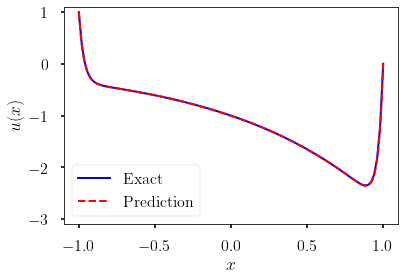

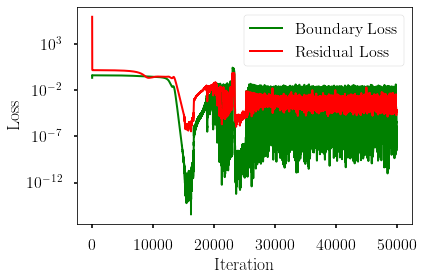

In [49]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f

@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f






#@tf.function(jit_compile=True)
@tf.function
def train_step(layers, W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu, lambda_b, beta):
    x_u = X_u_train_tf[:,0:1]
    x_f = X_f_train_tf[:,0:1]
    adpative_constant_bcs_list = []
    lambda_b_list = []
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u,W, b) 
        f_nn = net_f(x_f,W, b, nu)
        bc_loss =  tf.reduce_mean(tf.square(u_nn - u_train_tf))
        phys_loss = tf.reduce_mean(tf.square(f_nn)) 
        loss = lambda_b[-1]*bc_loss  + phys_loss
        loss = loss / (1 + lambda_b[-1])
        p_loss = phys_loss/(1 + lambda_b[-1])
        b_loss = lambda_b[-1]*bc_loss/(1 + lambda_b[-1])
    grad_loss = tape.gradient(loss, train_vars(W,b))
    opt.apply_gradients(zip(grad_loss, train_vars(W,b)))
    grads_bc = tape.gradient(bc_loss, train_vars(W,b))
    grads_phys = tape.gradient(phys_loss, train_vars(W,b))
    for i in range(len(layers) - 1):
        adpative_constant_bcs_list.append(
                tf.reduce_mean(tf.abs(grads_phys[i])) / tf.reduce_mean(tf.abs(grads_bc[i])))
        
    lambda_b_new = tf.reduce_mean(tf.stack(adpative_constant_bcs_list))
    lambda_b_new = (1-beta)*lambda_b[-1] + beta*lambda_b_new
    lambda_b_list.append(lambda_b_new)
                                      
    return loss, lambda_b_list, p_loss, b_loss


def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**-3
noise = 0.0        
N_f = 500
Nmax=50000

layers = [1, 8,8,8,8,8,8, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])
X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))
X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)
lam_b = np.array([1.0])
lam_b_tf= tf.convert_to_tensor(lam_b, dtype=tf.float32)                                
lambda_b_list = [lam_b_tf]                               
lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)
start_time = time.time()
n=0
loss = []
bc_loss = []
phys_loss = []
beta = 0.1

while n <= Nmax:
    loss_, lambda_b_out, phys_loss_, bc_loss_ = train_step(layers, W, b, X_u_train_tf,\
                                                u_train_tf, X_f_train_tf, optimizer, nu,lambda_b_list, beta)
    lambda_b_list = lambda_b_out
    loss.append(loss_) 
    bc_loss.append(bc_loss_)
    phys_loss.append(phys_loss_)
    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))               
print('Training time: %.4f' % (elapsed))


def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]
bc_loss_list = [bc_loss[i].numpy() for i in range(len(bc_loss))]
phys_loss_list = [phys_loss[i].numpy() for i in range(len(phys_loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,bc_loss_list, 'g-', linewidth = 2, label="Boundary Loss")   
ax.semilogy(ep,phys_loss_list, 'r-', linewidth = 2, label="Residual Loss")
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()


Error u: 7.362674e+00


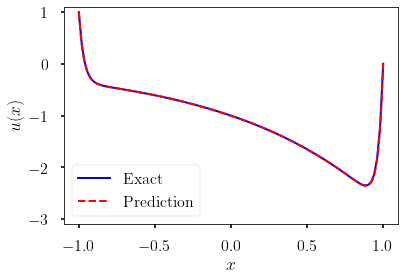

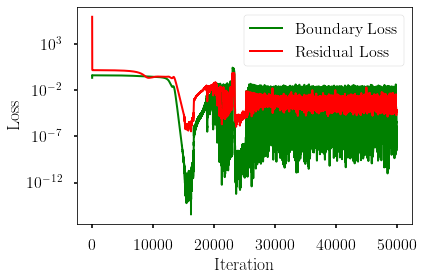

In [51]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]
bc_loss_list = [bc_loss[i].numpy() for i in range(len(bc_loss))]
phys_loss_list = [phys_loss[i].numpy() for i in range(len(phys_loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep, bc_loss_list, 'g-', linewidth = 2, label="Boundary Loss")   
ax.semilogy(ep,phys_loss_list, 'r-', linewidth = 2, label="Residual Loss")
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()

plt.show()


Training Constrained NN
Constrained NN: epoch:  0 training loss  [2.63500285] validation loss [2.41413355]
Constrained NN: epoch:  1 training loss  [2.51711035] validation loss [2.39730549]
Constrained NN: epoch:  2 training loss  [2.52513361] validation loss [2.39209414]
Constrained NN: epoch:  3 training loss  [2.51492214] validation loss [2.3860929]
Constrained NN: epoch:  4 training loss  [2.49249172] validation loss [2.37401009]
Constrained NN: epoch:  5 training loss  [2.46768618] validation loss [2.36257935]
Constrained NN: epoch:  6 training loss  [2.42770743] validation loss [2.34126163]
Constrained NN: epoch:  7 training loss  [2.38864899] validation loss [2.30307889]
Constrained NN: epoch:  8 training loss  [2.3431561] validation loss [2.25877333]
Constrained NN: epoch:  9 training loss  [2.29978752] validation loss [2.22249103]
Constrained NN: epoch:  10 training loss  [2.24441242] validation loss [2.17564964]
Constrained NN: epoch:  11 training loss  [2.18394804] validatio

Constrained NN: epoch:  112 training loss  [0.21772861] validation loss [0.31085807]
Constrained NN: epoch:  113 training loss  [0.21785212] validation loss [0.30999747]
Constrained NN: epoch:  114 training loss  [0.2172648] validation loss [0.31032413]
Constrained NN: epoch:  115 training loss  [0.21792556] validation loss [0.31088579]
Constrained NN: epoch:  116 training loss  [0.21716459] validation loss [0.31202769]
Constrained NN: epoch:  117 training loss  [0.21802007] validation loss [0.3094241]
Constrained NN: epoch:  118 training loss  [0.22123168] validation loss [0.30810195]
Constrained NN: epoch:  119 training loss  [0.21828301] validation loss [0.313059]
Constrained NN: epoch:  120 training loss  [0.21714588] validation loss [0.31475753]
Constrained NN: epoch:  121 training loss  [0.22057575] validation loss [0.30992526]
Constrained NN: epoch:  122 training loss  [0.21647885] validation loss [0.30990261]
Constrained NN: epoch:  123 training loss  [0.21737522] validation lo

Constrained NN: epoch:  225 training loss  [0.05941197] validation loss [0.06429429]
Constrained NN: epoch:  226 training loss  [0.06104057] validation loss [0.06697403]
Constrained NN: epoch:  227 training loss  [0.05888212] validation loss [0.06987689]
Constrained NN: epoch:  228 training loss  [0.05833783] validation loss [0.06408726]
Constrained NN: epoch:  229 training loss  [0.05961219] validation loss [0.06722119]
Constrained NN: epoch:  230 training loss  [0.06086004] validation loss [0.06305061]
Constrained NN: epoch:  231 training loss  [0.06013195] validation loss [0.06349923]
Constrained NN: epoch:  232 training loss  [0.06003641] validation loss [0.06715629]
Constrained NN: epoch:  233 training loss  [0.05773474] validation loss [0.06332976]
Constrained NN: epoch:  234 training loss  [0.05829723] validation loss [0.07143404]
Constrained NN: epoch:  235 training loss  [0.05905772] validation loss [0.06271783]
Constrained NN: epoch:  236 training loss  [0.05727261] validatio

Constrained NN: epoch:  337 training loss  [0.04875066] validation loss [0.05365091]
Constrained NN: epoch:  338 training loss  [0.04915711] validation loss [0.05332135]
Constrained NN: epoch:  339 training loss  [0.04871105] validation loss [0.05524453]
Constrained NN: epoch:  340 training loss  [0.04841172] validation loss [0.05217713]
Constrained NN: epoch:  341 training loss  [0.0484131] validation loss [0.05293742]
Constrained NN: epoch:  342 training loss  [0.04794864] validation loss [0.05476406]
Constrained NN: epoch:  343 training loss  [0.04818957] validation loss [0.05242311]
Constrained NN: epoch:  344 training loss  [0.04830015] validation loss [0.05163742]
Constrained NN: epoch:  345 training loss  [0.0475154] validation loss [0.05415096]
Constrained NN: epoch:  346 training loss  [0.04816901] validation loss [0.05164706]
Constrained NN: epoch:  347 training loss  [0.04821244] validation loss [0.05043378]
Constrained NN: epoch:  348 training loss  [0.04707753] validation 

Standard NN: epoch:  70 training loss  [1.46354723] validation loss [1.5528791]
Standard NN: epoch:  71 training loss  [1.44175589] validation loss [1.51975071]
Standard NN: epoch:  72 training loss  [1.41395736] validation loss [1.4542675]
Standard NN: epoch:  73 training loss  [1.36978602] validation loss [1.44762444]
Standard NN: epoch:  74 training loss  [1.32086515] validation loss [1.41757655]
Standard NN: epoch:  75 training loss  [1.31475616] validation loss [1.37236869]
Standard NN: epoch:  76 training loss  [1.29658639] validation loss [1.38555074]
Standard NN: epoch:  77 training loss  [1.25713825] validation loss [1.31880856]
Standard NN: epoch:  78 training loss  [1.20248294] validation loss [1.31669569]
Standard NN: epoch:  79 training loss  [1.15086579] validation loss [1.26187885]
Standard NN: epoch:  80 training loss  [1.1187849] validation loss [1.23342907]
Standard NN: epoch:  81 training loss  [1.07459283] validation loss [1.20894802]
Standard NN: epoch:  82 trainin

Standard NN: epoch:  185 training loss  [0.2117191] validation loss [0.30873019]
Standard NN: epoch:  186 training loss  [0.21024106] validation loss [0.2931141]
Standard NN: epoch:  187 training loss  [0.20727944] validation loss [0.26634961]
Standard NN: epoch:  188 training loss  [0.19336766] validation loss [0.27037406]
Standard NN: epoch:  189 training loss  [0.16787648] validation loss [0.27770054]
Standard NN: epoch:  190 training loss  [0.17208199] validation loss [0.29977167]
Standard NN: epoch:  191 training loss  [0.17790775] validation loss [0.253824]
Standard NN: epoch:  192 training loss  [0.18453756] validation loss [0.29444137]
Standard NN: epoch:  193 training loss  [0.20412451] validation loss [0.28756598]
Standard NN: epoch:  194 training loss  [0.21004599] validation loss [0.255775]
Standard NN: epoch:  195 training loss  [0.18991436] validation loss [0.31297925]
Standard NN: epoch:  196 training loss  [0.2022377] validation loss [0.32849267]
Standard NN: epoch:  19

Standard NN: epoch:  301 training loss  [0.1161289] validation loss [0.21582949]
Standard NN: epoch:  302 training loss  [0.11573786] validation loss [0.21557546]
Standard NN: epoch:  303 training loss  [0.11576845] validation loss [0.21557011]
Standard NN: epoch:  304 training loss  [0.11595426] validation loss [0.21583062]
Standard NN: epoch:  305 training loss  [0.11583906] validation loss [0.2155591]
Standard NN: epoch:  306 training loss  [0.1156654] validation loss [0.21496241]
Standard NN: epoch:  307 training loss  [0.11572459] validation loss [0.21445955]
Standard NN: epoch:  308 training loss  [0.11555552] validation loss [0.21457419]
Standard NN: epoch:  309 training loss  [0.11589238] validation loss [0.21523091]
Standard NN: epoch:  310 training loss  [0.11575668] validation loss [0.21469368]
Standard NN: epoch:  311 training loss  [0.11556227] validation loss [0.21416083]
Standard NN: epoch:  312 training loss  [0.11583819] validation loss [0.21457753]
Standard NN: epoch:

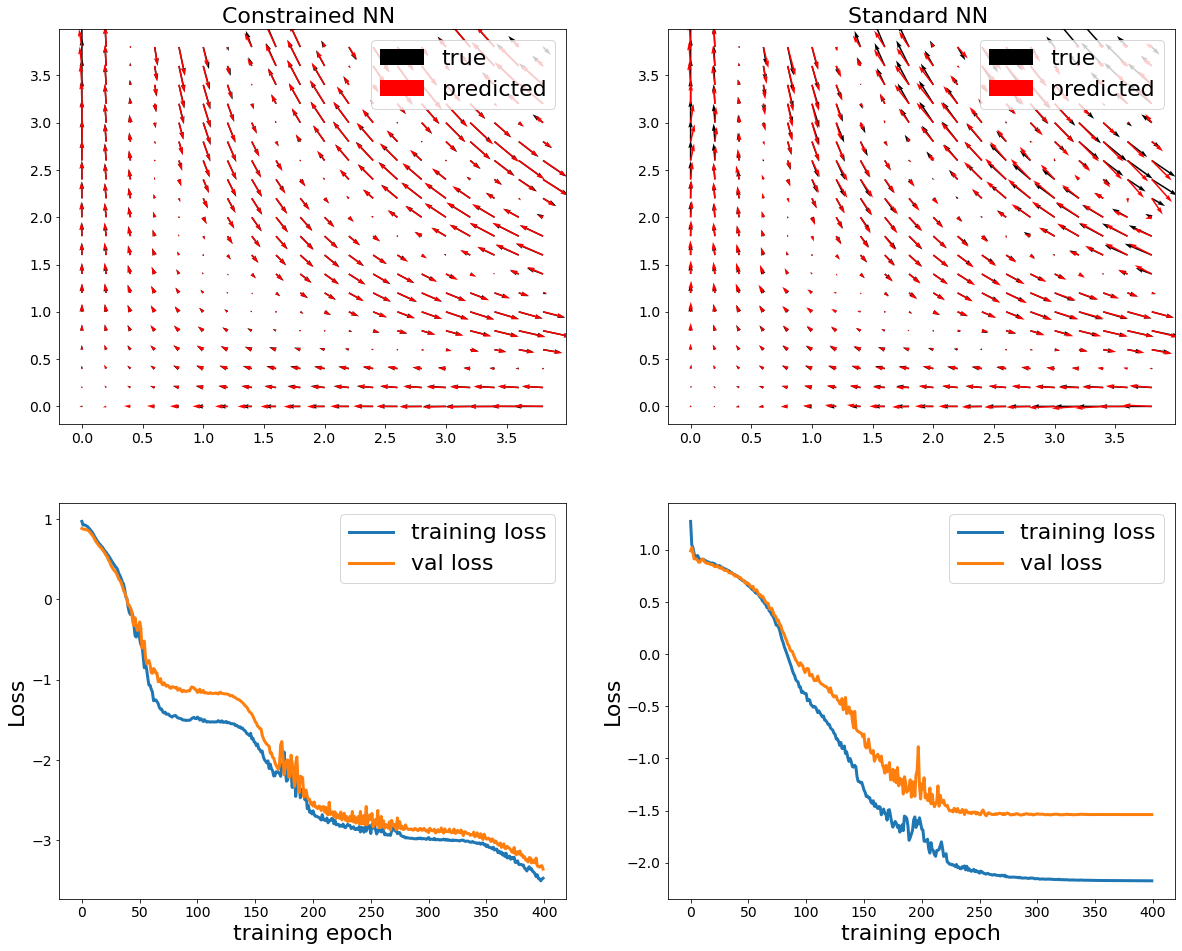

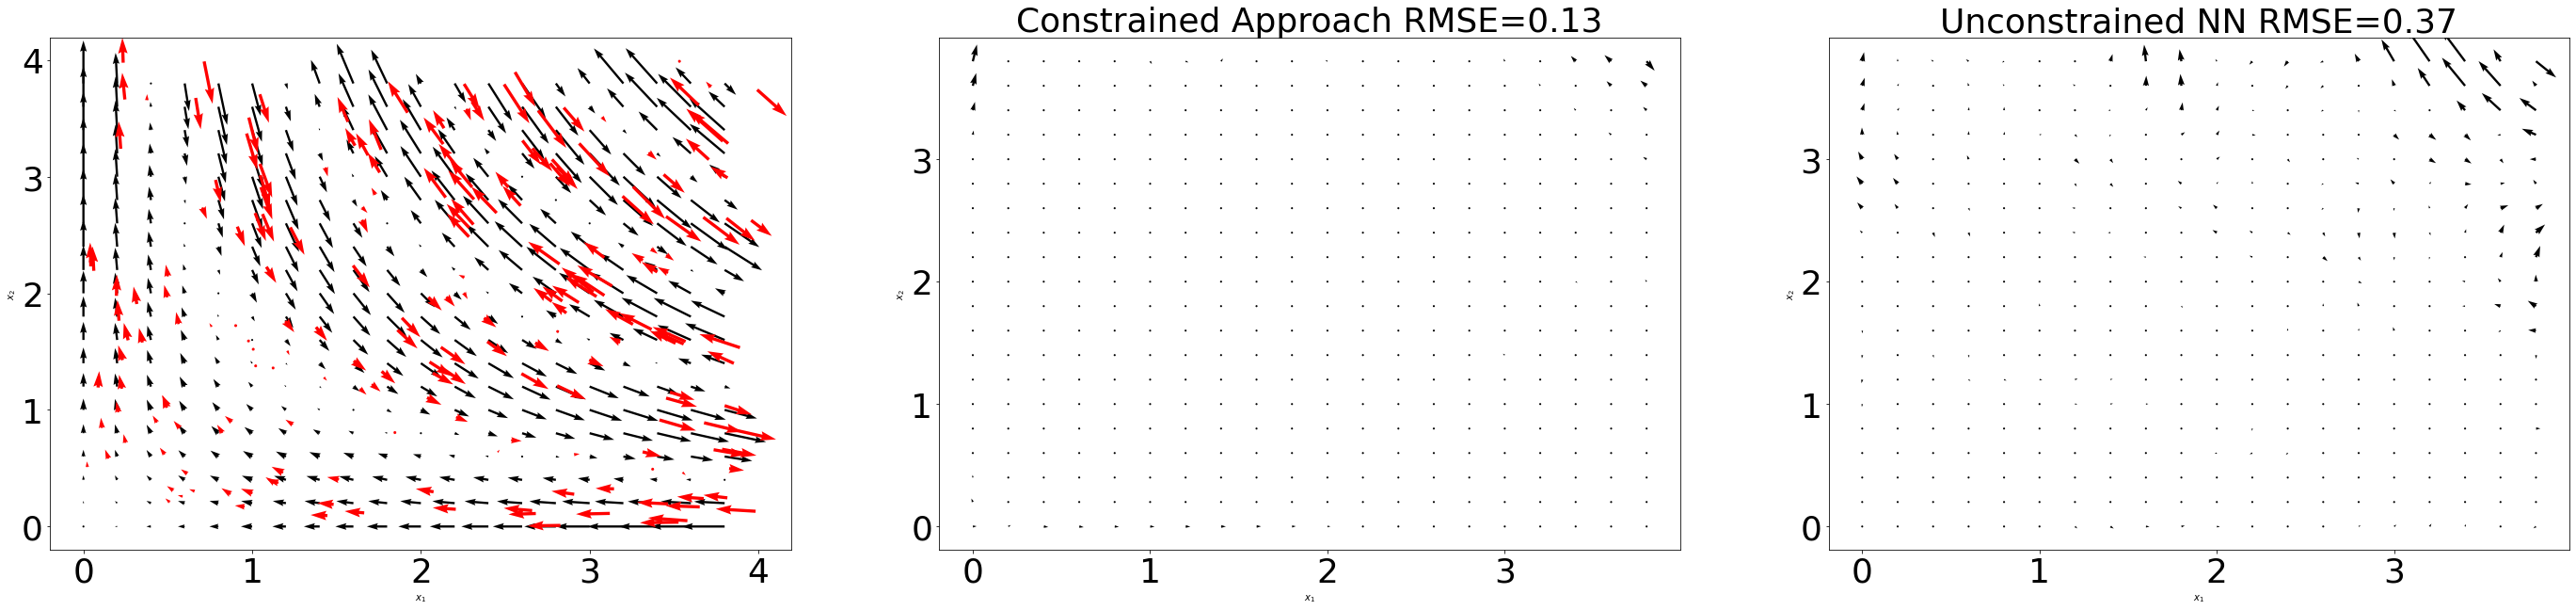

In [28]:
#https://github.com/jnh277/Linearly-Constrained-NN/blob/release/simulted_divergence_free.py

import torch
from matplotlib import pyplot as plt
from torch.utils import data
import numpy as np
import torch.autograd as ag
import torch.nn as nn
torch.manual_seed(1234)
epochs = 400
n_data = 200
### Input Data
def vector_field(x, y, a=0.01):
    v1 = torch.exp(-a*x*y)*(a*x*torch.sin(x*y) - x*torch.cos(x*y))
    v2 = torch.exp(-a*x*y)*(y*torch.cos(x*y) - a*y*torch.sin(x*y))
    return (v1, v2)


## ------------------ set up models-------------------------- ##
# set network size
n_in = 2
n_h1 = 100
n_h2 = 50
n_o = 1

# two outputs for the unconstrained network
n_o_uc = 2

# define model class
class DivFree2D(torch.nn.Module):
    def __init__(self, base_net):
        super(DivFree2D, self).__init__()
        self.base_net = base_net

    def forward(self, x):
        x.requires_grad = True
        y = self.base_net(x)
        dydx = ag.grad(outputs=y, inputs=x, create_graph=True, grad_outputs=torch.ones(y.size()),
                       retain_graph=True, only_inputs=True)[0]
        return y, dydx[:,1].unsqueeze(1), -dydx[:,0].unsqueeze(1)

model = DivFree2D(nn.Sequential(nn.Linear(n_in,n_h1),nn.Tanh(),nn.Linear(n_h1,n_h2),
                                         nn.Tanh(),nn.Linear(n_h2,n_o)))


model_uc = torch.nn.Sequential(
    torch.nn.Linear(n_in, n_h1),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h1, n_h2),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h2, n_o_uc),
)


# pregenerate validation data
x_val = 4.0 * torch.rand(2000, 2)
x1_val = x_val[:, 0].unsqueeze(1)
x2_val = x_val[:, 1].unsqueeze(1)

(v1, v2) = vector_field(x1_val, x2_val)
y1_val = v1 + 0.1 * torch.randn(x1_val.size())
y2_val = v2 + 0.1 * torch.randn(x1_val.size())
y_val = torch.cat((y1_val, y2_val), 1)


# Get the true function values on a grid
xv, yv = torch.meshgrid([torch.arange(0.0, 20.0) * 4.0 / 20.0, torch.arange(0.0, 20.0) * 4.0 / 20.0])
(v1, v2) = vector_field(xv, yv)

# generate training data
x_train = 4.0 * torch.rand(n_data, 2)
x1_train = x_train[:, 0].unsqueeze(1)
x2_train = x_train[:, 1].unsqueeze(1)

(v1_t, v2_t) = vector_field(x1_train, x2_train)
y1_train = v1_t + 0.1 * torch.randn(x1_train.size())
y2_train = v2_t + 0.1 * torch.randn(x1_train.size())


# define Dataset class
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, x1, x2, y1, y2):
        'Initialization'
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x1)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x1 = self.x1[index]
        x2 = self.x2[index]
        y1 = self.y1[index]
        y2 = self.y2[index]

        return x1, x2, y1, y2

training_set = Dataset(x1_train, x2_train, y1_train, y2_train)

# data loader Parameters
DL_params = {'batch_size': 100,
             'shuffle': True,
             'num_workers': 0,
             'pin_memory': False}
training_generator = data.DataLoader(training_set, **DL_params)


# ---------------  Set up and train the constrained model -------------------------------
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau\
                                    (optimizer, patience=10,
                                     min_lr=1e-10,
                                     factor=0.5, cooldown=15)

def train(epoch):
    model.train()
    total_loss = 0
    n_batches = 0
    for x1_train, x2_train, y1_train, y2_train in training_generator:
        optimizer.zero_grad()
        x_train = torch.cat((x1_train, x2_train), 1)
        (yhat, v1hat, v2hat) = model(x_train)
        loss = (criterion(y1_train, v1hat) + criterion(y2_train, v2hat)) / 2  # divide by 2 as it is a mean
        loss.backward()
        optimizer.step()
        total_loss += loss
        n_batches += 1
    return total_loss / n_batches

def eval(epoch):
    model.eval()
    # with torch.no_grad():
    (yhat, v1hat, v2hat) = model(x_val)
    loss = (criterion(y1_val, v1hat) + criterion(y2_val, v2hat)) / 2
    return loss.cpu()


train_loss = np.empty([epochs, 1])
val_loss = np.empty([epochs, 1])

print('Training Constrained NN')

for epoch in range(epochs):
    train_loss[epoch] = train(epoch).detach().numpy()
    v_loss = eval(epoch)
    scheduler.step(v_loss)
    val_loss[epoch] = v_loss.detach().numpy()
    print('Constrained NN: epoch: ', epoch, 'training loss ', train_loss[epoch], \
          'validation loss', val_loss[epoch])


# work out the rms error for this one
x_pred = torch.cat((xv.reshape(20 * 20, 1), yv.reshape(20 * 20, 1)), 1)
(f_pred, v1_pred, v2_pred) = model(x_pred)
error_new = torch.cat((v1.reshape(400, 1) - v1_pred.detach(), v2.reshape(400, 1) - v2_pred.detach()), 0)
rms_error = torch.sqrt(sum(error_new * error_new) / 800)

# ---------------  Set up and train the uncconstrained model -------------------------------
optimizer_uc = torch.optim.Adam(model_uc.parameters(), lr=0.01)
scheduler_uc = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_uc, patience=10,
                                                     min_lr=1e-10,
                                                    factor=0.5,
                                                    cooldown=15)

def train_uc(epoch):
    model_uc.train()
    total_loss = 0
    n_batches = 0
    for x1_train, x2_train, y1_train, y2_train in training_generator:
        optimizer_uc.zero_grad()
        x_train = torch.cat((x1_train, x2_train), 1)
        vhat = model_uc(x_train)
        y_train = torch.cat((y1_train, y2_train), 1)
        loss = criterion(y_train, vhat)
        loss.backward()
        optimizer_uc.step()
        total_loss += loss.cpu()
        n_batches += 1
    return total_loss / n_batches

def eval_uc(epoch):
    model_uc.eval()
    with torch.no_grad():
        (vhat) = model_uc(x_val)
        loss = criterion(y_val, vhat)
    return loss.cpu()


train_loss_uc = np.empty([epochs, 1])
val_loss_uc = np.empty([epochs, 1])


print('Training standard NN')

for epoch in range(epochs):
    train_loss_uc[epoch] = train_uc(epoch).detach().numpy()
    v_loss = eval_uc(epoch)
    scheduler_uc.step(v_loss)
    val_loss_uc[epoch] = v_loss.detach().numpy()
    print('Standard NN: epoch: ', epoch, 'training loss ', \
          train_loss_uc[epoch], 'validation loss', val_loss_uc[epoch])


# work out final rms error for unconstrainted net
(v_pred_uc) = model_uc(x_pred)
v1_pred_uc = v_pred_uc[:, 0]
v2_pred_uc = v_pred_uc[:, 1]

error_uc = torch.cat((v1.reshape(400) - v1_pred_uc.detach(), v2.reshape(400) - v2_pred_uc.detach()), 0)
rms_uc = torch.sqrt(sum(error_uc * error_uc) / 800)



print('Finished')
print("Final RMSE for constrained neural network: ",rms_error.item())
print("Final RMSE for standard neural network: ",rms_uc.item())

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(2, 2, figsize=(20, 16))
    # ax.pcolor(xv,yv,f_scalar)
    ax[0, 0].quiver(xv, yv, v1, v2)
    ax[0, 0].quiver(xv, yv, v1_pred.reshape(20, 20).detach(), v2_pred.reshape(20, 20).detach(), color='r')
    ax[0, 0].legend(['true', 'predicted'], fontsize=22)
    ax[0, 0].set_title('Constrained NN ', fontsize=22)
    ax[0, 0].tick_params(axis='x', labelsize=14 )
    ax[0, 0].tick_params(axis='y', labelsize=14 )


    ax[1, 0].plot(np.log(train_loss),lw=3.0)
    ax[1, 0].plot(np.log(val_loss), lw=3.0)
    # ax[1].plot(loss_save[1:epoch].log().detach().numpy())
    ax[1, 0].set_xlabel('training epoch',  fontsize=22)
    ax[1, 0].set_ylabel('Loss',  fontsize=22)
    ax[1, 0].legend(['training loss', 'val loss'], fontsize=22)
    ax[1, 0].tick_params(axis='x', labelsize=14 )
    ax[1, 0].tick_params(axis='y', labelsize=14 )

    ax[0, 1].quiver(xv, yv, v1, v2)
    ax[0, 1].quiver(xv, yv, v1_pred_uc.reshape(20, 20).detach(), v2_pred_uc.reshape(20, 20).detach(), color='r')
    ax[0, 1].legend(['true', 'predicted'], fontsize=22)
    ax[0, 1].set_title('Standard NN ',fontsize=22)
    ax[0, 1].tick_params(axis='x', labelsize=14 )
    ax[0,1].tick_params(axis='y', labelsize=14 )

    ax[1, 1].plot(np.log(train_loss_uc),lw=3.0)
    ax[1, 1].plot(np.log(val_loss_uc),lw=3.0)
    ax[1, 1].set_ylabel('Loss', fontsize=22)
    ax[1, 1].set_xlabel('training epoch', fontsize=22)
    ax[1, 1].legend(['training loss','val loss'], fontsize=22)
    ax[1, 1].tick_params(axis='x', labelsize=14)
    ax[1,1].tick_params(axis='y', labelsize=14 )
    plt.savefig("Figure_1.png", dpi=300)
    plt.show()
   
    

    # Initialize second plot
    f2, ax2 = plt.subplots(1, 3, figsize=(48, 10))
    Q = ax2[0].quiver(xv, yv, v1, v2, scale=None, scale_units='inches')
    Q._init()
    assert isinstance(Q.scale, float)
    ax2[0].quiver(x1_train, x2_train, y1_train, y2_train, scale=Q.scale, scale_units='inches', color='r')
    ax2[0].set_xlabel('$x_1$')
    ax2[0].set_ylabel('$x_2$')
    ax2[0].tick_params(axis='x', labelsize=36)
    ax2[0].tick_params(axis='y', labelsize=36)
    


    error_new = torch.cat((v1.reshape(400, 1) - v1_pred.detach(), v2.reshape(400, 1) - v2_pred.detach()), 0)
    rms_new = torch.sqrt(sum(error_new * error_new) / 800)

    ax2[1].quiver(xv, yv, v1 - v1_pred.reshape(20, 20).detach(), v2 - v2_pred.reshape(20, 20).detach(),
                  scale=Q.scale, scale_units='inches')
    ax2[1].set_xlabel('$x_1$')
    ax2[1].set_ylabel('$x_2$')
    ax2[1].set_title('Constrained Approach RMSE={0:.2f}'.format(rms_new.item()), fontsize=36)
    ax2[1].tick_params(axis='x', labelsize=36 )
    ax2[1].tick_params(axis='y', labelsize=36 )
    


    error_uc = torch.cat((v1.reshape(400) - v1_pred_uc.detach(), v2.reshape(400) - v2_pred_uc.detach()), 0)
    rms_uc = torch.sqrt(sum(error_uc * error_uc) / 800)

    ax2[2].quiver(xv, yv, v1 - v1_pred_uc.reshape(20, 20).detach(), v2 - v2_pred_uc.reshape(20, 20).detach(),
                  scale=Q.scale, scale_units='inches')
    ax2[2].set_xlabel('$x_1$')
    ax2[2].set_ylabel('$x_2$')
    ax2[2].set_title('Unconstrained NN RMSE={0:.2f}'.format(rms_uc.item()), fontsize=36)
    ax2[2].tick_params(axis='x', labelsize=36 )
    ax2[2].tick_params(axis='y', labelsize=36 )
    plt.savefig("Figure_2.png", dpi=300)
    plt.show()


## Multi-fidelity Deep Neural Network

n: 1000, loss: 3.656e+00, loss_lf: 2.703e+00, loss_hf: 7.138e-01
n: 2000, loss: 5.050e-01, loss_lf: 2.545e-01, loss_hf: 1.417e-02
n: 3000, loss: 2.946e-01, loss_lf: 7.560e-02, loss_hf: 8.657e-04
n: 4000, loss: 2.298e-01, loss_lf: 3.119e-02, loss_hf: 7.511e-04
n: 5000, loss: 2.084e-01, loss_lf: 2.633e-02, loss_hf: 6.609e-04
n: 6000, loss: 1.937e-01, loss_lf: 2.351e-02, loss_hf: 5.517e-04
n: 7000, loss: 1.831e-01, loss_lf: 2.110e-02, loss_hf: 4.560e-04
n: 8000, loss: 1.747e-01, loss_lf: 2.026e-02, loss_hf: 3.481e-04
n: 9000, loss: 1.652e-01, loss_lf: 1.980e-02, loss_hf: 2.279e-04
n: 10000, loss: 1.563e-01, loss_lf: 1.923e-02, loss_hf: 1.767e-04
n: 11000, loss: 1.477e-01, loss_lf: 1.882e-02, loss_hf: 1.583e-04
n: 12000, loss: 1.406e-01, loss_lf: 1.861e-02, loss_hf: 1.575e-04
n: 13000, loss: 1.179e-01, loss_lf: 9.327e-04, loss_hf: 1.766e-04
n: 14000, loss: 1.126e-01, loss_lf: 2.849e-05, loss_hf: 2.044e-04
n: 15000, loss: 1.078e-01, loss_lf: 1.923e-05, loss_hf: 2.220e-04
n: 16000, loss: 1.0

NameError: name 'x_test' is not defined

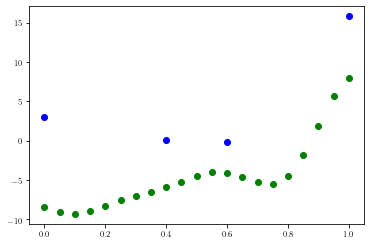

In [3]:
## Code for Multi-fidelity DNN
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1234)
tf.random.set_seed(1234)

class DNN:
    def __init__(self):
        pass
    
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l-1]
            out_dim = layers[l]
            std = np.sqrt(2/(in_dim + out_dim))
            weight = tf.Variable(tf.random.truncated_normal(shape=[in_dim, out_dim], stddev=std))
            bias = tf.Variable(tf.zeros(shape=[1, out_dim]))
            W.append(weight)
            b.append(bias)

        return W, b

    def fnn(self, W, b, X, Xmin, Xmax):
        A = 2.0*(X - Xmin)/(Xmax - Xmin) - 1.0
        L = len(W)
        for i in range(L-1):
            A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        
        return Y
    
    def train_vars(self, W, b):
        return W + b

    

    
# Exact Low Fidelity Fucntion    
def fun_lf(x):
    y = 0.5*(6*x - 2)**2*np.sin(12*x - 4) + 10*(x - 0.5) - 5
    return y

#Exact high-fidelity function
def fun_hf(x):
    y = (6*x - 2)**2*np.sin(12*x - 4)
    return y





@tf.function
def train_step(W, b, model, x_train_lf, y_train_lf , x_train_hf, y_train_hf,opt, train=1):
    W_lf = W[0]
    W_hf_nl = W[1]
    W_hf_l = W[2] 
    b_lf =   b[0]
    b_hf_nl = b[1]
    b_hf_l = b[2]
    if train==1:
        with tf.GradientTape() as tape:
            tape.watch([W_lf, W_hf_nl,W_hf_l, b_lf, b_hf_nl, b_hf_l])
            y_pred_lf = model.fnn(W_lf, b_lf, x_train_lf, Xmin, Xmax)
            y_pred_hf_nl = model.fnn(W_hf_nl, b_hf_nl, x_train_hf, Xhmin, Xhmax)
            y_pred_hf_l = model.fnn(W_hf_l, b_hf_l, x_train_hf, Xhmin, Xhmax)
            y_pred_hf = y_pred_hf_l + y_pred_hf_nl
            loss_l2 = 0.01*tf.add_n([tf.nn.l2_loss(w_) for w_ in W_hf_nl])
            loss_lf = tf.reduce_mean(tf.square(y_pred_lf - y_train_lf))
            loss_hf =  tf.reduce_mean(tf.square(y_pred_hf - y_train_hf))
            loss = loss_lf + loss_hf + loss_l2
        grads = tape.gradient(loss, W_lf + b_lf + W_hf_nl + b_hf_nl +  W_hf_l + b_hf_l)
        opt.apply_gradients(zip(grads, W_lf + b_lf + W_hf_nl + b_hf_nl +  W_hf_l + b_hf_l))
        return loss, loss_lf, loss_hf
        
    if train == 0:
        y_pred_lf = model.fnn(W_lf, b_lf, x_train_lf, Xmin, Xmax)
        y_pred_hf_nl = model.fnn(W_hf_nl, b_hf_nl, x_train_hf, Xhmin, Xhmax)
        y_pred_hf_l = model.fnn(W_hf_l, b_hf_l, x_train_hf, Xhmin, Xhmax)
        y_pred_hf = y_pred_hf_l + y_pred_hf_nl
        return  y_pred_hf, y_pred_lf




## Dimension of Function
D = 1
#low-fidelity NN
layers_lf = [D] + 2*[20] + [1]

#nonlinear correlation
layers_hf_nl = [D+1] + 2*[10] + [1]

#linear correlation
layers_hf_l = [D+1] + [1]

#low-fidelity training data
x_lf = np.linspace(0, 1, 21).reshape((-1, 1))
y_lf = fun_lf(x_lf)

#high-fidelity training data
x_hf = np.array([0., 0.4, 0.6, 1.0]).reshape((-1, 1))

#low-fidelity training data at x_H
y_lf_hf = fun_lf(x_hf)
y_hf = fun_hf(x_hf)
X_hf = np.hstack((x_hf, y_lf_hf))

Xmin = x_lf.min(0)
Xmax = x_lf.max(0)
Ymin = y_lf.min(0)
Ymax = y_lf.max(0)

Xhmin = np.hstack((Xmin, Ymin))
Xhmax = np.hstack((Xmax, Ymax))

x_train_lf = tf.convert_to_tensor(x_lf, dtype=tf.float32)
y_train_lf = tf.convert_to_tensor(y_lf, dtype=tf.float32)
x_train_hf = tf.convert_to_tensor(X_hf, dtype=tf.float32)
y_train_hf = tf.convert_to_tensor(y_hf, dtype=tf.float32)

model = DNN()
W_lf, b_lf = model.hyper_initial(layers_lf)
W_hf_nl, b_hf_nl = model.hyper_initial(layers_hf_nl)
W_hf_l, b_hf_l = model.hyper_initial(layers_hf_l)

W=[W_lf, W_hf_nl, W_hf_l]
b=[b_lf, b_hf_nl, b_hf_l]

lr =0.001
optimizer = tf.optimizers.Adam(learning_rate=lr)



nmax = 30000
loss_c = 1.0e-3
loss_ = 1.0
n = 0

while n < nmax:
    n += 1
    loss_, loss_lf_, loss_hf_ = train_step(W, b, model, x_train_lf, y_train_lf , \
                                           x_train_hf, y_train_hf,optimizer, train=1)
    if n%1000 == 0:
        print('n: %d, loss: %.3e, loss_lf: %.3e, loss_hf: %.3e'%(n, loss_, loss_lf_, loss_hf_))
        
        
plt.figure(facecolor='w')
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=10)
plt.plot(x_lf, y_lf, 'go', label="Low-fidelity Training Data")
plt.plot(x_hf, y_hf, 'bo', label="High-fidelity Training Data")
plt.plot(x_test, y_lf_test, 'r--', label="Low-fidelity function")
plt.plot(x_test, y_hf_test, 'c--', label="High-fidelity function")
plt.legend()
plt.show()